<a href="https://www.kaggle.com/code/jorgemmlrodrigues/walmart-price-pred?scriptVersionId=247661249" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
"""
# Run from here if in Kaggle
!git -C /kaggle/working clone --depth 1 https://github.com/JorgeMMLRodrigues/ml_walmart_price.git || \
 git -C /kaggle/working/ml_walmart_price pull    
!pip install -q -r /kaggle/working/ml_walmart_price/requirements.txt

import sys, os
os.chdir("/kaggle/working/ml_walmart_price")
sys.path.insert(0, os.getcwd())

"""

'\n# Run from here if in Kaggle\n!git -C /kaggle/working clone --depth 1 https://github.com/JorgeMMLRodrigues/ml_walmart_price.git ||  git -C /kaggle/working/ml_walmart_price pull    \n!pip install -q -r /kaggle/working/ml_walmart_price/requirements.txt\n\nimport sys, os\nos.chdir("/kaggle/working/ml_walmart_price")\nsys.path.insert(0, os.getcwd())\n\n'

In [2]:
# Run Model from here if in vscode (not kaggle)
!pip install -r requirements.txt
import sys, os
from utils.trainer import ModelTrainer

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import random, time, inspect,json,requests, math, logging, gc, warnings, csv,glob, shap
from pathlib import Path

from datetime import date, datetime, timedelta
from dateutil.easter import easter

from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import yfinance as yf

import akshare as ak

from pandas_datareader.data import DataReader
from pandas_datareader import wb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score,make_scorer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.linear_model import RidgeCV, Lasso,ElasticNetCV, HuberRegressor,Ridge

from sklearn.experimental import enable_halving_search_cv 



from sklearn.model_selection import TimeSeriesSplit,ParameterGrid,GridSearchCV, HalvingRandomSearchCV,  ParameterSampler, HalvingGridSearchCV

from sklearn.inspection import PartialDependenceDisplay,permutation_importance
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor,ExtraTreesRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from ngboost import NGBRegressor
from ngboost.distns import Normal, Laplace
from ngboost.scores import LogScore, CRPS
from lightgbm              import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.exceptions import ConvergenceWarning

#from sklearn.model_selection import RollingForecastCV

#from pmdarima import auto_arima
#from pmdarima.arima import ARIMA


#from pmdarima.model_selection import RollingForecastCV

#from sklearn.impute import SimpleImputer

from collections import Counter
from joblib import Parallel, delayed

from ngboost.learners import default_tree_learner
from matplotlib.ticker import FuncFormatter



c:\Users\estif\Desktop\DataAnalyst\_DataCourse_IronHack\Quests\ml_walmart_price\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# skip cells:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):

    return

# Data

## Data Exploration

In [4]:
%%skip
df_walmart_train = pd.read_csv('csv_files/walmart_data/train.csv')
df_walmart_test = pd.read_csv('csv_files/walmart_data/test.csv')
df_walmart_features = pd.read_csv('csv_files/walmart_data/features.csv')
df_walmart_stores = pd.read_csv('csv_files/walmart_data/stores.csv')

df_walmart_train["Date"] = pd.to_datetime(df_walmart_train["Date"], errors="raise")
df_walmart_test["Date"] = pd.to_datetime(df_walmart_test["Date"], errors="raise")
df_walmart_features["Date"] = pd.to_datetime(df_walmart_features["Date"], errors="raise")

In [5]:
%%skip
df_walmart_train

In [6]:
%%skip
df_walmart_test

In [7]:
%%skip
df_walmart_features


## Data Gathering

#### Sp500

In [8]:
%%skip
# SP500 Index
START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()


daily = yf.download(
    "^GSPC",           # S&P 500 index ticker
    start=START_DATE,
    end=END_DATE,
    interval="1d",
    auto_adjust=True,
    progress=False,
)

if isinstance(daily.columns, pd.MultiIndex):
    lvl0 = daily.columns.get_level_values(0)
    if "Close" in lvl0:
        close_prices = daily.xs("Close", axis=1, level=0)
    elif "Adj Close" in lvl0:
        close_prices = daily.xs("Adj Close", axis=1, level=0)
    else:
        raise KeyError("Neither 'Close' nor 'Adj Close' found in data")
else:
    if "Close" in daily.columns:
        close_prices = daily["Close"]
    else:
        close_prices = daily["Adj Close"]


weekly_mean_close = close_prices.resample("W-FRI").mean()

if isinstance(weekly_mean_close, pd.Series):
    df_sp500 = weekly_mean_close.to_frame(name="SPX_Weekly_Mean_Close")
else:
    df_sp500 = weekly_mean_close.copy()
    df_sp500.columns = ["SPX_Weekly_Mean_Close"]


OUTFILE = "csv_files/idea_csv/sp500_weekly_mean_close.csv"
df_sp500.to_csv(OUTFILE)



In [9]:
%%skip
df_sp500 = pd.read_csv("csv_files/idea_csv/sp500_weekly_mean_close.csv")
df_sp500

#### Walmart Stock Price

In [10]:
%%skip
START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()


daily = yf.download(
    "WMT",           
    start=START_DATE,
    end=END_DATE,
    interval="1d",
    auto_adjust=True, 
    progress=False,
)


if isinstance(daily.columns, pd.MultiIndex):
    lvl0 = daily.columns.get_level_values(0)
    if "Close" in lvl0:
        close_prices = daily.xs("Close", axis=1, level=0)
    elif "Adj Close" in lvl0:
        close_prices = daily.xs("Adj Close", axis=1, level=0)
    else:
        raise KeyError("Neither 'Close' nor 'Adj Close' found in data")
else:
    if "Close" in daily.columns:
        close_prices = daily["Close"]
    else:
        close_prices = daily["Adj Close"]


weekly_mean_close = close_prices.resample("W-FRI").mean()


if isinstance(weekly_mean_close, pd.Series):
    df_walmart_stock = weekly_mean_close.to_frame(name="WMT_Weekly_Mean_Close")
else:
    df_walmart_stock = weekly_mean_close.copy()
    df_walmart_stock.columns = ["WMT_Weekly_Mean_Close"]


OUTFILE = "csv_files/idea_csv/wmt_weekly_mean_close.csv"
df_walmart_stock.to_csv(OUTFILE)



In [11]:
%%skip
df_walmart_stock = pd.read_csv("csv_files/idea_csv/wmt_weekly_mean_close.csv")
df_walmart_stock

#### External Logistic companies Walmart

In [12]:
%%skip
#   - ARCB: ArcBest Corporation (ABF Logistics / ArcBest Freight)
#   - AIT: AIT Worldwide Logistics
#   - CEVA: CEVA Logistics
#   - DPW.DE: Deutsche Post (DHL Freight / DHL Supply Chain) on XETRA
#   - FDX: FedEx Corporation (FedEx Freight)
#   - SAIA: Saia, Inc. (Saia Motor Freight Line)
#   - TFII.TO: TFI International (TForce Freight) on TSX
#   - XPO: XPO Logistics, Inc.
#   - ODFL: Old Dominion Freight Line, Inc.
#   - UPS: United Parcel Service, Inc.
#   - JBHT: J.B. Hunt Transport Services, Inc.
# Note: Some private carriers (Estes Express, R+L Carriers) are not publicly traded.

TICKERS = [
    "ARCB", "AIT", "CEVA", "DPW.DE", "FDX",
    "SAIA", "TFII.TO", "XPO", "ODFL", "UPS", "JBHT"
]

START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()

daily = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    interval="1d",
    auto_adjust=True,
    group_by="ticker",
    threads=True,
    progress=True,
)

close = pd.DataFrame()
for sym in TICKERS:
    try:
        series = daily[sym]["Close"]
        close[sym] = series
    except Exception:
        print(f"Skipping {sym!r}: no data available or ticker invalid")


before = close.shape[1]
close = close.dropna(axis=1, how="all")
after = close.shape[1]
print(f"Dropped {before-after} tickers; {after} tickers remain for analysis")

df_logistics = close.resample("W-FRI").mean().round(4)

df_logistics.columns = [f"{sym}_df_logistics_Close" for sym in df_logistics.columns]

OUTFILE = "csv_files/idea_csv/logistics_df_logistics_close.csv"
df_logistics.to_csv(OUTFILE)


In [13]:
%%skip
df_logistics = pd.read_csv("csv_files/idea_csv/logistics_df_logistics_close.csv")
df_logistics

#### Official China PMI (Caixin PMI only starts in 2014)


In [14]:
%%skip
# All AkShare functions containing "pmi"

df_official = ak.macro_china_pmi()

print("Columns in df_official:", df_official.columns.tolist())


In [15]:
%%skip
# 1) Fetch the official China PMI data
df_official = ak.macro_china_pmi()

# 2) Rename Chinese column names to English
df_official = df_official.rename(columns={
    "月份": "Date",
    "制造业-指数": "Official_Manufacturing_PMI",
    "制造业-同比增长": "Official_Manufacturing_PMI_YoY",
    "非制造业-指数": "Official_Services_PMI",
    "非制造业-同比增长": "Official_Services_PMI_YoY",
})

# 3) Clean and parse the 'Date' column ("YYYY年MM月份" → "YYYY-MM")
df_official["Date"] = (
    df_official["Date"]
      .str.replace("年", "-", regex=False)
      .str.replace("月份", "", regex=False)
)
df_official["Date"] = pd.to_datetime(df_official["Date"], format="%Y-%m")

# 4) Set Date as the index and sort
df_official = df_official.set_index("Date").sort_index()

# 5) Subset to the period 2009-01-01 through 2014-12-31
df_pmi_china = df_official.loc["2009-01-01":"2014-12-31"]
df_pmi_china.to_csv("csv_files/idea_csv/df_pmi_china.csv")

In [16]:
%%skip
df_pmi_china = pd.read_csv("csv_files/idea_csv/df_pmi_china.csv")
df_pmi_china

#### PCE USA (Personal Consumption Expenditures)


In [17]:
%%skip
START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()

df_pce = DataReader("PCE", "fred", start=START_DATE, end=END_DATE)

df_pce.columns = ["Personal_Consumption_Expenditures"]

# 4) Save and quick sanity-check
OUTFILE = "csv_files/idea_csv/personal_consumption_expenditures.csv"
df_pce.to_csv(OUTFILE)


In [18]:
%%skip
df_pce = pd.read_csv("csv_files/idea_csv/personal_consumption_expenditures.csv")
df_pce

#### Interest Rates USA (Fed Funds Rate & Tbill 3 Months Yield)

In [19]:
%%skip
START = "2001-06-01"               
END   = date.today().isoformat()


fed  = DataReader("FEDFUNDS", "fred", START, END)
tbill = DataReader("DGS3MO",  "fred", START, END)

df_interest_rates = pd.concat([fed, tbill], axis=1).rename(columns={
    "FEDFUNDS": "Fed_Funds_Rate",
    "DGS3MO":   "TBill_3mo_Yield",
})
df_interest_rates = df_interest_rates.resample("W-FRI").mean()

OUTFILE = "csv_files/idea_csv/df_interest_rates.csv"
df_interest_rates.to_csv(OUTFILE)

In [20]:
%%skip
df_interest_rates = pd.read_csv("csv_files/idea_csv/df_interest_rates.csv")
df_interest_rates

#### CCI USA (Consumer Confidence Index) from University of Michigan

In [21]:
%%skip
START_DATE = "2001-06-17"
END_DATE   = date.today().isoformat()

df_us_cci = DataReader("UMCSENT", "fred", START_DATE, END_DATE)
df_us_cci.columns = ["Consumer_Sentiment_UMich"]

OUTFILE = "csv_files/idea_csv/consumer_confidence_index.csv"
df_us_cci.to_csv(OUTFILE)

In [22]:
%%skip
df_us_cci = pd.read_csv("csv_files/idea_csv/consumer_confidence_index.csv")
df_us_cci

#### U.S.A Advance Retail Sales: Retail Trade and Food Services

In [23]:
%%skip
START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()

# RSAFS = Advance Retail Sales: Retail Trade and Food Services (Millions of Dollars, SA)
df_us_retail = DataReader("RSAFS", "fred", START_DATE, END_DATE)

df_us_retail.columns = ["Retail_Sales_Retail_and_Food_Services_USA"]

OUTFILE = "csv_files/idea_csv/usa_retail_sales.csv"
df_us_retail.to_csv(OUTFILE)

In [24]:
%%skip
df_us_retail = pd.read_csv("csv_files/idea_csv/usa_retail_sales.csv")
df_us_retail

#### Exchange Rates (China, Mexico, Canada, India, Vietnam)


In [25]:
%%skip
START = "2001-06-17"                 
END   = date.today().isoformat()

#    China (CNY per USD): DEXCHUS  
#    Mexico (MXN per USD): DEXMXUS  
#    Canada (CAD per USD): DEXCAUS  
#    India (INR per USD): DEXINUS  
cny = DataReader("DEXCHUS", "fred", START, END)
mxn = DataReader("DEXMXUS", "fred", START, END)
cad = DataReader("DEXCAUS", "fred", START, END)
inr = DataReader("DEXINUS", "fred", START, END)

# Vietnam via yfinance
vn_df = yf.download(
    "USDVND=X",
    start=START,
    end=END,
    progress=False
)
vn = vn_df[["Close"]].rename(columns={"Close": "VND_per_USD"})


fx = pd.concat([cny, mxn, cad, inr, vn], axis=1).rename(columns={
    "DEXCHUS": "CNY_per_USD",
    "DEXMXUS": "MXN_per_USD",
    "DEXCAUS": "CAD_per_USD",
    "DEXINUS": "INR_per_USD"
})

df_fx = fx.resample("W-FRI").mean().dropna(how="all").round(4)


OUTFILE = "csv_files/idea_csv/foreign_exchange.csv"
df_fx.to_csv(OUTFILE)

In [26]:
%%skip
df_fx = pd.read_csv("csv_files/idea_csv/foreign_exchange.csv")
df_fx

#### US External Tax Rate

In [27]:
%%skip
INDICATOR   = "TM.TAX.MRCH.WM.AR.ZS"  # Tariff rate %
COUNTRIES   = ["CN", "IN", "MX", "CA", "VN"]
START_YEAR  = 2000
END_YEAR    = date.today().year

# from World Bank
df_us_tariff = wb.download(
    indicator=INDICATOR,
    country=COUNTRIES,
    start=START_YEAR,
    end=END_YEAR
)

df_us_tariff = df_us_tariff.reset_index().pivot(index="year", columns="country", values=INDICATOR)

df_us_tariff = df_us_tariff.rename(columns={
    "CN": "China_Applied_Tariff_%", 
    "IN": "India_Applied_Tariff_%", 
    "MX": "Mexico_Applied_Tariff_%", 
    "CA": "Canada_Applied_Tariff_%", 
    "VN": "Vietnam_Applied_Tariff_%"
})


OUTFILE = "csv_files/idea_csv/external_tax_rates.csv"
df_us_tariff.to_csv(OUTFILE, index_label="Year")

In [28]:
%%skip
df_us_tariff = pd.read_csv("csv_files/idea_csv/external_tax_rates.csv")
df_us_tariff

#### Holidays

In [29]:
%%skip
def nth_weekday(year, month, weekday, n):
    """
    Return the date of the nth occurrence of the given weekday
    in the specified month and year.
    weekday: Monday=0, Sunday=6
    """
    d = date(year, month, 1)
    count = 0
    while True:
        if d.weekday() == weekday:
            count += 1
            if count == n:
                return d
        d += timedelta(days=1)

# Super Bowl dates per your list
super_bowl_day = {2010: 12, 2011: 11, 2012: 10, 2013: 8}

years = range(2010, 2014)
records = []

for year in years:
    # Fixed‐date holidays
    records += [
        {"Date": pd.Timestamp(date(year, 2, 14)),  "Holiday": "Valentine's Day"},
        {"Date": pd.Timestamp(date(year, 3, 17)),  "Holiday": "St. Patrick's Day"},
        {"Date": pd.Timestamp(date(year, 7, 4)),   "Holiday": "Independence Day"},
        {"Date": pd.Timestamp(date(year,10,31)),   "Holiday": "Halloween"},
        {"Date": pd.Timestamp(date(year,12,24)),   "Holiday": "Christmas Eve"},
        {"Date": pd.Timestamp(date(year,12,25)),   "Holiday": "Christmas Day"},
        {"Date": pd.Timestamp(date(year,12,31)),   "Holiday": "New Year's Eve"},
        # Super Bowl
        {"Date": pd.Timestamp(date(year, 2, super_bowl_day[year])), "Holiday": "Super Bowl"},
    ]
    
    # Presidents' Day: 3rd Monday in February
    pd_day = nth_weekday(year, 2, 0, 3)
    records.append({"Date": pd.Timestamp(pd_day), "Holiday": "Presidents' Day"})
    
    # Mother's Day: 2nd Sunday in May
    md = nth_weekday(year, 5, 6, 2)
    records.append({"Date": pd.Timestamp(md), "Holiday": "Mother's Day"})
    
    # Father's Day: 3rd Sunday in June
    fd = nth_weekday(year, 6, 6, 3)
    records.append({"Date": pd.Timestamp(fd), "Holiday": "Father's Day"})
    
    # Memorial Day: last Monday in May
    d_mem = date(year, 5, 31)
    while d_mem.weekday() != 0:  # 0 = Monday
        d_mem -= timedelta(days=1)
    records.append({"Date": pd.Timestamp(d_mem), "Holiday": "Memorial Day"})
    
    # Labor Day: 1st Monday in September
    ld = nth_weekday(year, 9, 0, 1)
    records.append({"Date": pd.Timestamp(ld), "Holiday": "Labor Day"})
    
    # Good Friday & Easter
    eas = easter(year)
    gf = eas - timedelta(days=2)
    records.append({"Date": pd.Timestamp(gf), "Holiday": "Good Friday"})
    records.append({"Date": pd.Timestamp(eas), "Holiday": "Easter Sunday"})
    
    # Daylight Saving Time
    dst_start = nth_weekday(year, 3, 6, 2)   # 2nd Sunday in March
    dst_end   = nth_weekday(year,11, 6, 1)   # 1st Sunday in November
    records.append({"Date": pd.Timestamp(dst_start), "Holiday": "DST Start"})
    records.append({"Date": pd.Timestamp(dst_end),   "Holiday": "DST End"})
    
    # Thanksgiving & related
    th = nth_weekday(year, 11, 3, 4)  # 4th Thu in Nov
    records.append({"Date": pd.Timestamp(th), "Holiday": "Thanksgiving"})
    records.append({"Date": pd.Timestamp(th + timedelta(days=1)), "Holiday": "Black Friday"})
    records.append({"Date": pd.Timestamp(th + timedelta(days=2)), "Holiday": "Small Business Saturday"})
    records.append({"Date": pd.Timestamp(th + timedelta(days=4)), "Holiday": "Cyber Monday"})
    # Super Saturday: last Saturday before Christmas Eve
    d2 = date(year, 12, 24) - timedelta(days=1)
    while d2.weekday() != 5: d2 -= timedelta(days=1)
    records.append({"Date": pd.Timestamp(d2), "Holiday": "Super Saturday"})
    
    # Green Monday: 2nd Monday in December
    gm = nth_weekday(year, 12, 0, 2)
    records.append({"Date": pd.Timestamp(gm), "Holiday": "Green Monday"})
    
    # 2012‐only events
    if year == 2012:
        records.append({"Date": pd.Timestamp(date(2012, 7, 27)), "Holiday": "Olympics Opening"})
        records.append({"Date": pd.Timestamp(date(2012,11, 6)), "Holiday": "Presidential Election"})

# Build the DataFrame
df_us_holidays = (
    pd.DataFrame(records)
      .drop_duplicates(subset="Date")      # in case any collide
      .sort_values("Date")
      .reset_index(drop=True)
)

# Save or merge as needed
df_us_holidays.to_csv("csv_files/idea_csv/df_us_holidays.csv", index=False)


In [30]:
%%skip
df_us_holidays = pd.read_csv("csv_files/idea_csv/df_us_holidays.csv")


In [31]:
%%skip
#  parâmetros
ramp_up_days   = 42
ramp_down_days = 14
window_days    = ramp_up_days + ramp_down_days    

# dados de entrada 
df_us_holidays['Date'] = pd.to_datetime(df_us_holidays['Date']).dt.normalize()
holidays = df_us_holidays['Date'].tolist()

df_holiday_impact = df_walmart_train[['Date']].copy()
df_holiday_impact['Date'] = pd.to_datetime(df_holiday_impact['Date']).dt.normalize()
df_holiday_impact['HolidayImpact'] = 0.0

#  função vectorizada para um único feriado
def add_one_holiday(peak_date):
    start = peak_date - timedelta(days=ramp_up_days)
    end   = peak_date + timedelta(days=ramp_down_days)

    mask = (df_holiday_impact['Date'] >= start) & (df_holiday_impact['Date'] <= end)
    if not mask.any():   
        return

    diff = (df_holiday_impact.loc[mask, 'Date'] - peak_date).dt.days.to_numpy()

    # parte esquerda (ramp-up: diff ∈ [-14, 0])
    up_mask   = diff <= 0
    x_up      = (ramp_up_days + diff[up_mask]) / ramp_up_days          # 0→1
    weights   = np.zeros_like(diff, dtype=float)
    weights[up_mask] = 0.5 * (1 - np.cos(np.pi * x_up))

    # parte direita (ramp-down: diff ∈ (0, 42])
    down_mask = diff > 0
    x_down    = diff[down_mask] / ramp_down_days                       # 0→1
    weights[down_mask] = 0.5 * (1 + np.cos(np.pi * x_down))

    # soma ao total
    df_holiday_impact.loc[mask, 'HolidayImpact'] += weights

#  corre todos os feriados 
for hday in holidays:
    add_one_holiday(hday)

df_holiday_impact['HolidayImpact'] = df_holiday_impact['HolidayImpact']

df_holiday_impact.to_csv('csv_files/idea_csv/df_holiday_impact.csv', index=False)

In [32]:
%%skip
df_holiday_impact = pd.read_csv('csv_files/idea_csv/df_holiday_impact.csv')

#### Tax Return

Train

In [33]:
%%skip
df_tax_return_train = df_walmart_train[["Date"]].copy()
df_tax_return_train


In [34]:
%%skip
ramp_up_days   = 14 
ramp_down_days = 42  

def filing_deadline(year):
    """
    IRS filing deadline April 15, bumped to Monday if on a weekend.
    """
    d = date(year, 4, 15)
    while d.weekday() >= 5:  # 
        d += timedelta(days=1)
    return pd.Timestamp(d)


def tax_return_weight(ts, ramp_up=ramp_up_days, ramp_down=ramp_down_days):
    """
    Smooth raised-cosine weight:
      • 0 before (deadline - ramp_up)
      • ramps up from 0→1 over `ramp_up` days
      • ramps down from 1→0 over `ramp_down` days
      • 0 after (deadline + ramp_down)
    """
    ts   = pd.Timestamp(ts).normalize()
    peak = filing_deadline(ts.year)
    start = peak - timedelta(days=ramp_up)
    end   = peak + timedelta(days=ramp_down)

    if ts < start or ts > end:
        return 0.0

    if ts <= peak:
        # fraction of ramp-up completed [0…1]
        x = (ts - start).days / ramp_up
        # raised‐cosine from 0→1
        return 0.5 * (1 - np.cos(np.pi * x))
    else:
        # fraction of ramp-down completed [0…1]
        x = (ts - peak).days / ramp_down
        # raised‐cosine from 1→0
        return 0.5 * (1 + np.cos(np.pi * x))


df_tax_return_train = df_walmart_train[['Date']].copy()
df_tax_return_train['TaxReturnImpact'] = (
    df_tax_return_train['Date']
      .dt.normalize()
      .map(tax_return_weight)
)

df_tax_return_train.to_csv('csv_files/idea_csv/df_tax_return_train.csv', index=False)


In [35]:
%%skip
df_unique = df_tax_return_train.drop_duplicates(subset='Date', keep='first')

In [36]:
%%skip
df_tax_return_train = pd.read_csv('csv_files/idea_csv/df_tax_return_train.csv')

Test

In [37]:
%%skip
ramp_up_days   = 14 
ramp_down_days = 42  

def filing_deadline(year):
    """
    IRS filing deadline April 15, bumped to Monday if on a weekend.
    """
    d = date(year, 4, 15)
    while d.weekday() >= 5:
        d += timedelta(days=1)
    return pd.Timestamp(d)

# ─── SMOOTH WEIGHT FUNCTION ───────────────────────────────
def tax_return_weight(ts, ramp_up=ramp_up_days, ramp_down=ramp_down_days):
    """
    Smooth raised-cosine weight:
      • 0 before (deadline - ramp_up)
      • ramps up from 0→1 over `ramp_up` days
      • ramps down from 1→0 over `ramp_down` days
      • 0 after (deadline + ramp_down)
    """
    ts   = pd.Timestamp(ts).normalize()
    peak = filing_deadline(ts.year)
    start = peak - timedelta(days=ramp_up)
    end   = peak + timedelta(days=ramp_down)

    if ts < start or ts > end:
        return 0.0

    if ts <= peak:
        # fraction of ramp-up completed [0…1]
        x = (ts - start).days / ramp_up
        # raised‐cosine from 0→1
        return 0.5 * (1 - np.cos(np.pi * x))
    else:
        # fraction of ramp-down completed [0…1]
        x = (ts - peak).days / ramp_down
        # raised‐cosine from 1→0
        return 0.5 * (1 + np.cos(np.pi * x))

df_tax_return_test = df_walmart_test[['Date']].copy()
df_tax_return_test['TaxReturnImpact'] = (
    df_tax_return_test['Date']
      .dt.normalize()
      .map(tax_return_weight)
)

df_tax_return_test.to_csv('csv_files/idea_csv/df_tax_return_test.csv', index=False)


In [38]:
%%skip
df_tax_return_test = pd.read_csv('csv_files/idea_csv/df_tax_return_test.csv')

#### Stores Types & Sizes

In [39]:
%%skip
df_walmart_train['Store']  = df_walmart_train['Store'].astype(str)
df_walmart_stores['Store'] = df_walmart_stores['Store'].astype(str)

# Merge the store metadata into your training DataFrame
df_store_types_sizes = df_walmart_train.merge(
    df_walmart_stores,     
    on='Store',             
    how='left',       
    validate='many_to_one'  
)

In [40]:
%%skip
df_store_types_sizes = df_store_types_sizes.loc[:, ["Store","Type","Size"]]

#### Oil Price The U.S. domestic

In [41]:
%%skip
start = "2010-02-05"
end   = date.today().isoformat()
 
df_us_oil_price = DataReader("DCOILWTICO", "fred", start, end)

wti_weekly = df_us_oil_price.resample("W-FRI").mean().rename(
    columns={"DCOILWTICO":"WTI_Weekly_Mean_Price"}
)
df_us_oil_price.to_csv('csv_files/idea_csv/df_us_oil_price.csv')

In [42]:
%%skip
df_us_oil_price = pd.read_csv('csv_files/idea_csv/df_us_oil_price.csv')

#### U.S. ISM Manufacturing PMI & ISM Services PMI


In [43]:
%%skip
# Get columns names
df_man = ak.macro_usa_ism_pmi()

print("Columns in df_man:", df_man.columns.tolist())


In [44]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_man = ak.macro_usa_ism_pmi()

df_man = df_man.rename(columns={
    "日期": "Date",
    "今值": "ISM_Manufacturing_PMI"
})
df_man["Date"] = pd.to_datetime(df_man["Date"], format="%Y-%m")
df_man = (
    df_man.set_index("Date")[["ISM_Manufacturing_PMI"]]
    .sort_index()
    .loc[START:END]
)

df_svc = ak.macro_usa_ism_non_pmi()

df_svc = df_svc.rename(columns={
    "日期": "Date",
    "今值": "ISM_Services_PMI"
})
df_svc["Date"] = pd.to_datetime(df_svc["Date"], format="%Y-%m")
df_svc = (
    df_svc.set_index("Date")[["ISM_Services_PMI"]]
    .sort_index()
    .loc[START:END]
)

df_us_ism = df_man.join(df_svc, how="outer")

df_us_ism.to_csv('csv_files/idea_csv/df_us_ism.csv')


In [45]:
%%skip
df_us_ism = pd.read_csv('csv_files/idea_csv/df_us_ism.csv')
df_us_ism

#### US CPI Food & Beverages


In [46]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_cpi_food = DataReader("CPIFABSL", "fred", START, END)

df_us_cpi_food.rename(columns={"CPIFABSL": "CPI_Food_Beverages"}, inplace=True)

df_us_cpi_food = (
    df_us_cpi_food["CPI_Food_Beverages"]
    .resample("W-FRI")
    .ffill()
    .to_frame()
)
df_us_cpi_food.to_csv('csv_files/idea_csv/df_us_cpi_food.csv')

In [47]:
%%skip
df_us_cpi_food = pd.read_csv('csv_files/idea_csv/df_us_cpi_food.csv')
df_us_cpi_food

#### US CPI Shelter (Housing)

In [48]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_cpi_shelter = DataReader("CUSR0000SAH1", "fred", START, END)

df_us_cpi_shelter.rename(columns={"CUSR0000SAH1": "CPI_Shelter"}, inplace=True)

df_us_cpi_shelter = (
    df_us_cpi_shelter["CPI_Shelter"]
      .resample("W-FRI")
      .ffill()            
      .to_frame()       
)

df_us_cpi_shelter.to_csv('csv_files/idea_csv/df_us_cpi_shelter.csv')

In [49]:
%%skip
df_us_cpi_shelter = pd.read_csv('csv_files/idea_csv/df_us_cpi_shelter.csv')
df_us_cpi_shelter

#### US CPI Medical Care


In [50]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_cpi_med = DataReader("CPIMEDSL", "fred", START, END)

df_us_cpi_med.rename(columns={"CPIMEDSL": "CPI_Medical_Care"}, inplace=True)

df_us_cpi_med = (
    df_us_cpi_med["CPI_Medical_Care"]
      .resample("W-FRI")   # calendar‐weeks ending Fridays
      .ffill()             # carry each month’s CPI forward until the next release
      .to_frame()
)

df_us_cpi_med.to_csv('csv_files/idea_csv/df_us_cpi_med.csv')

In [51]:
%%skip
df_us_cpi_med = pd.read_csv('csv_files/idea_csv/df_us_cpi_med.csv')
df_us_cpi_med

#### US CPI Transportation


In [52]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_cpi_trans = DataReader("CPITRNSL", "fred", START, END)

df_us_cpi_trans.rename(columns={"CPITRNSL": "CPI_Transportation"}, inplace=True)

df_us_cpi_trans = (
    df_us_cpi_trans["CPI_Transportation"]
      .resample("W-FRI")
      .ffill()
      .to_frame()
)

df_us_cpi_trans.to_csv('csv_files/idea_csv/df_us_cpi_trans.csv')

In [53]:
%%skip
df_us_cpi_trans = pd.read_csv('csv_files/idea_csv/df_us_cpi_trans.csv')
df_us_cpi_trans

#### PCE: US Healthcare Services


In [54]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_pce_health = DataReader("DHLCRC1Q027SBEA", "fred", START, END)

df_us_pce_health.rename(columns={"DHLCRC1Q027SBEA": "PCE_Healthcare_Services"}, inplace=True)

df_us_pce_health = (
    df_us_pce_health["PCE_Healthcare_Services"]
      .resample("W-FRI")   
      .ffill()      
      .to_frame()
)


df_us_pce_health.to_csv('csv_files/idea_csv/df_us_pce_health.csv')

In [55]:
%%skip
df_us_pce_health = pd.read_csv('csv_files/idea_csv/df_us_pce_health.csv')
df_us_pce_health

#### US ICSA (Jobless Claims)

In [56]:
%%skip
START, END = "2009-01-01", "2014-12-31"


df_us_icsa_jobless = DataReader("ICSA", "fred", START, END)

df_us_icsa_jobless.rename(columns={"ICSA": "Weekly_Initial_Jobless_Claims"}, inplace=True)

df_us_icsa_jobless = (
    df_us_icsa_jobless["Weekly_Initial_Jobless_Claims"]
      .resample("W-FRI")  
      .ffill()           
      .to_frame()
)

df_us_icsa_jobless.to_csv('csv_files/idea_csv/df_us_icsa_jobless.csv')

In [57]:
%%skip
df_us_icsa_jobless = pd.read_csv('csv_files/idea_csv/df_us_icsa_jobless.csv')
df_us_icsa_jobless

#### US Rail , Freight & Carloads

In [58]:
%%skip
START, END = "2009-01-01", "2014-12-31"

rail = DataReader("RAILFRTCARLOADS", "fred", START, END)
rail.rename(columns={"RAILFRTCARLOADS": "Rail_Freight_Carloads"}, inplace=True)

rail_weekly = (
    rail["Rail_Freight_Carloads"]
        .resample("W-FRI")
        .ffill()
        .to_frame()
)

truck = DataReader("TRUCKD11", "fred", START, END)
truck.rename(columns={"TRUCKD11": "Truck_Tonnage_Index"}, inplace=True)

truck_weekly = (
    truck["Truck_Tonnage_Index"]
         .resample("W-FRI")
         .ffill()
         .to_frame()
)

df_us_rail_freight_carloads = rail_weekly.join(truck_weekly, how="outer")

df_us_rail_freight_carloads.to_csv('csv_files/idea_csv/df_us_rail_freight_carloads.csv')


In [59]:
%%skip
df_us_rail_freight_carloads = pd.read_csv('csv_files/idea_csv/df_us_rail_freight_carloads.csv')
df_us_rail_freight_carloads

#### EU PMI

In [60]:
%%skip
df_eu = ak.macro_euro_manufacturing_pmi()

print(df_eu.columns.tolist())

In [61]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_eu_pmi = ak.macro_euro_manufacturing_pmi()

df_eu_pmi = df_eu_pmi.rename(columns={
    "日期": "Date",
    "今值":  "Euro_Manufacturing_PMI"
})
df_eu_pmi["Date"] = pd.to_datetime(df_eu_pmi["Date"], format="%Y-%m")

df_eu_pmi = (
    df_eu_pmi.set_index("Date")[["Euro_Manufacturing_PMI"]]
              .sort_index()
              .loc[START:END]
)

df_eu_pmi = (
    df_eu_pmi["Euro_Manufacturing_PMI"]
      .resample("W-FRI")
      .ffill()
      .to_frame()
)
df_eu_pmi.to_csv('csv_files/idea_csv/df_eu_pmi.csv')


In [62]:
%%skip
df_eu_pmi = pd.read_csv('csv_files/idea_csv/df_eu_pmi.csv')
df_eu_pmi

## Data Cleaning

In [63]:
%%skip
df_wm_train = df_walmart_train

### Data Cleaning - Train

#### SP 500

In [64]:
%%skip
df_sp500['Date'] = pd.to_datetime(df_sp500["Date"], errors="raise")

In [65]:
%%skip
df_sp500.rename(columns={
    'SPX_Weekly_Mean_Close': 'SP500_Weekly_Mean_Close'
}, inplace=True)

In [66]:
%%skip
df_merged = df_wm_train.merge(
    df_sp500,
    on="Date",
    how="left",
    validate="many_to_one"
)

In [67]:
%%skip
df_wm_train = df_merged

#### Walmart Stock Price

In [68]:
%%skip
df_walmart_stock['Date'] = pd.to_datetime(df_walmart_stock["Date"], errors="raise")

In [69]:
%%skip
df_merged = df_wm_train.merge(
    df_walmart_stock,
    on="Date",
    how="left",
    validate="many_to_one"
)

In [70]:
%%skip
df_wm_train = df_merged

#### External Logistic companies Walmart

In [71]:
%%skip
df_logistics['Date'] = pd.to_datetime(df_logistics["Date"], errors="raise")

In [72]:
%%skip
df_merged = df_wm_train.merge(
    df_logistics,
    on="Date",
    how="left",
    validate="many_to_one"
)

In [73]:
%%skip
df_wm_train = df_merged

#### Official China PMI (Caixin PMI only starts in 2014)

In [74]:
%%skip
df_pmi_china.drop(columns=['Official_Manufacturing_PMI_YoY', 'Official_Services_PMI_YoY'], inplace=True)

In [75]:
%%skip
df_pmi_china.rename(columns={
    'Official_Manufacturing_PMI': 'China_Official_Manufacturing_PMI',
    'Official_Services_PMI': 'China_Official_Services_PMI'
}, inplace=True)

In [76]:
%%skip
df_pmi_china['Date'] = pd.to_datetime(df_pmi_china["Date"], errors="raise")

In [77]:
%%skip
df_wm_train['YM'] = df_wm_train['Date'].dt.to_period('M')
df_pmi_china    ['YM'] = df_pmi_china    ['Date'].dt.to_period('M')

df_merged = df_wm_train.merge(
    df_pmi_china[['YM','China_Official_Manufacturing_PMI','China_Official_Services_PMI']],
    on='YM',
    how='left'
).drop(columns='YM')


In [78]:
%%skip
df_wm_train = df_merged

#### PCE USA (Personal Consumption Expenditures)

In [79]:
%%skip
df_pce.rename(columns={
    'Personal_Consumption_Expenditures': 'US_Personal_Consumption_Expenditures'
}, inplace=True)

In [80]:
%%skip
df_pce['DATE'] = pd.to_datetime(df_pce["DATE"], errors="raise")

In [81]:
%%skip
df_wm_train['YM'] = df_wm_train['Date'].dt.to_period('M')
df_pce    ['YM'] = df_pce    ['DATE'].dt.to_period('M')

df_merged = df_wm_train.merge(
    df_pce[['YM','US_Personal_Consumption_Expenditures']],
    on='YM',
    how='left'
).drop(columns='YM')

In [82]:
%%skip
df_wm_train = df_merged

#### Interest Rates USA (Fed Funds Rate & Tbill 3 Months Yield)

In [83]:
%%skip
df_interest_rates['DATE'] = pd.to_datetime(df_interest_rates["DATE"], errors="raise")

In [84]:
%%skip
df_interest_rates.rename(columns={
    'Fed_Funds_Rate': 'US_Fed_Funds_Rate',
    'TBill_3mo_Yield': 'US_TBill_3mo_Yield',
    'DATE': 'Date'

}, inplace=True)

In [85]:
%%skip
df_wm_train = df_wm_train.sort_values('Date')
df_interest_rates = df_interest_rates.sort_values('Date')

df_merged = df_wm_train.merge(
    df_interest_rates[['Date','US_TBill_3mo_Yield','US_Fed_Funds_Rate']],
    on='Date',
    how='left'
)

df_merged['US_Fed_Funds_Rate'] = df_merged['US_Fed_Funds_Rate'].ffill()

In [86]:
%%skip
df_wm_train = df_merged

#### CCI USA (Consumer Confidence Index) from University of Michigan

In [87]:
%%skip
df_us_cci['Date']   = pd.to_datetime(df_us_cci['DATE'])
df_us_cci = df_us_cci.sort_values('Date')

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cci[['Date','Consumer_Sentiment_UMich']],
    on='Date',
    direction='backward'
)

In [88]:
%%skip
df_wm_train = df_merged

#### U.S.A Advance Retail Sales: Retail Trade and Food Services

In [89]:
%%skip
df_us_retail['Date']   = pd.to_datetime(df_us_retail['DATE'])
df_us_retail = df_us_retail.sort_values('Date')

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_retail[['Date','Retail_Sales_Retail_and_Food_Services_USA']],
    on='Date',
    direction='backward'
)

In [90]:
%%skip
df_wm_train = df_merged

#### Exchange Rates (China, Mexico, Canada, India, Vietnam)

In [91]:
%%skip
df_fx.rename(columns={
    'Unnamed: 0': 'Date',
    "('VND_per_USD', 'USDVND=X')": 'VND_per_USD'
}, inplace=True)

In [92]:
%%skip
df_fx['Date']   = pd.to_datetime(df_fx['Date'])
df_fx = df_fx.sort_values('Date')

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_fx[['Date','CNY_per_USD', 'MXN_per_USD','CAD_per_USD','INR_per_USD','VND_per_USD']],
    on='Date',
    direction='backward'
)

In [93]:
%%skip
df_wm_train = df_merged

#### US External Tax Rate

In [94]:
%%skip
df_us_tariff.rename(columns={
    'Canada': 'US_TAX_Canada',
    'China': 'US_TAX_China',
    'India': 'US_TAX_India',
    'Mexico': 'US_TAX_Mexico',
    'Viet Nam': 'US_TAX_Vietnam'
}, inplace=True)

In [95]:
%%skip
# list of tariff columns
tariff_cols = [
    'US_TAX_Canada',
    'US_TAX_China',
    'US_TAX_India',
    'US_TAX_Mexico',
    'US_TAX_Vietnam'
]

# 1) prepare the dates
df_wm_train['Date']      = pd.to_datetime(df_wm_train['Date'])
df_us_tariff['Date']     = pd.date_range(
    '2001-01-01',
    periods=len(df_us_tariff),
    freq='YS'
)

# 2) sort & merge_asof, then forward-fill tariffs
df_merged = (
    pd.merge_asof(
        df_wm_train.sort_values('Date'),
        df_us_tariff[['Date'] + tariff_cols].sort_values('Date'),
        on='Date',
        direction='backward'
    )
    .assign(**{col: lambda d, col=col: d[col].ffill() for col in tariff_cols})
)


In [96]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [97]:
%%skip
df_wm_train = df_merged

#### Holidays

In [98]:
%%skip
df_holiday_impact['Date'] = pd.to_datetime(df_holiday_impact['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_holiday_impact[['Date','HolidayImpact']].sort_values('Date'),
    on='Date',
    direction='backward'
)


In [99]:
%%skip
df_wm_train = df_merged

In [100]:
%%skip
#  make sure both Date columns are datetime at midnight
df_us_holidays['Date'] = pd.to_datetime(df_us_holidays['Date']).dt.normalize()
df_merged       ['Date'] = pd.to_datetime(df_merged       ['Date']).dt.normalize()

# 2. compute each holiday’s “week_end” Friday (weekday=4)
df_us_holidays['week_end'] = (
    df_us_holidays['Date']
  + pd.to_timedelta((4 - df_us_holidays['Date'].dt.weekday) % 7, unit='D')
)

#  build lookup: week_end → joined holiday names
df_holiday_names = (
    df_us_holidays
      .groupby('week_end', as_index=False)['Holiday']
      .agg(lambda names: ', '.join(names))
      .rename(columns={'week_end':'Date', 'Holiday':'Holiday_Name'})
)

#  merge it in
df_merged = df_merged.merge(df_holiday_names, on='Date', how='left')

#  for weeks without a holiday, fill in “No Holiday”
df_merged['Holiday_Name'] = df_merged['Holiday_Name'].fillna('No Holiday')

# recompute your flag if you like:
df_merged['IsHoliday'] = df_merged['Holiday_Name'] != 'No Holiday'


In [101]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [102]:
%%skip
df_wm_train = df_merged

#### Tax Return (Train)

In [103]:
%%skip
df_tax_return_train.rename(columns={
    'TaxReturnImpact': 'US_Tax_Return'
}, inplace=True)

In [104]:
%%skip
df_tax_return_train['Date']   = pd.to_datetime(df_tax_return_train['Date'])
df_tax_return_train = df_tax_return_train.sort_values('Date')

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_tax_return_train[['Date','US_Tax_Return']],
    on='Date',
    direction='backward'
)

In [105]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [106]:
%%skip
df_wm_train = df_merged

#### Stores Types & Sizes

In [107]:
%%skip
df_store_types_sizes['Store'] = df_store_types_sizes['Store'].astype(int)
df_wm_train['Store'] = df_wm_train['Store'].astype(int)

In [108]:
%%skip
df_store_info = df_store_types_sizes.drop_duplicates(subset='Store')

main_df = df_wm_train.merge(df_store_info, on='Store', how='left')

In [109]:
%%skip
df_wm_train = main_df

#### Oil Price The U.S. domestic

In [110]:
%%skip
df_us_oil_price['DATE'] = pd.to_datetime(df_us_oil_price['DATE'])
df_us_oil_price = df_us_oil_price.set_index('DATE')

# Interpolate missing values
df_us_oil_price['DCOILWTICO'] = df_us_oil_price['DCOILWTICO'].interpolate(
    method='linear',
    limit_direction='both',
    limit_area='inside'
)

df_us_oil_price = df_us_oil_price.reset_index()

In [111]:
%%skip
df_us_oil_price = df_us_oil_price.rename(columns={'DATE': 'Date'})

df_merged = df_wm_train.merge(df_us_oil_price[['Date', 'DCOILWTICO']], on='Date', how='left')

In [112]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [113]:
%%skip
df_wm_train = df_merged

#### U.S. ISM Manufacturing PMI & ISM Services PMI


In [114]:
%%skip
df_us_ism['Date'] = pd.to_datetime(df_us_ism['Date'])
df_us_ism = df_us_ism.set_index('Date')

# Interpolate missing values
df_us_ism['ISM_Manufacturing_PMI'] = df_us_ism['ISM_Manufacturing_PMI'].interpolate(
    method='linear',
    limit_direction='both',
    limit_area='inside'
)
df_us_ism['ISM_Services_PMI'] = df_us_ism['ISM_Services_PMI'].interpolate(
    method='linear',
    limit_direction='both',
    limit_area='inside'
)


df_us_ism = df_us_ism.reset_index()

In [115]:
%%skip
df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_ism[['Date','ISM_Manufacturing_PMI','ISM_Services_PMI']],
    on='Date',
    direction='backward'
)

In [116]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [117]:
%%skip
df_wm_train = df_merged

#### US CPI Food & Beverages

In [118]:
%%skip
df_us_cpi_food = df_us_cpi_food.rename(columns={'DATE': 'Date'})
df_us_cpi_food['Date'] = pd.to_datetime(df_us_cpi_food['Date'])

In [119]:
%%skip
df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cpi_food[['Date','CPI_Food_Beverages']],
    on='Date',
    direction='backward'
)

In [120]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [121]:
%%skip
df_wm_train = df_merged

#### US CPI Shelter (Housing)

In [122]:
%%skip
df_us_cpi_shelter = df_us_cpi_shelter.rename(columns={'DATE': 'Date'})
df_us_cpi_shelter['Date'] = pd.to_datetime(df_us_cpi_shelter['Date'])

In [123]:
%%skip
df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cpi_shelter[['Date','CPI_Shelter']],
    on='Date',
    direction='backward'
)

In [124]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [125]:
%%skip
df_wm_train = df_merged

#### US CPI Medical Care

In [126]:
%%skip
df_us_cpi_med = df_us_cpi_med.rename(columns={'DATE': 'Date'})
df_us_cpi_med['Date'] = pd.to_datetime(df_us_cpi_med['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cpi_med[['Date','CPI_Medical_Care']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [127]:
%%skip
df_wm_train = df_merged

#### US CPI Transportation


In [128]:
%%skip
df_us_cpi_trans = df_us_cpi_trans.rename(columns={'DATE': 'Date'})
df_us_cpi_trans['Date'] = pd.to_datetime(df_us_cpi_trans['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cpi_trans[['Date','CPI_Transportation']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [129]:
%%skip
df_wm_train = df_merged

#### PCE: US Healthcare Services

In [130]:
%%skip
df_us_pce_health = df_us_pce_health.rename(columns={'DATE': 'Date'})
df_us_pce_health['Date'] = pd.to_datetime(df_us_pce_health['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_pce_health[['Date','PCE_Healthcare_Services']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [131]:
%%skip
df_wm_train = df_merged

#### US ICSA (Jobless Claims)

In [132]:
%%skip
df_us_icsa_jobless = df_us_icsa_jobless.rename(columns={'DATE': 'Date'})
df_us_icsa_jobless['Date'] = pd.to_datetime(df_us_icsa_jobless['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_icsa_jobless[['Date','Weekly_Initial_Jobless_Claims']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [133]:
%%skip
df_wm_train = df_merged

#### US Rail , Freight & Carloads

In [134]:
%%skip
df_us_rail_freight_carloads = df_us_rail_freight_carloads.rename(columns={'DATE': 'Date'})
df_us_rail_freight_carloads['Date'] = pd.to_datetime(df_us_rail_freight_carloads['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_rail_freight_carloads[['Date','Rail_Freight_Carloads','Truck_Tonnage_Index']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [135]:
%%skip
df_wm_train = df_merged

#### EU PMI

In [136]:
%%skip
df_eu_pmi['Date'] = pd.to_datetime(df_eu_pmi['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_eu_pmi[['Date','Euro_Manufacturing_PMI']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [137]:
%%skip
df_wm_train = df_merged

#### Walmart Promotion Feature

In [138]:
%%skip
df_merged = df_wm_train

In [139]:
%%skip
# — make sure both date columns are true datetimes —
df_merged['Date']           = pd.to_datetime(df_merged['Date'])
df_walmart_features['Date'] = pd.to_datetime(df_walmart_features['Date'])

# — pick just the columns you need from df_walmart_features —
md_cols = ['Store','Date','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

# — left-merge so every (store,dept,date) in df_merged picks up that store's markdowns for that week —
df_out = df_merged.merge(
    df_walmart_features[md_cols],
    on=['Store','Date'],
    how='left'
)
df_merged = df_out

In [140]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')
df_unique

In [141]:
%%skip
df_wm_train = df_merged

## Data Transformation

### Train

#### Columns Renaming Reorder

In [142]:
%%skip
# lowercase all columns
df_merged.columns = df_merged.columns.str.lower()

# define new order in lowercase, with markdowns at the end
new_order = [
    # identifiers & target
    'date', 'store', 'type', 'size', 'dept', 'weekly_sales',

    # holiday flags
    'isholiday', 'holiday_name', 'holidayimpact',

    # tax & return
    'us_tax_return',

    # market indices
    'sp500_weekly_mean_close', 'wmt_weekly_mean_close',

    # logistics-stock closes
    'arcb_df_logistics_close', 'ait_df_logistics_close', 'ceva_df_logistics_close',
    'fdx_df_logistics_close', 'saia_df_logistics_close', 'tfii.to_df_logistics_close',
    'xpo_df_logistics_close', 'odfl_df_logistics_close', 'ups_df_logistics_close',
    'jbht_df_logistics_close',

    # oil price
    'dcoilwtico',

    # PMI
    'china_official_manufacturing_pmi', 'china_official_services_pmi',
    'ism_manufacturing_pmi', 'ism_services_pmi', 'euro_manufacturing_pmi',

    # sentiment & consumption
    'consumer_sentiment_umich', 'us_personal_consumption_expenditures',
    'retail_sales_retail_and_food_services_usa',

    # interest rates
    'us_tbill_3mo_yield', 'us_fed_funds_rate',

    # inflation measures
    'cpi_food_beverages', 'cpi_shelter', 'cpi_medical_care', 'cpi_transportation',
    'pce_healthcare_services',

    # labor & freight
    'weekly_initial_jobless_claims', 'rail_freight_carloads', 'truck_tonnage_index',

    # FX rates
    'cny_per_usd', 'mxn_per_usd', 'cad_per_usd', 'inr_per_usd', 'vnd_per_usd',

    # trade tariffs
    'us_tax_canada', 'us_tax_china', 'us_tax_india', 'us_tax_mexico', 'us_tax_vietnam',

    # markdowns
    'markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5'
]

# sanity check
missing = [col for col in new_order if col not in df_merged.columns]
if missing:
    raise KeyError(f"These columns are missing from df_merged: {missing}")

# reorder
df_merged = df_merged[new_order]


In [143]:
%%skip
# lowercase every column name
df_merged.columns = df_merged.columns.str.lower()


In [144]:
%%skip
df_wm_train = df_merged

#### Date Column

In [145]:
%%skip
# Start from your raw df_merged_wm_train
df_merged = df_wm_train.copy()

# Parse date, extract year & weekofyr, then sort
df_merged['date']     = pd.to_datetime(df_merged['date'])
df_merged['year']     = df_merged['date'].dt.year
df_merged['weekofyr'] = df_merged['date'].dt.isocalendar().week.astype(int)
df_merged = df_merged.sort_values(['store','dept','date'])

# Build lag features (with NaNs in the first 1/4/52 rows per group)
df_merged = df_merged.set_index(['store','dept','date'])
for lag in [1,4,52]:
    df_merged[f'lag_{lag}'] = df_merged.groupby(level=['store','dept'])['weekly_sales'].shift(lag)
df_merged = df_merged.reset_index()

# Compute seasonal means by (store,dept,weekofyr,year)
seasonal = (
    df_merged
    .groupby(['store','dept','weekofyr','year'])['weekly_sales']
    .mean()
    .reset_index(name='seasonal_mean')
)

# Fit year‐over‐year trend (slope & intercept) for each (store,dept,weekofyr)
trend_params = {}
for (st, dp, wk), grp in seasonal.groupby(['store','dept','weekofyr']):
    yrs   = grp['year'].values
    means = grp['seasonal_mean'].values
    if len(yrs) >= 2:
        m, b = np.polyfit(yrs, means, 1)
    else:
        # if only one year available, flat trend
        m, b = 0.0, means[0]
    trend_params[(st,dp,wk)] = (m, b)

# Define an imputer that uses seasonal-trend prediction
def predict_seasonal(row):
    key = (row.store, row.dept, row.weekofyr)
    m, b = trend_params.get(key, (0.0, np.nan))
    return m * row.year + b

# fill any missing lag_* by seasonal-trend
for lag in [1,4,52]:
    col = f'lag_{lag}'
    mask = df_merged[col].isna()
    df_merged.loc[mask, col] = df_merged[mask].apply(predict_seasonal, axis=1)

# Clip at zero
for lag in [1,4,52]:
    df_merged[f'lag_{lag}'] = df_merged[f'lag_{lag}'].clip(lower=0)



In [146]:
%%skip
# long-term drift   
df_merged['year'] = df_merged['date'].dt.year

# annual seasonality on a weekly grid
df_merged['weekofyr'] = df_merged['date'].dt.isocalendar().week.astype(int)
df_merged['week_sin'] = np.sin(2 * np.pi * df_merged['weekofyr'] / 52)
df_merged['week_cos'] = np.cos(2 * np.pi * df_merged['weekofyr'] / 52)

# continuous trend
df_merged['date_ordinal'] = df_merged['date'].map(pd.Timestamp.toordinal)

# drop the raw date if you like
df_merged = df_merged.drop(columns=['date'])

df_wm_train = df_merged

In [147]:
%%skip
#Kaggle
df_wm_train = pd.read_csv('/kaggle/input/df-wm-train01-kaggle/df_wm_train01.csv')

In [148]:
%%skip
df_wm_train

#### Encoding

In [149]:
%%skip
type_map = {'A': 1, 'B': 2, 'C': 3}
holiday_map = {False: 0, True: 1}

df_wm_train['type']      = df_wm_train['type'].map(type_map)
df_wm_train['isholiday'] = df_wm_train['isholiday'].map(holiday_map)


In [150]:
%%skip
#Kaggle
df_wm_train.to_csv("/kaggle/working/df_wm_train02.csv", index=False)
df_wm_train = pd.read_csv('/kaggle/working/df_wm_train02.csv')

In [151]:
%%skip
df_wm_train

## Data Viz EDA

In [152]:
%%skip
df_wm_train

In [153]:
%%skip
plt.figure()
df_wm_train.groupby('year')['weekly_sales'].mean().plot()
plt.title("Avg Weekly Sales Over Time")
plt.ylabel("Sales")
plt.xlabel("Date")


In [154]:
%%skip
plt.figure(figsize=(14,4))
for i, lag in enumerate(['lag_1','lag_4','lag_52'], 1):
    plt.subplot(1,3,i)
    sns.scatterplot(x=lag, y='weekly_sales', data=df_wm_train, alpha=0.3)
    plt.title(f"{lag} vs Weekly Sales")
plt.tight_layout()
plt.show()


In [155]:
%%skip
order = df_wm_train.groupby('holiday_name')['weekly_sales'].median().sort_values(ascending=False).index

sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

ax = sns.boxplot(
    x='holiday_name',
    y='weekly_sales',
    data=df_wm_train,
    order=order,
    width=0.6
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.tick_params(axis='x', pad=12)
plt.title("Sales by Holiday/Special Event (sorted by median sales)")
plt.xlabel("")
plt.ylabel("Weekly Sales")
plt.tight_layout()
plt.show()

In [156]:
%%skip
plt.figure(figsize=(12,6))
sns.lineplot(
    x='weekofyr', y='weekly_sales',
    hue='year', estimator='mean',
    data=df_wm_train, palette="tab10"
)
plt.title("Average Sales by Week of Year, by Year")
plt.xlabel("Week of Year")
plt.ylabel("Avg Weekly Sales")
plt.tight_layout()
plt.show()


In [157]:
%%skip
plt.figure(figsize=(14,5))
subset = df_wm_train[df_wm_train['store'].isin([1,2,3,4,9,25,45])] 
sns.lineplot(
    x='weekofyr', y='weekly_sales',
    hue='store', data=subset,
    estimator='mean', ci=None
)
plt.title("Sales Over Time for Sample Stores")
plt.xlabel("Week of Year")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Data Optimization

#### Drop columns Correlation >= 80%

In [158]:
%%skip
df_wm_train_pruned = df_wm_train

In [159]:
%%skip
# absolute correlation of your numeric features
df_num = df_wm_train_pruned.select_dtypes(include=[np.number])
corr = df_num.corr().abs()

# upper‐triangle mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# find all pairs with |r|>0.8
thresh = 0.9
high_corr = (
    corr.where(~mask)               
        .stack()                    
        .loc[lambda s: s > thresh] 
        .sort_values(ascending=False)
)
high_corr


In [160]:
%%skip
target_corr = corr['weekly_sales'].sort_values(ascending=False)
print(target_corr)

In [161]:
%%skip

us_tax_mexico → keep us_tax_vietnam
(Identical tariff signals.)

weekofyr → keep week_sin/week_cos
(Raw week number is redundant—cyclical encoding is sufficient.)


In [162]:
%%skip
to_drop = [
    'us_tax_mexico',
    'weekofyr',
]

df_wm_train_pruned = df_wm_train.drop(columns=to_drop)


In [163]:
%%skip
df_wm_train_pruned

## ML Training

### 1st selection

#### Train Test Split

In [164]:
%%skip
#Kaggle
df_wm_train_pruned = pd.read_csv('/kaggle/input/df-wm-train02/df_wm_train02.csv')


In [165]:

#VsCode
df_wm_train_pruned = pd.read_csv('csv_files/ml_train_data/df_wm_train02.csv')

In [166]:
df_merged = df_wm_train_pruned
df_merged

,store,dept,type,size,weekly_sales,isholiday,holiday_name,holidayimpact,us_tax_return,sp500_weekly_mean_close,...,markdown4,markdown5,year,weekofyr,lag_1,lag_4,lag_52,week_sin,week_cos,date_ordinal
0,1,1,1,151315,24924.50,0,No Holiday,0.890916,0.0,1083.817969,...,0.00,0.00,2010,5,24073.921667,24073.921667,24073.921667,0.568065,8.229839e-01,733808
1,1,1,1,151315,46039.49,1,Super Bowl,0.994415,0.0,1069.873999,...,0.00,0.00,2010,6,24924.500000,44830.550000,44830.550000,0.663123,7.485107e-01,733815
2,1,1,1,151315,41595.55,1,"Valentine's Day, Presidents' Day",0.716942,0.0,1102.575012,...,0.00,0.00,2010,7,46039.490000,41268.231667,41268.231667,0.748511,6.631227e-01,733822
3,1,1,1,151315,19403.54,0,No Holiday,0.084079,0.0,1103.055981,...,0.00,0.00,2010,8,41595.550000,19270.190000,19270.190000,0.822984,5.680647e-01,733829
4,1,1,1,151315,21827.90,0,No Holiday,0.188255,0.0,1122.895996,...,0.00,0.00,2010,9,19403.540000,24924.500000,21613.615000,0.885456,4.647232e-01,733836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2,118221,508.37,0,No Holiday,0.109084,0.0,1443.923999,...,1601.01,3288.25,2012,39,467.300000,346.040000,727.050000,-1.000000,-1.836970e-16,734774
421566,45,98,2,118221,628.10,0,No Holiday,0.317329,0.0,1452.712012,...,2253.43,2340.01,2012,40,508.370000,352.440000,894.980000,-0.992709,1.205367e-01,734781
421567,45,98,2,118221,1061.02,0,No Holiday,0.575919,0.0,1438.269995,...,599.32,3990.54,2012,41,628.100000,605.960000,996.400000,-0.970942,2.393157e-01,734788
421568,45,98,2,118221,760.01,0,No Holiday,1.037342,0.0,1449.297998,...,437.73,1537.49,2012,42,1061.020000,467.300000,1058.840000,-0.935016,3.546049e-01,734795


In [167]:
df_merged['date'] = df_wm_train_pruned['date_ordinal'].apply(lambda x: datetime.fromordinal(int(x)))

# Verify the resulting date range
min_date = df_merged['date'].min()
max_date = df_merged['date'].max()

print(f"First date in series: {min_date.date()}")
print(f"Last date in series: {max_date.date()}")

First date in series: 2010-02-05
Last date in series: 2012-10-26


In [168]:
df = df_merged.copy()

# cutoff as 52 weeks before the last date
last_date = df['date'].max()
cutoff   = last_date - pd.Timedelta(weeks=52)

# split
train = df[df['date'] <= cutoff]
test  = df[df['date'] >  cutoff]

print(f"Training set: {train['date'].min().date()} → {train['date'].max().date()} ({len(train)} rows)")
print(f"Test set:     {test['date'].min().date()} → {test['date'].max().date()} ({len(test)} rows)")


# What share of rows are in TRAIN vs TEST?

total_rows  = len(train) + len(test)
train_pct   = len(train) / total_rows * 100
test_pct    = len(test)  / total_rows * 100


print(f"Rows in training set : {len(train):,}  ({train_pct:5.1f} %)")
print(f"Rows in test set     : {len(test):,}  ({test_pct:5.1f} %)")


Training set: 2010-02-05 → 2011-10-28 (267184 rows)
Test set:     2011-11-04 → 2012-10-26 (154386 rows)
Rows in training set : 267,184  ( 63.4 %)
Rows in test set     : 154,386  ( 36.6 %)


In [169]:
X_train = train.drop(columns=['weekly_sales', 'date', 'holiday_name'])
y_train = train['weekly_sales']

X_test  = test.drop(columns=['weekly_sales', 'date', 'holiday_name'])
y_test  = test['weekly_sales']


#### Custome Evaluation metric (WMAE)

In [170]:
ish = train['isholiday']   # 0/1 Series indexed same as X_train, y_train

def weight_fn(idx_labels):
    """
    idx_labels: an Index of row‐labels from y_true
    returns an array of 5s and 1s matching those labels.
    """
    # .loc uses the actual labels (dates + store/dept multi‐index, if any)
    return np.where(ish.loc[idx_labels] == 1, 5, 1)

# Two‐arg WMAE that ModelTrainer expects
def wmae_custom(y_true, y_pred):
    """
    y_true: pd.Series
    y_pred: np.ndarray (same length)
    """
    w = weight_fn(y_true.index)
    # now compute weighted MAE
    return (w * np.abs(y_true - y_pred)).sum() / w.sum()

#### LightGBM Hyper Parameters Search . CV Estimate (used to choose hyper-parameters faster)

##### LightGBM Search

In [171]:
%%skip
def lgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  lgb.LGBMRegressor(**params, random_state=7, n_jobs=-1))
    ])

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = lgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'num_leaves':       [31, 50, 100, 150, 200],
        'max_depth':        [-1, 5, 10, 15, 20],
        'learning_rate':    [0.01, 0.05, 0.1],
        'n_estimators':     [100, 300, 500],
        'feature_fraction': [0.6, 0.8, 1.0],
        'bagging_fraction': [0.6, 0.8, 1.0],
        'bagging_freq':     [0, 5, 10],
        'min_child_samples':[5, 10, 20, 50],
        # new regularization / split-gain params:
        'min_split_gain':   [0, 0.1, 0.5, 1.0],
        'lambda_l1':        [0, 0.1, 0.5, 1.0],
        'lambda_l2':        [0, 0.1, 0.5, 1.0],
    },
    n_iter           = 50,
    cv_splitter      = TimeSeriesSplit(n_splits=2),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/lgbm_random_wmae01.csv',
    model_name       = 'LGBM_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)


# Run the search
best_params, best_score = trainer.train()
print(" Best params:", best_params)
print(" Best WMAE:  ", best_score)

# explicitly close the CSV handle
trainer.csv_file.close()
# drop the trainer object and force garbage collection
del trainer
import gc; gc.collect()


In [172]:
%%skip
lgbm_random_wmae01 = pd.read_csv('csv_files/ml_train_data/lgbm_random_wmae01.csv')

In [173]:
%%skip
df = lgbm_random_wmae01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [174]:
%%skip
def lgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  lgb.LGBMRegressor(**params, random_state=7, n_jobs=-1))
    ])

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = lgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'num_leaves':       [150],
        'max_depth':        [0, 100, 200],
        'learning_rate':    [0.1],
        'n_estimators':     [500],
        'feature_fraction': [1],
        'bagging_fraction': [1],
        'bagging_freq':     [0, 20, 40],
        'min_child_samples':[1],
        # new regularization / split-gain params:
        'min_split_gain':   [3,4,5],
        'lambda_l1':        [0.1],
        'lambda_l2':        [3,4,5],
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=2),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/lgbm_random_wmae03.csv',
    model_name       = 'LGBM_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print(" Best params:", best_params)
print(" Best WMAE:  ", best_score)

# explicitly close the CSV handle
trainer.csv_file.close()
# drop the trainer object and force garbage collection
del trainer
import gc; gc.collect()


In [175]:
%%skip
lgbm_random_wmae02 = pd.read_csv('csv_files/ml_train_data/lgbm_random_wmae02.csv')

In [176]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/lgbm_random_wmae01.csv',
    'csv_files/ml_train_data/lgbm_random_wmae02.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [177]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [178]:
%%skip
def lgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  lgb.LGBMRegressor(**params, random_state=7, n_jobs=-1))
    ])

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = lgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'num_leaves':       [150],
        'max_depth':        [0],
        'learning_rate':    [0.1, 0.2, 0.3, 0.4],
        'n_estimators':     [500,600,700,800],
        'feature_fraction': [1],
        'bagging_fraction': [1],
        'bagging_freq':     [0],
        'min_child_samples':[1],
        # new regularization / split-gain params:
        'min_split_gain':   [3],
        'lambda_l1':        [0.1],
        'lambda_l2':        [4, 6, 7],
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=2),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/lgbm_random_wmae03.csv',
    model_name       = 'LGBM_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print(" Best params:", best_params)
print(" Best WMAE:  ", best_score)

# explicitly close the CSV handle
trainer.csv_file.close()
# drop the trainer object and force garbage collection
del trainer
import gc; gc.collect()


In [179]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/lgbm_random_wmae01.csv',
    'csv_files/ml_train_data/lgbm_random_wmae02.csv',
    'csv_files/ml_train_data/lgbm_random_wmae03.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [180]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [181]:
%%skip
def lgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  lgb.LGBMRegressor(**params, random_state=7, n_jobs=-1))
    ])

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = lgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'num_leaves':       [150],
        'max_depth':        [0],
        'learning_rate':    [0.1],
        'n_estimators':     [500],
        'feature_fraction': [1],
        'bagging_fraction': [1],
        'bagging_freq':     [0],
        'min_child_samples':[0],
        # new regularization / split-gain params:
        'min_split_gain':   [3],
        'lambda_l1':        [0.1],
        'lambda_l2':        [6, 8, 9, 10, 11, 12],
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=2),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/lgbm_random_wmae04.csv',
    model_name       = 'LGBM_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print(" Best params:", best_params)
print(" Best WMAE:  ", best_score)

# explicitly close the CSV handle
trainer.csv_file.close()
# drop the trainer object and force garbage collection
del trainer
import gc; gc.collect()


In [182]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/lgbm_random_wmae01.csv',
    'csv_files/ml_train_data/lgbm_random_wmae02.csv',
    'csv_files/ml_train_data/lgbm_random_wmae03.csv',
    'csv_files/ml_train_data/lgbm_random_wmae04.csv',

]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [183]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [184]:
%%skip
df_lgbm_random_04 = df_all

In [185]:
%%skip
df_lgbm_random_04.to_csv('csv_files/ml_train_data/df_lgbm_random_04.csv', index=None)

In [186]:
%%skip
df_lgbm_random_04 = pd.read_csv('csv_files/ml_train_data/df_lgbm_random_04.csv')

##### LightGBM Best Model

Get best params from csv

In [187]:
%%skip
df = df_lgbm_random_04.copy()

# pick the row with the lowest WMAE
best_row = df.loc[df['wmae'].idxmin()]

# keep only the hyper-parameter columns
non_params = {'model_name', 'mae', 'rmse', 'r2', 'wmae', '__source__'}
param_series = best_row.drop(labels=non_params)

# convert to a clean dict, turning floats like 500.0 → 500
best_params = {
    k: (int(v) if isinstance(v, (int, float)) and not math.isnan(v) and v.is_integer() else v)
    for k, v in param_series.items()
    if pd.notnull(v)                           # skip NaNs
}


best_params



Train best model 

In [188]:
%%skip
# Rebuild your best‐found model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", lgb.LGBMRegressor(**best_params, random_state=7, n_jobs=-1))
])

# 1) Fit on the entire training set
pipe.fit(X_train, y_train)

# 2) Predict on the test set
y_pred = pipe.predict(X_test)

# 3) Compute standard metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# 4) Compute WMAE (holiday weeks weight=5, others=1)
#    assumes you still have `test` DataFrame with 'holiday_name'
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()

# 5) Print them all
print(f"Test MAE:   {mae:.4f}")
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test R²:    {r2:.4f}")
print(f"Test WMAE:  {wmae:.4f}")


Check what features were used

In [189]:
%%skip
# grab the fitted LGBM from your pipeline
model = pipe.named_steps['model']

# make a Series of the importances
fi = pd.Series(
    model.feature_importances_,
    index = X_train.columns
).sort_values(ascending=False)

# print the top 10
print("🌳 LightGBM split-gain importances:")
print(fi)

# number of times the feature was used by the model

##### LGBM Retrain wihout not used features (Best Model to CSV)

In [190]:
%%skip
cutoff  = df_merged.date.max() - pd.Timedelta(weeks=52)
train   = df_merged[df_merged.date <= cutoff]
test    = df_merged[df_merged.date >  cutoff]

drop = [
    'weekly_sales','date','holiday_name','year',
    'markdown5','markdown1','markdown2','markdown3','markdown4',
    'us_tax_india','us_tax_vietnam','us_tax_china','us_tax_canada'
]

X_train, y_train = train.drop(columns=drop), train.weekly_sales
X_test,  y_test  = test .drop(columns=drop),  test .weekly_sales


# Fit model, keep only used features

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  lgb.LGBMRegressor(**best_params, random_state=7, n_jobs=-1))
])
pipe.fit(X_train, y_train)

used_feats = X_train.columns[pipe.named_steps['model'].feature_importances_ > 0]
pipe.fit(X_train[used_feats], y_train)


# Predict & compute metrics

y_pred  = pipe.predict(X_test[used_feats])

mae     = mean_absolute_error(y_test, y_pred)
rmse    = np.sqrt(mean_squared_error(y_test, y_pred))
r2      = r2_score(y_test, y_pred)
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()


row = {
    "model_name": 'LGBM01',
    **best_params,
    "mae":  mae,
    "rmse": rmse,
    "r2":   r2,
    "wmae": wmae
}
df_best_models = pd.DataFrame([row])

df_best_models


In [191]:
%%skip
df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)

In [192]:
%%skip
df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')

In [193]:
%%skip
# to merge new best model : 
results_df = pd.concat([results_df, df_best_models], ignore_index=True)


### XGBoostRegressor Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

##### XGBoost Search

In [194]:
%%skip
# Define an XGBoost pipeline factory
def xgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  XGBRegressor(**params, random_state=7, n_jobs=-1, verbosity=1))
    ])

# Set up the random search over a balanced grid of XGBoost hyper-params
trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = xgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'n_estimators':      [700,800,900],
        'max_depth':         [10, 11, 12, 13],
        'learning_rate':     [0.2, 0.3, 0.4, 0.5],
        'subsample':         [1],
        'colsample_bytree':  [0.7, 0.8, 0.9],
        'gamma':             [0.01, 0.05 ,0.1],
        'min_child_weight':  [1, 5, 10, 20],
        'reg_alpha':         [1, 2, 3],
        'reg_lambda':        [0.8, 1.0, 1.2],
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=3),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/xgb_random_wmae01.csv',
    model_name       = 'XGB_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print(" Best WMAE:  ", best_score)

# Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [195]:
%%skip
xgb_random_wmae01 = pd.read_csv('csv_files/ml_train_data/xgb_random_wmae01.csv')
xgb_random_wmae01

In [196]:
%%skip
df = xgb_random_wmae01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [197]:
%%skip
# Define an XGBoost pipeline factory
def xgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  XGBRegressor(**params, random_state=7, n_jobs=-1, verbosity=1))
    ])

# Set up the random search over a balanced grid of XGBoost hyper-params
trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = xgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'n_estimators':      [200, 500, 700],
        'max_depth':         [2,5,8,10],
        'learning_rate':     [0, 0.05, 0.1, 0.2],
        'subsample':         [0, 0.5, 1],
        'colsample_bytree':  [0, 0.5, 0.8, 1],
        'gamma':             [0 ,0.001],
        'min_child_weight':  [0, 0.05, 0.1, 1],
        'reg_alpha':         [0, 0.5, 5],
        'reg_lambda':        [1.0],
    },
    n_iter           = 180,
    cv_splitter      = TimeSeriesSplit(n_splits=3),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/xgb_random_wmae02.csv',
    model_name       = 'XGB_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# 3) Run the search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print(" Best WMAE:  ", best_score)

# 4) Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [198]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/xgb_random_wmae01.csv',
    'csv_files/ml_train_data/xgb_random_wmae02.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [199]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [200]:
%%skip
df_xgb_random_02 = df_all
df_xgb_random_02.to_csv('csv_files/ml_train_data/df_xgb_random_02.csv', index=None)

In [201]:
%%skip
df_xgb_random_02 = pd.read_csv('csv_files/ml_train_data/df_xgb_random_02.csv')

##### XGBoost Best Model

Get Best Params

In [202]:
%%skip
df = df_xgb_random_02.copy()

# pick the row with the lowest WMAE
best_row = df.loc[df['wmae'].idxmin()]

# keep only the hyper-parameter columns
non_params = {'model_name', 'mae', 'rmse', 'r2', 'wmae', '__source__'}
param_series = best_row.drop(labels=non_params)

# convert to a clean dict, turning floats like 500.0 → 500
best_params = {
    k: (int(v) if isinstance(v, (int, float)) and not math.isnan(v) and v.is_integer() else v)
    for k, v in param_series.items()
    if pd.notnull(v)                           # skip NaNs
}


best_params

Train Model with Best Params

In [203]:
%%skip
# Rebuild your best‐found model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBRegressor(**best_params, random_state=7, n_jobs=-1))
])

# 1) Fit on the entire training set
pipe.fit(X_train, y_train)

# 2) Predict on the test set
y_pred = pipe.predict(X_test)

# 3) Compute standard metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# 4) Compute WMAE (holiday weeks weight=5, others=1)
#    assumes you still have `test` DataFrame with 'holiday_name'
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()

# 5) Print them all
print(f"Test MAE:   {mae:.4f}")
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test R²:    {r2:.4f}")
print(f"Test WMAE:  {wmae:.4f}")

Check what features were most used

In [204]:
%%skip
# grab the fitted LGBM from your pipeline
model = pipe.named_steps['model']

# make a Series of the importances
fi = pd.Series(
    model.feature_importances_,
    index = X_train.columns
).sort_values(ascending=False)

# print the top 10
print("🌳 XGBoost split-gain importances:")
print(fi)

# number of times the feature was used by the model

##### XGBOOST Retrain wihout not used features (Best Model to CSV)

In [205]:
%%skip
cutoff  = df_merged.date.max() - pd.Timedelta(weeks=52)
train   = df_merged[df_merged.date <= cutoff]
test    = df_merged[df_merged.date >  cutoff]

drop = [
    'weekly_sales','date','holiday_name','pce_healthcare_services'
]

X_train, y_train = train.drop(columns=drop), train.weekly_sales
X_test,  y_test  = test .drop(columns=drop),  test .weekly_sales


# Fit model, keep only used features

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  XGBRegressor(**best_params, random_state=7, n_jobs=-1))
])
pipe.fit(X_train, y_train)

used_feats = X_train.columns[pipe.named_steps['model'].feature_importances_ > 0]
pipe.fit(X_train[used_feats], y_train)


# Predict & compute metrics

y_pred  = pipe.predict(X_test[used_feats])

mae     = mean_absolute_error(y_test, y_pred)
rmse    = np.sqrt(mean_squared_error(y_test, y_pred))
r2      = r2_score(y_test, y_pred)
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()


row = {
    "model_name": 'XGBOOST01',
    **best_params,
    "mae":  mae,
    "rmse": rmse,
    "r2":   r2,
    "wmae": wmae
}
df_best_xgboost = pd.DataFrame([row])

df_best_xgboost


In [206]:
%%skip
# to merge new best model : 
results_df = pd.concat([df_best_xgboost, df_best_models], ignore_index=True)

In [207]:
%%skip
df_best_models = results_df
df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)


In [208]:
%%skip
df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')

### CatBoost  Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

In [209]:
%%skip
def cat_pipeline_factory(params):
    """Return a (scaler → CatBoost) pipeline with the given hyper-params."""
    return Pipeline([
        ("scaler", StandardScaler()),                # numeric features only; harmless for CatBoost
        ("model",  CatBoostRegressor(
                        **params,
                        random_state=7,
                        verbose=0,                  # silence per-iteration logging
                    )
        )
    ])

# Wide, balanced CatBoost hyper-parameter grid

param_grid = {
    # core learning-rate / depth / boosting length
    'iterations'        : [ 500, 1000, 1500, 2000 ],
    'depth'             : [ 4, 6, 8, 10 ],
    'learning_rate'     : [ 0.01, 0.03, 0.1 ],
    
    # regularisation & tree shape
    'l2_leaf_reg'       : [ 1, 3, 5, 10 ],
    'min_data_in_leaf'  : [ 1, 5, 10, 20 ],
    'random_strength'   : [ 0, 1, 5, 10 ],
    'bagging_temperature': [ 0, 0.5, 1, 2 ],
    
    # sampling for rows / columns
    'subsample'         : [ 0.6, 0.8, 1.0 ],
    'rsm'               : [ 0.6, 0.8, 1.0 ],        # column sample
       
    # other structural knobs
    'grow_policy'       : [ 'SymmetricTree', 'Depthwise', 'Lossguide' ],
    'border_count'      : [ 32, 64, 128, 254 ],
    'one_hot_max_size'  : [ 2, 5, 10 ],
    
    # objective variants (optional: restrict to one if you prefer)
    'loss_function'     : [ 'MAE', 'RMSE']
}

# Random search trainer setup

trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = 'random',
    param_grid      = param_grid,
    n_iter          = 90,                          # ← wide but balanced exploration
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {'wmae': wmae_custom},
    log_path        = 'csv_files/ml_train_data/cat_random_wmae01.csv',
    model_name      = 'CAT_WMAE',
    problem_type    = 'reg',
    n_jobs          = -1,
    random_state    = 7
)


# Run the search

best_params, best_score = trainer.train()

print(" Best WMAE: ", best_score)


# Clean up

trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [210]:
%%skip
cat_random_wmae01 = pd.read_csv('csv_files/ml_train_data/cat_random_wmae01.csv')
cat_random_wmae01

In [211]:
%%skip
df = cat_random_wmae01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [212]:
%%skip
#VSCode
def cat_pipeline_factory(params):
    """
    Build a (StandardScaler → CatBoostRegressor) pipeline.

    Adds early_stopping_rounds=200 on top of the hyper-parameters supplied
    by the random-search engine.
    """
    params = params.copy()
    params.update(
        early_stopping_rounds=200   # stop if validation metric hasn't improved
                                    # for 200 consecutive trees
    )

    return Pipeline([
        ("scaler", StandardScaler()),        # safe for purely numeric features
        ("model", CatBoostRegressor(
            **params,                        # hyper-parameters from search
            random_state=7,                  # reproducible results
            verbose=0                        # keep per-tree logging silent
        ))
    ])

# Wide, balanced CatBoost hyper-parameter grid

param_grid = {
    # core learning-rate / depth / boosting length
    'iterations'        : [ 3000, 5000 ],
    'depth'             : [10, 12, 14 ],
    'learning_rate'     : [0.1, 0.2, 0.3 ],
    
    # regularisation & tree shape
    'l2_leaf_reg'       : [ 3, 17, 20 ],
    'min_data_in_leaf'  : [ 1,5],
    'random_strength'   : [ 0.1],
    'bagging_temperature': [ 0.1],
    
    # sampling for rows / columns
    'subsample'         : [ 0.1, 0.8 ],
    'rsm'               : [ 0.9 ],        # column sample
       
    # other structural knobs
    'grow_policy'       : [ 'Depthwise', 'Lossguide' ],
    'border_count'      : [ 254, 512, 1024 ],
    'one_hot_max_size'  : [5],
    
    # objective variants (optional: restrict to one if you prefer)
    'loss_function'     : [ 'MAE', 'RMSE']
}

# Random search trainer setup

trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = 'random',
    param_grid      = param_grid,
    n_iter          = 50,                         
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {'wmae': wmae_custom},
    log_path        = 'csv_files/ml_train_data/cat_random_wmae02.csv',
    model_name      = 'CAT_WMAE',
    problem_type    = 'reg',
    n_jobs          = -1,
    random_state    = 7
)


# Run the search

best_params, best_score = trainer.train()

print(" Best WMAE: ", best_score)


# Clean up

trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [213]:
%%skip
#Kaggle
def cat_pipeline_factory(params):
    params = params.copy()
    params.update(
        task_type="GPU",
        devices="0",
        metric_period=20,
        early_stopping_rounds=200,
        bootstrap_type="Bernoulli"      # lets subsample work
    )

    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", CatBoostRegressor(
            **params,
            random_state=7,
            verbose=0
        ))
    ])


param_grid = {
    # core learning-rate / depth / boosting length
    "iterations"        : [3000, 5000],
    "depth"             : [10, 12, 14],
    "learning_rate"     : [0.1, 0.2, 0.3],

    # regularisation & tree shape
    "l2_leaf_reg"       : [3, 17, 20],
    "min_data_in_leaf"  : [1, 5],
    "random_strength"   : [0.1],

    # sampling for rows
    "subsample"         : [0.1, 0.8],        # row sampling now works
    # rsm removed ──↑

    # other structural knobs
    "grow_policy"       : ["Depthwise", "Lossguide"],
    "border_count"      : [254, 512, 1024],
    "one_hot_max_size"  : [5],

    # objective variants
    "loss_function"     : ["MAE", "RMSE"],
}


trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = "random",
    param_grid      = param_grid,
    n_iter          = 50,
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {"wmae": wmae_custom},
    log_path        = "/kaggle/working/cat_random_wmae02.csv",
    model_name      = "CAT_WMAE",
    problem_type    = "reg",
    n_jobs          = 1,                 # one fit → one GPU
    random_state    = 7
)


best_params, best_score = trainer.train()
print("Best WMAE:", best_score)


trainer.csv_file.close()
del trainer
gc.collect()


In [214]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/cat_random_wmae01.csv',
    'csv_files/ml_train_data/cat_random_wmae02.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [215]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [216]:
%%skip
#Kaggle
def cat_pipeline_factory(params):
    params = params.copy()
    params.update(
        task_type="GPU",
        devices="0",
        metric_period=20,
        early_stopping_rounds=200,
        bootstrap_type="Bernoulli"      # lets subsample work
    )

    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", CatBoostRegressor(
            **params,
            random_state=7,
            verbose=0
        ))
    ])


param_grid = {
    # core learning-rate / depth / boosting length
    "iterations"        : [2000],
    "depth"             : [12, 16],
    "learning_rate"     : [0.3, 0.4, 0.5],

    # regularisation & tree shape
    "l2_leaf_reg"       : [17,30],
    "min_data_in_leaf"  : [3, 5],
    "random_strength"   : [5],

    # sampling for rows
    "subsample"         : [0.8],        # row sampling now works
    # rsm removed ──↑

    # other structural knobs
    "grow_policy"       : ["Depthwise", "Lossguide"],
    "border_count"      : [1024, 2048, 4096],
    "one_hot_max_size"  : [10,15, 20],

    # objective variants
    "loss_function"     : ["MAE", "RMSE"],
}


trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = "random",
    param_grid      = param_grid,
    n_iter          = 50,
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {"wmae": wmae_custom},
    log_path        = "/kaggle/working/cat_random_wmae02.csv",
    model_name      = "CAT_WMAE",
    problem_type    = "reg",
    n_jobs          = 1,                 # one fit → one GPU
    random_state    = 7
)


best_params, best_score = trainer.train()
print("Best WMAE:", best_score)


trainer.csv_file.close()
del trainer
gc.collect()


In [217]:
%%skip

# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/cat_random_wmae01.csv',
    'csv_files/ml_train_data/cat_random_wmae02.csv',
    'csv_files/ml_train_data/cat_random_wmae03.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [218]:
%%skip

# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [219]:
%%skip
#Kaggle
def cat_pipeline_factory(params):
    params = params.copy()
    params.update(
        task_type="GPU",
        devices="0",
        metric_period=20,
        early_stopping_rounds=200,
        bootstrap_type="Bernoulli"      # lets subsample work
    )

    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", CatBoostRegressor(
            **params,
            random_state=7,
            verbose=0
        ))
    ])


param_grid = {
    # core learning-rate / depth / boosting length
    "iterations"        : [6000],
    "depth"             : [12],
    "learning_rate"     : [0.4],

    # regularisation & tree shape
    "l2_leaf_reg"       : [15],
    "min_data_in_leaf"  : [5],
    "random_strength"   : [0.01, 0.1],

    # sampling for rows
    "subsample"         : [0.6],        # row sampling now works
    # rsm removed ──↑

    # other structural knobs
    "grow_policy"       : ["Depthwise", "Lossguide"],
    "border_count"      : [4096, 8192, 16384],
    "one_hot_max_size"  : [20,15,30],

    # objective variants
    "loss_function"     : ["MAE", "RMSE"],
}


trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = "random",
    param_grid      = param_grid,
    n_iter          = 50,
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {"wmae": wmae_custom},
    log_path        = "/kaggle/working/cat_random_wmae04.csv",
    model_name      = "CAT_WMAE",
    problem_type    = "reg",
    n_jobs          = 1,                 # one fit → one GPU
    random_state    = 7
)


best_params, best_score = trainer.train()
print("Best WMAE:", best_score)


trainer.csv_file.close()
del trainer
gc.collect()


In [220]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/cat_random_wmae01.csv',
    'csv_files/ml_train_data/cat_random_wmae02.csv',
    'csv_files/ml_train_data/cat_random_wmae03.csv',
    'csv_files/ml_train_data/cat_random_wmae04.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [221]:
%%skip
df_all.to_csv('csv_files/ml_train_data/df_cat_random04.csv', index=None)

In [222]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [223]:
%%skip
#Kaggle
def cat_pipeline_factory(params):
    params = params.copy()
    params.update(
        task_type="GPU",
        devices="0",
        metric_period=20,
        early_stopping_rounds=200,
        bootstrap_type="Bernoulli"      # lets subsample work
    )

    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", CatBoostRegressor(
            **params,
            random_state=7,
            verbose=0
        ))
    ])


param_grid = {
    # core learning-rate / depth / boosting length
    "iterations"        : [2000],
    "depth"             : [12],
    "learning_rate"     : [0.4],

    # regularisation & tree shape
    "l2_leaf_reg"       : [17],
    "min_data_in_leaf"  : [5],
    "random_strength"   : [5],

    # sampling for rows
    "subsample"         : [0.8],        # row sampling now works
    # rsm removed ──↑

    # other structural knobs
    "grow_policy"       : ["Depthwise", "Lossguide"],
    "border_count"      : [8192],
    "one_hot_max_size"  : [20],

    # objective variants
    "loss_function"     : ["MAE", "RMSE"],
}


trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = "random",
    param_grid      = param_grid,
    n_iter          = 50,
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {"wmae": wmae_custom},
    log_path        = "/kaggle/working/cat_random_wmae04.csv",
    model_name      = "CAT_WMAE",
    problem_type    = "reg",
    n_jobs          = 1,                 # one fit → one GPU
    random_state    = 7
)


best_params, best_score = trainer.train()
print("Best WMAE:", best_score)


trainer.csv_file.close()
del trainer
gc.collect()


##### CatBoost Best Model

Get Best Params

In [224]:
%%skip
df_cat_random04 = pd.read_csv('csv_files/ml_train_data/df_cat_random04.csv')    

In [225]:
%%skip
df = df_cat_random04.copy()

# pick the row with the lowest WMAE
best_row = df.loc[df['wmae'].idxmin()]

# keep only the hyper-parameter columns
non_params = {'model_name', 'mae', 'rmse', 'r2', 'wmae', '__source__'}
param_series = best_row.drop(labels=non_params)

# convert to a clean dict, turning floats like 500.0 → 500
best_params = {
    k: (int(v) if isinstance(v, (int, float)) and not math.isnan(v) and v.is_integer() else v)
    for k, v in param_series.items()
    if pd.notnull(v)                           # skip NaNs
}


best_params

In [226]:
%%skip
# Rebuild your best‐found model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", CatBoostRegressor(**best_params, random_state=7))
])

# 1) Fit on the entire training set
pipe.fit(X_train, y_train)

# 2) Predict on the test set
y_pred = pipe.predict(X_test)

# 3) Compute standard metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# 4) Compute WMAE (holiday weeks weight=5, others=1)
#    assumes you still have `test` DataFrame with 'holiday_name'
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()

# 5) Print them all
print(f"Test MAE:   {mae:.4f}")
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test R²:    {r2:.4f}")
print(f"Test WMAE:  {wmae:.4f}")

In [227]:
%%skip
# grab the fitted LGBM from your pipeline
model = pipe.named_steps['model']

# make a Series of the importances
fi = pd.Series(
    model.feature_importances_,
    index = X_train.columns
).sort_values(ascending=False)

# print the top 10
print("🌳 CatBoost split-gain importances:")
display(fi)

# number of times the feature was used by the model

In [228]:
%%skip
cutoff  = df_merged.date.max() - pd.Timedelta(weeks=52)
train   = df_merged[df_merged.date <= cutoff]
test    = df_merged[df_merged.date >  cutoff]

drop = [
    'weekly_sales','date','holiday_name','markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5'
]

X_train, y_train = train.drop(columns=drop), train.weekly_sales
X_test,  y_test  = test .drop(columns=drop),  test .weekly_sales


# Fit model, keep only used features

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  CatBoostRegressor(**best_params, random_state=7))
])
pipe.fit(X_train, y_train)

used_feats = X_train.columns[pipe.named_steps['model'].feature_importances_ > 0]
pipe.fit(X_train[used_feats], y_train)


# Predict & compute metrics

y_pred  = pipe.predict(X_test[used_feats])

mae     = mean_absolute_error(y_test, y_pred)
rmse    = np.sqrt(mean_squared_error(y_test, y_pred))
r2      = r2_score(y_test, y_pred)
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()


row = {
    "model_name": 'CatBoost01',
    **best_params,
    "mae":  mae,
    "rmse": rmse,
    "r2":   r2,
    "wmae": wmae
}
df_best_catboost = pd.DataFrame([row])

df_best_catboost


In [229]:
%%skip
df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)
results_df = pd.concat([df_best_catboost, df_best_models], ignore_index=True)

In [230]:
%%skip
df_best_models = results_df

In [231]:
%%skip
df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)
df_best_models

### Random Forest Regressor Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

In [232]:
%%skip
# Define a Random Forest pipeline factory
def rf_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor(**params, random_state=7, n_jobs=-1))
    ])

# Updated RF hyperparameter grid (dropping 'auto' and using 1.0 instead)
trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = rf_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'n_estimators':       [100, 200, 300, 400, 500],
        'max_depth':          [None, 10, 20, 30, 40],
        'max_features':       [1.0, 'sqrt', 'log2', 0.5],  # replaced 'auto' with 1.0
        'min_samples_split':  [2, 5, 10],
        'min_samples_leaf':   [1, 2, 4],
        'bootstrap':          [True, False]
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=3),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/rf_random_wmae01.csv',
    model_name       = 'RF_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print(" Best WMAE:  ", best_score)

# Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()

In [233]:
%%skip
rf_random_wmae01 = pd.read_csv('csv_files/ml_train_data/rf_random_wmae01.csv')
print(rf_random_wmae01)

In [234]:
%%skip
df = rf_random_wmae01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [235]:
%%skip
# Define a Random Forest pipeline factory
def rf_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor(**params, random_state=7, n_jobs=-1))
    ])

# Updated RF hyperparameter grid (dropping 'auto' and using 1.0 instead)
trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = rf_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'n_estimators':       [200, 400],
        'max_depth':          [20, 40, 60],
        'max_features':       [1.0, 0.5], 
        'min_samples_split':  [0.1,0.5, 2],
        'min_samples_leaf':   [4, 8, 16],
        'bootstrap':          [True, False]
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=3),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/rf_random_wmae02.csv',
    model_name       = 'RF_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print(" Best WMAE:  ", best_score)

# Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()

In [236]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/rf_random_wmae01.csv',
    'csv_files/ml_train_data/rf_random_wmae02.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [237]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [238]:
%%skip
# Define a Random Forest pipeline factory
def rf_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor(**params, random_state=7, n_jobs=-1))
    ])

# Updated RF hyperparameter grid (dropping 'auto' and using 1.0 instead)
trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = rf_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'n_estimators':       [200, 400],
        'max_depth':          [20],
        'max_features':       [1.0, 0.5], 
        'min_samples_split':  [2],
        'min_samples_leaf':   [4],
        'bootstrap':          [False]
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=3),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/rf_random_wmae03.csv',
    model_name       = 'RF_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print(" Best WMAE:  ", best_score)

# Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()

In [239]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/rf_random_wmae01.csv',
    'csv_files/ml_train_data/rf_random_wmae02.csv',
    'csv_files/ml_train_data/rf_random_wmae03.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [240]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

##### Random Forest Best Model

In [241]:
%%skip
df_all.to_csv('csv_files/ml_train_data/df_rf_random03.csv', index=None)
df = pd.read_csv('csv_files/ml_train_data/df_rf_random03.csv')
# pick the row with the lowest WMAE
best_row = df.loc[df['wmae'].idxmin()]

# keep only the hyper-parameter columns
non_params = {'model_name', 'mae', 'rmse', 'r2', 'wmae', '__source__'}
param_series = best_row.drop(labels=non_params)

# convert to a clean dict, turning floats like 500.0 → 500
best_params = {
    k: (int(v) if isinstance(v, (int, float)) and not math.isnan(v) and v.is_integer() else v)
    for k, v in param_series.items()
    if pd.notnull(v)                           # skip NaNs
}

In [242]:
%%skip
best_row = df.loc[df['wmae'].idxmin()]

# Drop non‐hyperparameter cols
non_params = {'model_name','mae','rmse','r2','wmae','__source__'}
param_series = best_row.drop(labels=non_params)

# Clean & cast params
best_params = {}
for k, v in param_series.items():
    if pd.isnull(v):
        continue
    # try to interpret strings as numbers
    if isinstance(v, str):
        try:
            num = float(v)
            # if it's an integer value, cast to int
            v = int(num) if num.is_integer() else num
        except ValueError:
            # not a number → leave as string
            pass
    # if it's a float that is whole, cast to int
    if isinstance(v, float) and v.is_integer():
        v = int(v)
    best_params[k] = v

print("Reconstructed params:", best_params)

# Rebuild & fit your pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(**best_params, random_state=7, n_jobs=-1))
])
pipe.fit(X_train, y_train)

# Evaluate on test set
y_pred = pipe.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# Compute WMAE (holiday weeks weight=5)
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()

print(f"Test MAE:   {mae:.4f}")
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test R²:    {r2:.4f}")
print(f"Test WMAE:  {wmae:.4f}")


In [243]:
%%skip
# grab the fitted RF from your pipeline
model = pipe.named_steps['model']

# make a Series of the importances
fi = pd.Series(
    model.feature_importances_,
    index = X_train.columns
).sort_values(ascending=False)

# print the top 10
print("🌳 RF split-gain importances:")
display(fi)

# number of times the feature was used by the model

In [244]:
%%skip
cutoff  = df_merged.date.max() - pd.Timedelta(weeks=52)
train   = df_merged[df_merged.date <= cutoff]
test    = df_merged[df_merged.date >  cutoff]

drop = [
    'weekly_sales','date','holiday_name'
]

X_train, y_train = train.drop(columns=drop), train.weekly_sales
X_test,  y_test  = test .drop(columns=drop),  test .weekly_sales


# Fit model, keep only used features

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  RandomForestRegressor(**best_params, random_state=7))
])
pipe.fit(X_train, y_train)

used_feats = X_train.columns[pipe.named_steps['model'].feature_importances_ > 0]
pipe.fit(X_train[used_feats], y_train)


# Predict & compute metrics

y_pred  = pipe.predict(X_test[used_feats])

mae     = mean_absolute_error(y_test, y_pred)
rmse    = np.sqrt(mean_squared_error(y_test, y_pred))
r2      = r2_score(y_test, y_pred)
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()


row = {
    "model_name": 'RandomForest01',
    **best_params,
    "mae":  mae,
    "rmse": rmse,
    "r2":   r2,
    "wmae": wmae
}
df_best_randomforest = pd.DataFrame([row])

df_best_randomforest


In [245]:
%%skip
# to merge new best model : 
df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')
results_df = pd.concat([df_best_randomforest, df_best_models], ignore_index=True)
df_best_models = results_df
df_best_models

In [246]:
%%skip
df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)
df_best_models

#### Random Forest Full Data Search

In [247]:
%%skip
def rf_factory(p):
    q = p.copy(); q["bootstrap"] = True; q["oob_score"] = True
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  RandomForestRegressor(**q, random_state=7, n_jobs=-1))
    ])

rf_param_grid = {
    "n_estimators":      [200, 400, 600, 800, 1000],
    "max_depth":         [None, 20, 40, 60],
    "max_features":      [1.0, 0.8, 0.5, "sqrt", "log2"],
    "min_samples_split": [2, 5, 10, 0.1, 0.25],
    "min_samples_leaf":  [1, 4, 8, 16],
}

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

trainer = ModelTrainer(
    X=X_train.reset_index(drop=True),
    y=y_train.reset_index(drop=True),
    model_factory=rf_factory,
    search="random",
    param_grid=rf_param_grid,
    n_iter=100,
    cv_splitter=TimeSeriesSplit(n_splits=3),
    custom_metrics={"wmae": wmae},
    log_path="csv_files/ml_train_data/rf_oob_search01.csv",
    model_name="RF_OOB",
    problem_type="reg",
    n_jobs=-1,
    random_state=7,
)

best_params, _ = trainer.train()

best_params["bootstrap"] = True
best_params["oob_score"] = True

final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  RandomForestRegressor(**best_params, random_state=7, n_jobs=-1))
])
final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
wmae_test = np.sum(holiday_weight_test * np.abs(y_test - y_pred)) / holiday_weight_test.sum()

print(f"Test MAE:  {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2:   {r2:.4f}")
print(f"Test WMAE: {wmae_test:.2f}")

gc.collect()

In [248]:
%%skip
rf_oob_search01 = pd.read_csv('csv_files/ml_train_data/rf_oob_search01.csv')
rf_oob_search01

In [249]:
%%skip
df = rf_oob_search01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [250]:
%%skip
df_pick   = pd.read_csv("csv_files/ml_train_data/rf_oob_search01.csv")
best_row  = df_pick.loc[df_pick["wmae"].idxmin()]

# hyper-params are in the JSON string
best_params = json.loads(best_row["param_json"])

# cast any float integers (e.g. 500.0 → 500)
for k, v in best_params.items():
    if isinstance(v, float) and v.is_integer():
        best_params[k] = int(v)

In [251]:
%%skip
cutoff = df_merged.date.max() - pd.Timedelta(weeks=52)
train  = df_merged[df_merged.date <= cutoff]
test   = df_merged[df_merged.date >  cutoff]

drop_cols = ["weekly_sales", "date", "holiday_name"]
X_train, y_train = train.drop(columns=drop_cols), train.weekly_sales
X_test,  y_test  = test.drop(columns=drop_cols),  test.weekly_sales


pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  RandomForestRegressor(**best_params, random_state=7))
])
pipe.fit(X_train, y_train)

used_feats = X_train.columns[pipe.named_steps["model"].feature_importances_ > 0]
pipe.fit(X_train[used_feats], y_train)


y_pred   = pipe.predict(X_test[used_feats])
mae      = mean_absolute_error(y_test, y_pred)
rmse     = np.sqrt(mean_squared_error(y_test, y_pred))
r2       = r2_score(y_test, y_pred)
weights  = np.where(test["holiday_name"].notnull(), 5, 1)
wmae     = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()

df_best_randomforest = pd.DataFrame([{
    "model_name": "RandomForest02",
    **best_params,
    "mae":  mae,
    "rmse": rmse,
    "r2":   r2,
    "wmae": wmae
}])

print(df_best_randomforest)

In [252]:
%%skip
# to merge new best model : 
df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')
results_df = pd.concat([df_best_randomforest, df_best_models], ignore_index=True)
df_best_models = results_df
df_best_models

In [253]:
%%skip
df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)
df_best_models

#### Random Forest Extensice Search

In [254]:
%%skip
# Halving‐friendly grid for RandomForest
rf_param_grid_halving = {
    "max_iter":          [200, 500, 900, 1300],   
    "max_depth":         [10, 20, 30, None],
    "max_features":      ['sqrt', 0.6, 0.8],
    "bootstrap":         [True, False],
    "min_samples_split": [2, 5],
    "min_samples_leaf":  [1, 3],
    "max_samples":       [0.8, 1.0]
}

# Pipeline factory for RandomForest with warm_start & OOB
def rf_pipeline_factory(params):
    p = params.copy()
    # if we're not bootstrapping, drop max_samples and disable OOB
    if not p.get("bootstrap", False):
        p.pop("max_samples", None)
        p["oob_score"] = False
    else:
        p["oob_score"] = True

    # remap budget → n_estimators
    p["n_estimators"] = p.pop("max_iter")
    p["warm_start"]   = True

    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  RandomForestRegressor(**p, random_state=7, n_jobs=-1))
    ])

# How many candidates in the first round?
total_combos = len(list(ParameterGrid(rf_param_grid_halving)))
n_candidates = min(192, total_combos)

# Run halving
trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = rf_pipeline_factory,
    search          = 'halving',
    param_grid      = rf_param_grid_halving,
    n_iter          = n_candidates,
    cv_splitter     = TimeSeriesSplit(n_splits=2),   
    custom_metrics  = {'wmae': wmae_custom},
    log_path        = 'csv_files/ml_train_data/rf_halving_wmae02.csv',
    model_name      = 'RF_HALVING_WMAE',
    problem_type    = 'reg',
    n_jobs          = -1,
    random_state    = 7
)

best_params, best_score = trainer.train()
print("Best params:", best_params)
print("Best WMAE:  ", best_score)


results from previous : Best params: {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 1.0, 'max_features': 0.6, 'max_depth': 20, 'bootstrap': True, 'max_iter': 1300}
Best WMAE:   739.7209701865295

### Histogram-Based Gradient Boosting  Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

In [255]:
%%skip
# Pipeline factory for Histogram-Based Gradient Boosting
def hgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", HistGradientBoostingRegressor(**params, random_state=7))
    ])

# 2) Build a “wide” param‐grid, but drop 'poisson' to avoid the non-negativity requirement error
hgb_param_grid = {
    # loss functions (no more 'poisson' for now)
    "loss":                 ["squared_error", "absolute_error"],
    # number of boosting iterations
    "max_iter":             [100, 200, 300, 500],
    # step size shrinkage
    "learning_rate":        [0.01, 0.05, 0.1, 0.2],
    # maximum number of leaves per tree
    "max_leaf_nodes":       [31, 63, 127, None],
    # maximum depth of each tree (None = unlimited, bounded by leaf‐nodes)
    "max_depth":            [None, 3, 5, 10],
    # minimum number of samples in each leaf
    "min_samples_leaf":     [1, 10, 20, 50],
    # regularization strength (L2 penalty)
    "l2_regularization":    [0.0, 1.0, 10.0],
    # number of bins used to bucket continuous features
    "max_bins":             [100, 150, 255],
    # tolerance for early stopping (only applies if early_stopping=True)
    "tol":                  [1e-7, 1e-5, 1e-3],
    # number of rounds with no improvement to wait before stopping
    "n_iter_no_change":     [5, 10, 20],
    # whether to use early stopping on a validation split
    "early_stopping":       [True, False],
    # fraction of data to use for the internal validation set (if early_stopping=True)
    "validation_fraction":  [0.05, 0.1, 0.2],
}

# Set up the ModelTrainer for Randomized Search
trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = hgb_pipeline_factory,
    search        = 'random',
    param_grid    = hgb_param_grid,
    n_iter        = 50,
    cv_splitter   = TimeSeriesSplit(n_splits=3),
    custom_metrics= {'wmae': wmae_custom},
    log_path      = 'csv_files/ml_train_data/hgb_random_wmae01.csv',
    model_name    = 'HGB_WMAE',
    problem_type  = 'reg',
    n_jobs        = -1,
    random_state  = 7
)

# Run the search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print("Best WMAE:  ", best_score)

# Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [256]:
%%skip
hgb_random_wmae01 = pd.read_csv('csv_files/ml_train_data/hgb_random_wmae01.csv')
hgb_random_wmae01

In [257]:
%%skip
df = hgb_random_wmae01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [258]:
%%skip
# Pipeline factory for Histogram-Based Gradient Boosting
def hgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", HistGradientBoostingRegressor(**params, random_state=7))
    ])

# 2) Build a “wide” param‐grid, but drop 'poisson' to avoid the non-negativity requirement error
hgb_param_grid = {
    # loss functions (no more 'poisson' for now)
    "loss":                 ["absolute_error"],
    # number of boosting iterations
    "max_iter":             [300, 500, 1000],
    # step size shrinkage
    "learning_rate":        [0.05,0.01, 0.4],
    # maximum number of leaves per tree
    "max_leaf_nodes":       [None],
    # maximum depth of each tree (None = unlimited, bounded by leaf‐nodes)
    "max_depth":            [5, 10],
    # minimum number of samples in each leaf
    "min_samples_leaf":     [20,100],
    # regularization strength (L2 penalty)
    "l2_regularization":    [10.0, 20.0],
    # number of bins used to bucket continuous features
    "max_bins":             [255],
    # tolerance for early stopping (only applies if early_stopping=True)
    "tol":                  [1e-3, 1e-2],
    # number of rounds with no improvement to wait before stopping
    "n_iter_no_change":     [2, 5],
    # whether to use early stopping on a validation split
    "early_stopping":       [False],
    # fraction of data to use for the internal validation set (if early_stopping=True)
    "validation_fraction":  [0.05, 0.2],
}

# Set up the ModelTrainer for Randomized Search
trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = hgb_pipeline_factory,
    search        = 'random',
    param_grid    = hgb_param_grid,
    n_iter        = 50,
    cv_splitter   = TimeSeriesSplit(n_splits=3),
    custom_metrics= {'wmae': wmae_custom},
    log_path      = 'csv_files/ml_train_data/hgb_random_wmae02.csv',
    model_name    = 'HGB_WMAE',
    problem_type  = 'reg',
    n_jobs        = -1,
    random_state  = 7
)

# Run the search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print("Best WMAE:  ", best_score)

# Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [259]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/hgb_random_wmae01.csv',
    'csv_files/ml_train_data/hgb_random_wmae02.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [260]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

#### HBGB Halving Search

In [261]:
%%skip
# Pipeline factory for Histogram-Based Gradient Boosting
def hgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", HistGradientBoostingRegressor(**params, random_state=7))
    ])

# Build a “wide” param‐grid (same as before)
hgb_param_grid = {
    "loss":                 ["absolute_error"],
    "max_iter":             [300, 500, 1000],
    "learning_rate":        [0.05, 0.01, 0.4],
    "max_leaf_nodes":       [None],
    "max_depth":            [5, 10],
    "min_samples_leaf":     [20, 100],
    "l2_regularization":    [10.0, 20.0],
    "max_bins":             [255],
    "tol":                  [1e-3, 1e-2],
    "n_iter_no_change":     [2, 5],
    "early_stopping":       [True],
    "validation_fraction":  [0.05, 0.2],
}

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = hgb_pipeline_factory,
    search        = 'halving',      # now recognized!
    param_grid    = hgb_param_grid,
    n_iter        = 2,             # ignored by halving
    cv_splitter   = TimeSeriesSplit(n_splits=3),
    custom_metrics= {'wmae': wmae_custom},
    log_path      = 'csv_files/ml_train_data/hgb_halving_wmae03.csv',
    model_name    = 'HGB_WMAE',
    problem_type  = 'reg',
    n_jobs        = -1,
    random_state  = 7
)
best_params, best_score = trainer.train()


# Run the halving search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print("Best WMAE:  ", best_score)

# Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [262]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/hgb_random_wmae01.csv',
    'csv_files/ml_train_data/hgb_random_wmae02.csv',
    'csv_files/ml_train_data/hgb_halving_wmae03.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

##### HBGB Best Model

In [263]:
%%skip
df_all.to_csv('csv_files/ml_train_data/df_hgb_halving_wmae03.csv', index=None)
df = pd.read_csv('csv_files/ml_train_data/df_hgb_halving_wmae03.csv')
# pick the row with the lowest WMAE
best_row = df.loc[df['wmae'].idxmin()]

# keep only the hyper-parameter columns
non_params = {'model_name', 'mae', 'rmse', 'r2', 'wmae', '__source__'}
param_series = best_row.drop(labels=non_params)

# convert to a clean dict, turning floats like 500.0 → 500
best_params = {
    k: (int(v) if isinstance(v, (int, float)) and not math.isnan(v) and v.is_integer() else v)
    for k, v in param_series.items()
    if pd.notnull(v)                           # skip NaNs
}

In [264]:
%%skip
# Split your data
cutoff  = df_merged.date.max() - pd.Timedelta(weeks=52)
train   = df_merged[df_merged.date <= cutoff]
test    = df_merged[df_merged.date >  cutoff]

drop = ['weekly_sales','date','holiday_name']
X_train, y_train = train.drop(columns=drop), train.weekly_sales
X_test,  y_test  = test .drop(columns=drop),  test .weekly_sales

# Build & fit a full‐feature pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  HistGradientBoostingRegressor(**best_params, random_state=7))
])
pipe.fit(X_train, y_train)

# Try to grab built‐in importances, else do permutation importance
model = pipe.named_steps["model"]
try:
    importances = model.feature_importances_
    used_feats = X_train.columns[importances > 0]
except AttributeError:
    # permutation importances on the training set
    perm = permutation_importance(
        model, X_train, y_train,
        n_repeats=5, random_state=7, n_jobs=-1
    )
    used_feats = X_train.columns[perm.importances_mean > 0]

# Re‐fit pipeline on only the used features
pipe2 = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  HistGradientBoostingRegressor(**best_params, random_state=7))
])
pipe2.fit(X_train[used_feats], y_train)

# Predict & compute metrics
y_pred  = pipe2.predict(X_test[used_feats])

mae     = mean_absolute_error(y_test, y_pred)
rmse    = np.sqrt(mean_squared_error(y_test, y_pred))
r2      = r2_score(y_test, y_pred)
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()

# Build your result DataFrame
row = {
    "model_name": 'HGB01',
    **best_params,
    "mae":  mae,
    "rmse": rmse,
    "r2":   r2,
    "wmae": wmae
}
df_best_HGB01 = pd.DataFrame([row])
df_best_HGB01

In [265]:
%%skip
# to merge new best model : 
df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')
results_df = pd.concat([df_best_HGB01, df_best_models], ignore_index=True)
df_best_models = results_df
df_best_models

In [266]:
%%skip
df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)
df_best_models

### ExtraTreesRegressor  Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

In [267]:
%%skip
# Skinny grid: 27 combos per budget
et_param_grid_halving = {
    "max_iter":     [100, 300, 800],
    "max_depth":    [None, 20, 40],
    "max_features": ["sqrt", 0.5, 1.0],
    "bootstrap":    [True],
    "max_samples":  [0.6, 1.0]
}

# Pipeline factory with OOB & warm_start
def et_pipeline_factory(params):
    p = params.copy()
    p["n_estimators"] = p.pop("max_iter")
    p["warm_start"] = True
    p["oob_score"]   = True
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", ExtraTreesRegressor(**p, random_state=7, n_jobs=-1))
    ])

# count total combos
total_combos = len(list(ParameterGrid(et_param_grid_halving)))
n_iter_safe  = min(20, total_combos)  

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = et_pipeline_factory,
    search        = 'random',
    param_grid    = et_param_grid_halving,
    n_iter        = n_iter_safe,
    cv_splitter   = None,
    custom_metrics= {'wmae': wmae_custom},
    log_path      = 'et_random_wmae01.csv',
    model_name    = 'ET_WMAE',
    problem_type  = 'reg',
    n_jobs        = -1,
    random_state  = 7
)

best_params, best_score = trainer.train()
print("Best params:", best_params)
print("Best WMAE:  ", best_score)


In [268]:
%%skip
et_random_wmae01 = pd.read_csv('csv_files/ml_train_data/et_random_wmae01.csv')
print(et_random_wmae01)

In [269]:
%%skip
df = et_random_wmae01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [270]:
%%skip
# Skinny grid: 27 combos per budget
et_param_grid_halving = {
    "max_iter":     [300, 800],
    "max_depth":    [None, 5, 10, 20],
    "max_features": ["sqrt", 0.5, 1.0],
    "bootstrap":    [True],
    "max_samples":  [1.0]
}

# Pipeline factory with OOB & warm_start
def et_pipeline_factory(params):
    p = params.copy()
    p["n_estimators"] = p.pop("max_iter")
    p["warm_start"] = True
    p["oob_score"]   = True
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", ExtraTreesRegressor(**p, random_state=7, n_jobs=-1))
    ])

# count total combos
total_combos = len(list(ParameterGrid(et_param_grid_halving)))
n_iter_safe  = min(20, total_combos)  # 20 is your original request

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = et_pipeline_factory,
    search        = 'random',
    param_grid    = et_param_grid_halving,
    n_iter        = n_iter_safe,
    cv_splitter   = None,
    custom_metrics= {'wmae': wmae_custom},
    log_path      = 'et_random_wmae02.csv',
    model_name    = 'ET_WMAE',
    problem_type  = 'reg',
    n_jobs        = -1,
    random_state  = 7
)

best_params, best_score = trainer.train()
print("Best params:", best_params)
print("Best WMAE:  ", best_score)


In [271]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/et_random_wmae01.csv',
    'csv_files/ml_train_data/et_random_wmae02.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [272]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

### Extra Tree Best Model TimeSeries Split

In [273]:
%%skip
df_all.to_csv('csv_files/ml_train_data/df_et_random_wmae02.csv', index=None)
df = pd.read_csv('csv_files/ml_train_data/df_et_random_wmae02.csv')


In [274]:
%%skip
# TRAIN/TEST SPLIT on df_merged
cutoff     = df_merged.date.max() - pd.Timedelta(weeks=52)
train      = df_merged[df_merged.date <= cutoff]
test       = df_merged[df_merged.date >  cutoff]

drop_cols  = ['weekly_sales', 'date', 'holiday_name']
X_train    = train.drop(columns=drop_cols)
y_train    = train.weekly_sales
X_test     = test .drop(columns=drop_cols)
y_test     = test .weekly_sales

# PICK BEST PARAMS BY WMAE
best_row     = df.loc[df['wmae'].idxmin()]
non_params   = {'model_name','mae','rmse','r2','wmae'}
param_series = best_row.drop(labels=non_params)

# RAW CLEANING → Python primitives
raw_params = {}
for k, v in param_series.items():
    if pd.isnull(v):
        continue

    if isinstance(v, str):
        # try parse numeric
        try:
            num = float(v)
            v   = num  # keep float for now
        except ValueError:
            pass  # leave string
    if isinstance(v, float) and v.is_integer():
        # keep it as float—type correction comes later
        pass
    if isinstance(v, np.generic):
        v = v.item()

    raw_params[k] = v

print("Raw params:", raw_params)

# FILTER to valid kwargs
default_model = ExtraTreesRegressor()
valid_keys    = set(default_model.get_params().keys())
filtered      = {k: raw_params[k] for k in raw_params if k in valid_keys}
print("Filtered:", filtered, "\nDropped:", set(raw_params) - set(filtered))

# RE-CAST to match default types
typed_params = {}
for k, v in filtered.items():
    default_val = default_model.get_params()[k]
    target_type = type(default_val)
    # bool subclass of int, so check bool first:
    if target_type is bool:
        typed_params[k] = bool(v)
    elif target_type is int:
        typed_params[k] = int(v)
    elif target_type is float:
        typed_params[k] = float(v)
    else:
        # leave lists, None, strings, etc., as-is
        typed_params[k] = v

print("Typed params:", typed_params)

# TWO-STAGE PIPELINE
def fit_and_prune(X, y, params):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model",  ExtraTreesRegressor(**params, random_state=7, n_jobs=-1))
    ])
    pipe.fit(X, y)

    imps       = pipe.named_steps['model'].feature_importances_
    used_feats = X.columns[imps > 0]
    if len(used_feats) == 0:
        used_feats = X.columns

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model",  ExtraTreesRegressor(**params, random_state=7, n_jobs=-1))
    ])
    pipe.fit(X[used_feats], y)
    return pipe, used_feats

pipe, used_feats = fit_and_prune(X_train, y_train, typed_params)

# EVALUATE
y_pred  = pipe.predict(X_test[used_feats])
weights = np.where(test['holiday_name'].notnull(), 5, 1)
metrics = {
    "mae":   mean_absolute_error(y_test, y_pred),
    "rmse":  np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2":    r2_score(y_test, y_pred),
    "wmae":  (weights * np.abs(y_test - y_pred)).sum() / weights.sum()
}
print("Metrics:", metrics)

# PACKAGE
row = {"model_name": "ExtraTree01", **typed_params, **metrics}
df_best = pd.DataFrame([row])
print(df_best)


In [275]:
%%skip
df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')
results_df = pd.concat([df_best, df_best_models], ignore_index=True)
df_best_models = results_df
df_best_models

df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)

In [276]:
%%skip

param_grid = {
    "n_estimators":   [200, 500, 900, 1300],
    "max_depth":      [10, 20, 30, None],
    "max_features":   ['sqrt', 0.6, 0.8],
    "bootstrap":      [True],            # must bootstrap to get OOB
    "min_samples_split": [2, 5],
    "min_samples_leaf":  [1, 3],
    "max_samples":    [0.8, 1.0],
}
sampler = list(ParameterSampler(param_grid, n_iter=80, random_state=7))

def oob_wmae(model, X, y, holidays):
    pred = model.oob_prediction_
    w    = np.where(holidays.notnull(), 5, 1)
    return (w * np.abs(y - pred)).sum() / w.sum()

results = []
for params in tqdm(sampler):
    params = params.copy()
    params['oob_score'] = True
    m = ExtraTreesRegressor(**params, random_state=7, n_jobs=-1)
    m.fit(X_train, y_train)
    score = oob_wmae(m, X_train, y_train, train['holiday_name'])
    results.append((score, params))

best_score, best_params = min(results, key=lambda x: x[0])
print("Best OOB WMAE:", best_score)
print("Best params:", best_params)


### ExtraTreeRegressor Full Data Search

In [277]:
%%skip
et_param_grid_halving = {
    # More stages for the halving search to evaluate.
    # A lower starting value can help eliminate poor candidates faster.
    "max_iter": [200, 500, 900, 1300],

    # More granular options for tree depth.
    "max_depth": [10, 20, 30, None],

    # 'sqrt' is a standard, often effective choice for Extra Trees.
    # The added fractions provide more options for feature sampling.
    "max_features": ['sqrt', 0.6, 0.8],

    # The default and defining characteristic of Extra Trees is bootstrap=False.
    # It's crucial to test this against the bootstrap=True (Random Forest-style) approach.
    "bootstrap": [True, False],

    # Regularization parameters to prevent overfitting by controlling tree growth.
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3],
    
    # max_samples is only used when bootstrap=True. Your trainer.py should
    # handle cases where bootstrap is False and max_samples is still in the grid.
    # If not, you might need to run separate searches for bootstrap=True/False.
    # For now, we assume it's handled.
    "max_samples": [0.8, 1.0],
}

def et_pipeline_factory(params):
    p = params.copy()
    
    # Logic to fix the error: if bootstrap is False, max_samples must be None.
    # We simply remove the key from the parameters passed to the model.
    if not p.get("bootstrap", False) and "max_samples" in p:
        p.pop("max_samples")
        
    p["n_estimators"] = p.pop("max_iter")
    p["warm_start"] = True
    p["oob_score"]  = True
    
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", ExtraTreesRegressor(**p, random_state=7, n_jobs=-1))
    ])


# For halving, n_iter is the number of candidates in the first iteration
total_combos = len(list(ParameterGrid(et_param_grid_halving))) 
n_candidates = min(80, total_combos)  

trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = et_pipeline_factory, # Use the new factory
    search          = 'halving',
    param_grid      = et_param_grid_halving, 
    n_iter          = n_candidates, 
    cv_splitter     = None, # This will now trigger training on the full dataset
    custom_metrics  = {'wmae': wmae_custom}, 
    log_path        = 'et_halving_wmae02.csv', # Updated for clarity
    model_name      = 'ET_Halving_WMAE',      # Updated for clarity
    problem_type    = 'reg', 
    n_jobs          = -1, 
    random_state    = 7 
) 

best_params, best_score = trainer.train() 
print("Best params:", best_params) 
print("Best WMAE:  ", best_score)

In [278]:
### Previous halving search model overfitted since split was random

##### Extra Tree Full Data OOB

In [279]:
%%skip
et_param_grid = {
    "max_iter":     [300, 800],
    "max_depth":    [None, 5, 10, 20],
    "max_features": [0.5, 1.0],
    "bootstrap":    [True],     
    "max_samples":  [1.0]
}

#  How many random draws?
total_combos = len(list(ParameterGrid(et_param_grid)))
n_iter_safe  = min(80, total_combos)
sampler      = ParameterSampler(et_param_grid,
                                n_iter=n_iter_safe,
                                random_state=7)

# Pipeline factory with OOB, single-core
def et_pipeline_factory(params):
    p = params.copy()
    p["n_estimators"] = p.pop("max_iter")
    p["oob_score"]    = True
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  ExtraTreesRegressor(**p,
                                       random_state=7,
                                       n_jobs=1))
    ])

# OOB‐WMAE helper
def oob_wmae(y_true, oob_pred, holidays):
    w = np.where(holidays.notnull(), 5, 1)
    return (w * np.abs(y_true - oob_pred)).sum() / w.sum()

# 5) Stream results to CSV with line buffering
csv_path = "et_random_wmae03.csv"
with open(csv_path, "w", buffering=1) as f:
    # header
    f.write("model_name,param_json,mae,rmse,r2,wmae\n")
    f.flush(); os.fsync(f.fileno())
    
    for params in tqdm(sampler, desc="OOB random search"):
        pipe = et_pipeline_factory(params)
        pipe.fit(X_train, y_train)

        model    = pipe.named_steps["model"]
        oob_pred = model.oob_prediction_

        mae  = mean_absolute_error(y_train, oob_pred)
        rmse = np.sqrt(mean_squared_error(y_train, oob_pred))
        r2   = r2_score(y_train, oob_pred)
        wmae = oob_wmae(y_train, oob_pred, train["holiday_name"])

        line = (
            "ET_WMAE,"
            + json.dumps(params).replace(",", ";")
            + f",{mae:.6e},{rmse:.6e},{r2:.6f},{wmae:.6e}\n"
        )
        f.write(line)
        f.flush()
        os.fsync(f.fileno())

        # free memory
        del pipe, model
        gc.collect()

print(f"Done! Results are streaming into {csv_path}.")


In [280]:
%%skip
et_random_wmae03 = pd.read_csv('csv_files/ml_train_data/et_random_wmae03.csv')
et_random_wmae03

In [281]:
%%skip
df = pd.read_csv('csv_files/ml_train_data/et_random_wmae03.csv')
# TRAIN/TEST SPLIT on df_merged
cutoff     = df_merged.date.max() - pd.Timedelta(weeks=52)
train      = df_merged[df_merged.date <= cutoff]
test       = df_merged[df_merged.date >  cutoff]

drop_cols  = ['weekly_sales', 'date', 'holiday_name']
X_train    = train.drop(columns=drop_cols)
y_train    = train.weekly_sales
X_test     = test .drop(columns=drop_cols)
y_test     = test .weekly_sales

# PICK BEST PARAMS BY WMAE
best_row     = df.loc[df['wmae'].idxmin()]
non_params   = {'model_name','mae','rmse','r2','wmae'}
param_series = best_row.drop(labels=non_params)

# RAW CLEANING → Python primitives
raw_params = {}
for k, v in param_series.items():
    if pd.isnull(v):
        continue

    if isinstance(v, str):
        # try parse numeric
        try:
            num = float(v)
            v   = num  # keep float for now
        except ValueError:
            pass  # leave string
    if isinstance(v, float) and v.is_integer():
        # keep it as float—type correction comes later
        pass
    if isinstance(v, np.generic):
        v = v.item()

    raw_params[k] = v

print("Raw params:", raw_params)

# FILTER to valid kwargs
default_model = ExtraTreesRegressor()
valid_keys    = set(default_model.get_params().keys())
filtered      = {k: raw_params[k] for k in raw_params if k in valid_keys}
print("Filtered:", filtered, "\nDropped:", set(raw_params) - set(filtered))

# RE-CAST to match default types
typed_params = {}
for k, v in filtered.items():
    default_val = default_model.get_params()[k]
    target_type = type(default_val)
    # bool subclass of int, so check bool first:
    if target_type is bool:
        typed_params[k] = bool(v)
    elif target_type is int:
        typed_params[k] = int(v)
    elif target_type is float:
        typed_params[k] = float(v)
    else:
        # leave lists, None, strings, etc., as-is
        typed_params[k] = v

print("Typed params:", typed_params)

# TWO-STAGE PIPELINE
def fit_and_prune(X, y, params):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model",  ExtraTreesRegressor(**params, random_state=7, n_jobs=-1))
    ])
    pipe.fit(X, y)

    imps       = pipe.named_steps['model'].feature_importances_
    used_feats = X.columns[imps > 0]
    if len(used_feats) == 0:
        used_feats = X.columns

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model",  ExtraTreesRegressor(**params, random_state=7, n_jobs=-1))
    ])
    pipe.fit(X[used_feats], y)
    return pipe, used_feats

pipe, used_feats = fit_and_prune(X_train, y_train, typed_params)

# EVALUATE
y_pred  = pipe.predict(X_test[used_feats])
weights = np.where(test['holiday_name'].notnull(), 5, 1)
metrics = {
    "mae":   mean_absolute_error(y_test, y_pred),
    "rmse":  np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2":    r2_score(y_test, y_pred),
    "wmae":  (weights * np.abs(y_test - y_pred)).sum() / weights.sum()
}
print("Metrics:", metrics)

# PACKAGE
row = {"model_name": "ExtraTree02", **typed_params, **metrics}
df_best = pd.DataFrame([row])
print(df_best)


In [282]:
%%skip

df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')
results_df = pd.concat([df_best, df_best_models], ignore_index=True)
df_best_models = results_df
df_best_models

df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)
df_best_models

### NGBoost (Natural Gradient Boosting)  Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

In [283]:
%%skip
# Print the __init__ signature
print("NGBRegressor __init__ signature:")
print(inspect.signature(NGBRegressor.__init__))

# Instantiate with defaults and list all get_params keys
print("\nAvailable parameters via get_params():")
print(sorted(NGBRegressor().get_params().keys()))


In [284]:
%%skip

#  Change your param grid to use strings, not classes
ngb_param_grid_halving = {
    "max_iter":           [100, 200, 500, 1000],
    "learning_rate":      [0.01, 0.05, 0.1],
    "Dist":               ["Normal", "Laplace"],          # ← strings here
    "natural_gradient":   [True, False],
    "minibatch_frac":     [0.5, 1.0],
    "Base__max_depth":    [3, 5, 10],
    "Base__min_samples_leaf": [1, 5, 10],
}

# Update the factory to remap those strings back to classes
def ngb_pipeline_factory(params):
    p = params.copy()
    
    # extract base‐learner params
    base_learner_params = {
        key.replace("Base__", ""): p.pop(key)
        for key in list(p) if key.startswith("Base__")
    }
    base_learner = DecisionTreeRegressor(**base_learner_params)

    # rename halving‐grid's max_iter → n_estimators
    if "max_iter" in p:
        p["n_estimators"] = p.pop("max_iter")

    # remap the distribution string → the actual class
    dist_map = {"Normal": Normal, "Laplace": Laplace}
    if "Dist" in p:
        choice = p["Dist"]
        if isinstance(choice, str) and choice in dist_map:
            p["Dist"] = dist_map[choice]

    # inject base learner
    p["Base"] = base_learner

    # filter to only valid NGBRegressor kwargs
    valid_args = set(inspect.signature(NGBRegressor.__init__).parameters) - {"self", "**kwargs"}
    filtered  = {k: v for k, v in p.items() if k in valid_args}

    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  NGBRegressor(**filtered, random_state=7))
    ])

#  Leave your ModelTrainer code the same:
trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = ngb_pipeline_factory,
    search          = 'halving',
    param_grid      = ngb_param_grid_halving,
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {'wmae': wmae_custom},
    log_path        = 'csv_files/ml_train_data/ngb_halving_wmae01.csv',
    model_name      = 'NGB_WMAE',
    problem_type    = 'reg',
    random_state    = 7
)

best_params, best_score = trainer.train()
print("Best params:", best_params)
print("Best WMAE:  ", best_score)


In [285]:
%%skip
ngb_halving_wmae01 = pd.read_csv('csv_files/ml_train_data/ngb_halving_wmae01.csv')
ngb_halving_wmae01

In [286]:
%%skip
df = pd.read_csv('csv_files/ml_train_data/ngb_halving_wmae01.csv')
# TRAIN/TEST SPLIT on df_merged
cutoff     = df_merged.date.max() - pd.Timedelta(weeks=52)
train      = df_merged[df_merged.date <= cutoff]
test       = df_merged[df_merged.date >  cutoff]

drop_cols  = ['weekly_sales', 'date', 'holiday_name']
X_train    = train.drop(columns=drop_cols)
y_train    = train.weekly_sales
X_test     = test .drop(columns=drop_cols)
y_test     = test .weekly_sales

# PICK BEST PARAMS BY WMAE
best_row     = df.loc[df['wmae'].idxmin()]
non_params   = {'model_name','mae','rmse','r2','wmae'}
param_series = best_row.drop(labels=non_params)

# RAW CLEANING → Python primitives
raw_params = {}
for k, v in param_series.items():
    if pd.isnull(v):
        continue

    if isinstance(v, str):
        # try parse numeric
        try:
            num = float(v)
            v   = num  # keep float for now
        except ValueError:
            pass  # leave string
    if isinstance(v, float) and v.is_integer():
        # keep it as float—type correction comes later
        pass
    if isinstance(v, np.generic):
        v = v.item()

    raw_params[k] = v

print("Raw params:", raw_params)

# FILTER to valid kwargs
default_model = ExtraTreesRegressor()
valid_keys    = set(default_model.get_params().keys())
filtered      = {k: raw_params[k] for k in raw_params if k in valid_keys}
print("Filtered:", filtered, "\nDropped:", set(raw_params) - set(filtered))

# RE-CAST to match default types
typed_params = {}
for k, v in filtered.items():
    default_val = default_model.get_params()[k]
    target_type = type(default_val)
    # bool subclass of int, so check bool first:
    if target_type is bool:
        typed_params[k] = bool(v)
    elif target_type is int:
        typed_params[k] = int(v)
    elif target_type is float:
        typed_params[k] = float(v)
    else:
        # leave lists, None, strings, etc., as-is
        typed_params[k] = v

print("Typed params:", typed_params)

# TWO-STAGE PIPELINE
def fit_and_prune(X, y, params):
    # initial fit with ExtraTrees
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model",  ExtraTreesRegressor(**params, random_state=7, n_jobs=-1))
    ])
    pipe.fit(X, y)

    imps       = pipe.named_steps['model'].feature_importances_
    used_feats = X.columns[imps > 0]
    if len(used_feats) == 0:
        used_feats = X.columns

    # refit on pruned set
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model",  ExtraTreesRegressor(**params, random_state=7, n_jobs=-1))
    ])
    pipe.fit(X[used_feats], y)
    return pipe, used_feats


pipe, used_feats = fit_and_prune(X_train, y_train, typed_params)

# EVALUATE
y_pred  = pipe.predict(X_test[used_feats])
weights = np.where(test['holiday_name'].notnull(), 5, 1)
metrics = {
    "mae":   mean_absolute_error(y_test, y_pred),
    "rmse":  np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2":    r2_score(y_test, y_pred),
    "wmae":  (weights * np.abs(y_test - y_pred)).sum() / weights.sum()
}
print("Metrics:", metrics)

# PACKAGE
row = {"model_name": "ExtraTree02", **typed_params, **metrics}
df_best = pd.DataFrame([row])
print(df_best)


In [287]:
%%skip
df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')
results_df = pd.concat([df_best, df_best_models], ignore_index=True)
df_best_models = results_df


df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)
df_best_models

### HuberRegressor (Robust Linear Model)  Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

In [288]:
%%skip
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#  Pipeline factory for Huber with warm‐start
def huber_pipeline_factory(params):
    p = params.copy()
    p["warm_start"] = True
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  HuberRegressor(**p))
    ])

# Your halving grid
huber_param_grid_halving = {
    "max_iter":      [100, 200, 500, 1000],
    "epsilon":       [1.1, 1.35, 1.5, 1.75, 2.0],
    "alpha":         [1e-4, 1e-3, 1e-2, 1e-1, 1.0],
    "tol":           [1e-4, 1e-3, 1e-2],
    "fit_intercept": [True, False],
}

# Run ModelTrainer as before
trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = huber_pipeline_factory,
    search          = 'halving',
    param_grid      = huber_param_grid_halving,
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {'wmae': wmae_custom},
    log_path        = 'csv_files/ml_train_data/huber_halving_wmae01.csv',
    model_name      = 'HUBER_WMAE',
    problem_type    = 'reg',
    n_jobs          = -1,
    random_state    = 7
)

best_params, best_score = trainer.train()
print("Best params:", best_params)
print("Best WMAE:  ", best_score)

# Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()


### Arima Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

#### Arima No Date Index

In [289]:
%%skip
# suppress the pmdarima/sklearn deprecation warning about force_all_finite
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*"
)

# 1) Parameter distributions for Randomized Halving
arima_param_dist = {
    "order":           [(p, d, q)
                          for p in [0, 1, 2]
                          for d in [0, 1]
                          for q in [0, 1, 2]],
    "seasonal_order":  [(P, D, Q, s)
                          for P in [0, 1]
                          for D in [0, 1]
                          for Q in [0, 1]
                          for s in [0, 7, 12]],
    "maxiter":         [50, 100, 200, 400],
    "with_intercept":  [True, False],
    "trend":           [None, "n", "c"],
}

# 2) Halving schedule
min_resources = 50
max_resources = 400
factor        = 4
n_rounds      = int(np.floor(np.log(max_resources/min_resources) / np.log(factor))) + 1
n_iter        = 60

# Sample initial candidate pool
sampler = list(ParameterSampler(arima_param_dist, n_iter=n_iter, random_state=7))

# Precompute total work for tqdm
candidate_counts = []
c = len(sampler)
for _ in range(n_rounds):
    candidate_counts.append(c)
    c = max(1, int(c/factor))
total_runs = sum(candidate_counts)

# CSV setup
csv_path = "arima_halving_results01.csv"
with open(csv_path, "w", buffering=1) as f:
    f.write("round,resources,model_name,param_json,mae,rmse,r2\n")

# Main loop
candidates = sampler
progress   = tqdm(total=total_runs, desc="Overall progress", unit="model")
best_mae   = np.inf
best_params= None

for rnd in range(n_rounds):
    resources = min(min_resources * (factor**rnd), max_resources)
    round_results = []

    for params in candidates:
        # build & fit ARIMA directly on y_train
        model = ARIMA(
            order=params["order"],
            seasonal_order=params["seasonal_order"],
            maxiter=resources,
            with_intercept=params["with_intercept"],
            trend=params["trend"],
            seasonal=True,
            stepwise=False,
            suppress_warnings=True,
            random_state=7
        ).fit(y_train)

        # in-sample forecast
        y_pred = model.predict_in_sample()

        mae  = mean_absolute_error(y_train, y_pred)
        rmse = mean_squared_error(y_train, y_pred, squared=False)
        r2   = r2_score(y_train, y_pred)

        # track best
        if mae < best_mae:
            best_mae    = mae
            best_params = params.copy()

        # stream to CSV
        with open(csv_path, "a", buffering=1) as f:
            line = (
                f"{rnd+1},{resources},ARIMA_RANDOM_HALVING,"
                + json.dumps(params).replace(",", ";")
                + f",{mae:.6e},{rmse:.6e},{r2:.6f}\n"
            )
            f.write(line)

        # cleanup
        del model
        gc.collect()

        progress.update(1)

    # prune bottom (factor-1)/factor by MAE
    df_round = pd.read_csv(csv_path)
    df_this = df_round[df_round["round"] == (rnd+1)]
    # keep top 25%
    keep = max(1, len(df_this)//factor)
    survivors = df_this.nsmallest(keep, "mae")["param_json"]
    candidates = [json.loads(s.replace(";", ",")) for s in survivors]

progress.close()

print("Best MAE overall:", best_mae)
print("Best params    :", best_params)
print(f"Results logged to {csv_path}")


In [290]:
# not seeting dat as index gave bad results

### Arima Aggregated

#### Arima With Date Index No Exogenous

In [291]:
%%skip
# I’m now merging the chain‐wide totals back into each row, computing each row’s share of total sales,
# pivoting to get a time‐series of shares for each (store,dept), and then carrying the last observed share forward
# to allocate our forecast.

# merge total back onto every row
df_arima = df_arima.merge(total_reset, on='date')
# compute each row’s percentage of the total
df_arima['share'] = df_arima['weekly_sales'] / df_arima['total_sales']

# pivot so each (store,dept) is its own column of shares
shares = df_arima.pivot_table(
    index='date',
    columns=['store','dept'],
    values='share'
).fillna(0.0)

# take the most recent shares
latest_share = shares.iloc[-1]

# replicate that vector H times to build future shares
future_shares = pd.DataFrame(
    np.tile(latest_share.values, (H,1)),
    index=future_index,
    columns=latest_share.index
)

# multiply the chain‐wide forecast by each share to allocate to (store,dept)
alloc = future_shares.multiply(total_forecast, axis=0)


In [292]:
%%skip
# I’m fitting an automated seasonal ARIMA to the chain‐wide totals, forecasting the next H weeks,
# building a matching Friday‐anchored date index, and then safely plotting history vs. forecast.

# fit the ARIMA model on total_sales
agg_model = auto_arima(
    total['total_sales'],
    seasonal=True, m=52,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=False,
    random_state=7
)
print("Order:", agg_model.order,
      "Seasonal order:", agg_model.seasonal_order)

# forecast H weeks ahead with confidence intervals
H = 12
forecast_vals, conf_int = agg_model.predict(n_periods=H, return_conf_int=True)

# build a future index of Fridays matching the forecast horizon
last_date = total.index[-1]
future_index = pd.date_range(
    start=last_date + pd.offsets.Week(weekday=4),
    periods=H,
    freq='W-FRI'
)

# assemble the forecast series and CI DataFrame
total_forecast = pd.Series(forecast_vals, index=future_index, name='total_sales')
ci_df = pd.DataFrame(conf_int, index=future_index, columns=['lower','upper'])

# plot only if we have data, with shaded confidence bands
if len(total) and len(total_forecast):
    ax = total['total_sales'].plot(label='History', figsize=(10,4))
    total_forecast.plot(ax=ax, label='Forecast')
    ax.fill_between(
        future_index,
        ci_df['lower'],
        ci_df['upper'],
        color='gray',
        alpha=0.3
    )
    ax.set_title("Aggregate ARIMA Forecast")
    ax.set_xlabel("Date")
    ax.set_ylabel("Weekly Sales")
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Nothing to plot—series is empty.")


In [293]:
%%skip
# Compute historical shares 

# merge total back onto every row
df_arima = df_arima.merge(total, on='date')
df_arima['share'] = df_arima['weekly_sales'] / df_arima['total_sales']

# pivot so each (store,dept) is a column
shares = df_arima.pivot_table(
    index='date',
    columns=['store','dept'],
    values='share'
).fillna(0.0)

# Build future shares

# Simple approach: use *last observed* share for each (store,dept)
latest_share = shares.iloc[-1]

# replicate that vector H times
future_shares = pd.DataFrame(
    np.tile(latest_share.values, (H,1)),
    index=future_index,
    columns=latest_share.index
)

# Allocate chain‐wide forecast back to each (store,dept) 

alloc = future_shares.multiply(total_forecast, axis=0)
alloc
# `alloc` is a DataFrame with:
#   index = future dates
#   columns = MultiIndex (store, dept)
#   values = forecasted weekly_sales

In [294]:
%%skip
# I’m merging the aggregate totals back into each row to compute each store‐dept’s share,
# pivoting to get a time‐series of those shares, carrying the last observed shares forward,
# and then allocating the chain‐wide forecast proportionally to each (store,dept).

# merge total back onto every row
df_arima = df_arima.merge(total_reset, on='date')
# compute each row’s share of the total
df_arima['share'] = df_arima['weekly_sales'] / df_arima['total_sales']

# pivot so each (store,dept) becomes its own column of shares
shares = df_arima.pivot_table(
    index='date',
    columns=['store','dept'],
    values='share'
).fillna(0.0)

# take the most recent share vector
latest_share = shares.iloc[-1]

# replicate that vector H times for the forecast horizon
future_shares = pd.DataFrame(
    np.tile(latest_share.values, (H,1)),
    index=future_index,
    columns=latest_share.index
)

# multiply the chain‐wide forecast by each store‐dept share
alloc = future_shares.multiply(total_forecast, axis=0)

# `alloc` now holds the predicted weekly_sales for every (store,dept) over the future dates


In [295]:
%%skip
# I’m taking the model’s wide-format allocation DataFrame, flattening its (store,dept) multi-columns,
# reindexing to include every (date,store,dept) combination (filling missing forecasts with zero),
# and then computing the per–store–dept MAE against the actuals.

# Ensure the index is named so reset_index creates a "date" column
alloc_train.index.name = "date"
df_ft = alloc_train.reset_index()

# Flatten the MultiIndex column names into "store_dept" strings
flat_cols = []
for col in df_ft.columns:
    if isinstance(col, tuple):
        if col[0] == "date":
            flat_cols.append("date")
        else:
            flat_cols.append(f"{col[0]}_{col[1]}")
    else:
        flat_cols.append(col)
df_ft.columns = flat_cols

# Melt to long form
alloc_flat = df_ft.melt(
    id_vars="date",
    var_name="store_dept",
    value_name="pred_sales"
)

# Split "store_dept" into integer store and dept columns
alloc_flat[["store","dept"]] = (
    alloc_flat["store_dept"]
      .str.split("_", expand=True)
      .astype(int)
)

# Keep only the needed columns
alloc_flat = alloc_flat[["date","store","dept","pred_sales"]]

# Build full (date,store,dept) grid from actuals
actual_combos = set(zip(actual.store, actual.dept))
full_idx = pd.MultiIndex.from_product(
    [test_total.index,
     sorted(s for s,d in actual_combos),
     sorted(d for s,d in actual_combos)],
    names=['date','store','dept']
)

# Reindex forecasts to the full grid, filling missing with 0
alloc_full = (
    alloc_flat
      .set_index(['date','store','dept'])
      .reindex(full_idx, fill_value=0)
      .reset_index()
)

# Merge with actuals and compute per‐series MAE
dept_mae = eval_df.groupby(['store','dept'])['pred_sales'].apply(
    lambda pred: mean_absolute_error(
        eval_df.loc[pred.index, 'weekly_sales'],
        pred
    )
)

print("Average per‐series MAE:", dept_mae.mean())


In [296]:
%%skip
#  Name & reset index so we get a proper "date" column
alloc_train.index.name = "date"
df_ft_train = alloc_train.reset_index()

#  Flatten the MultiIndex columns into a single “store_dept” string
flat_cols = []
for col in df_ft_train.columns:
    if isinstance(col, tuple):
        # skip the date tuple
        flat_cols.append(
            "date" if col[0]=="date" else f"{col[0]}_{col[1]}"
        )
    else:
        flat_cols.append(col)
df_ft_train.columns = flat_cols

#  Melt to long form
alloc_flat = df_ft_train.melt(
    id_vars="date",
    var_name="store_dept",
    value_name="pred_sales"
)

#  Split that back into two ints
alloc_flat[["store","dept"]] = (
    alloc_flat["store_dept"]
      .str.split("_", expand=True)
      .astype(int)
)

#  Keep only the 4 columns we need
alloc_flat = alloc_flat[["date","store","dept","pred_sales"]]

#  Rebuild the full (date,store,dept) grid and fill missing with 0
actual_combos = set(zip(actual.store, actual.dept))
full_idx = pd.MultiIndex.from_product(
    [test_total.index,
     sorted({s for s,d in actual_combos}),
     sorted({d for s,d in actual_combos})],
    names=['date','store','dept']
)

alloc_full = (
    alloc_flat
      .set_index(['date','store','dept'])
      .reindex(full_idx, fill_value=0)
      .reset_index()
)

#  Merge & compute per‐series MAE
eval_df = actual.merge(
    alloc_full, on=['date','store','dept']
)

dept_mae = eval_df.groupby(['store','dept'])['pred_sales'].apply(
    lambda pred: mean_absolute_error(
        eval_df.loc[pred.index, 'weekly_sales'], pred
    )
)

print("Average per‐series MAE on hold‐out:", dept_mae.mean())


In [297]:
%%skip

warnings.filterwarnings("ignore")

# Prepare the aggregate total and holiday flag
df = df_merged.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

total = (
    df.groupby('date')['weekly_sales']
      .sum().rename('total_sales')
      .to_frame()
      .asfreq('W-FRI')
)
total['total_sales'] = total['total_sales'].ffill().bfill()

# holiday indicator per date (0/1)
holiday_flag = (
    df.drop_duplicates('date')
      .set_index('date')['isholiday']
      .reindex(total.index)
      .fillna(0)
      .astype(int)
)

#  Set up CV and parameter sampler
H = 12
cv = RollingForecastCV(
    initial=len(total) - 3*H,
    step=H
)

param_dist = {
    'order': [(p, d, q)
              for p in range(0, 4)
              for d in [0, 1]
              for q in range(0, 4)],
    'seasonal_order': [(P, D, Q, 52)
                       for P in range(0, 3)
                       for D in [0, 1]
                       for Q in range(0, 3)]
}

n_iter = 40
sampler = list(ParameterSampler(param_dist,
                                n_iter=n_iter,
                                random_state=7))

# Randomized search, stream to CSV with quoting
best_score = np.inf
best_params = None
csv_path = "arima_deep_search01.csv"

# Write header
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["order","seasonal_order","mae","wmae","r2"])

# Loop over random parameter draws
for params in tqdm(sampler, desc="Sampling ARIMA", unit="model"):
    maes, wmaes, r2s = [], [], []
    try:
        for train_idx, test_idx in cv.split(total):
            y_tr = total['total_sales'].iloc[train_idx]
            y_te = total['total_sales'].iloc[test_idx]

            # fit ARIMA (no exogenous)
            model = ARIMA(
                order=params['order'],
                seasonal_order=params['seasonal_order'],
                suppress_warnings=True,
                error_action='ignore',
                seasonal=True, m=52
            ).fit(y_tr)

            preds = model.predict(n_periods=len(test_idx))

            # metrics
            mae = mean_absolute_error(y_te, preds)
            w = np.where(holiday_flag.iloc[test_idx]==1, 5, 1)
            wmae = (w * np.abs(y_te - preds)).sum() / w.sum()
            r2 = r2_score(y_te, preds)

            maes.append(mae)
            wmaes.append(wmae)
            r2s.append(r2)

        avg_mae  = np.mean(maes)
        avg_wmae = np.mean(wmaes)
        avg_r2   = np.mean(r2s)

        # append to CSV
        with open(csv_path, "a", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                json.dumps(params['order']),
                json.dumps(params['seasonal_order']),
                f"{avg_mae:.2f}",
                f"{avg_wmae:.2f}",
                f"{avg_r2:.4f}"
            ])

        # track best by MAE
        if avg_mae < best_score:
            best_score = avg_mae
            best_params = params.copy()

    except Exception as e:
        print(f"Error with params {params}: {e}")
        continue

print(f"\nBest params by MAE: {best_params}, MAE={best_score:.2f}")
print(f"Results streaming to {csv_path}")

# Refit best model on train/test split & forecast hold‐out 
train_total = total.iloc[:-H]
test_total  = total.iloc[-H:]

best_model = ARIMA(
    order=best_params['order'],
    seasonal_order=best_params['seasonal_order'],
    suppress_warnings=True,
    error_action='ignore',
    seasonal=True, m=52
).fit(train_total['total_sales'])

forecast_vals = best_model.predict(n_periods=H)

mae_holdout = mean_absolute_error(test_total['total_sales'], forecast_vals)
print(f"Hold‐out MAE for best ARIMA model: {mae_holdout:.2f}")

#  Plot actual vs. best ARIMA forecast 
plt.figure(figsize=(10, 4))
test_total['total_sales'].plot(label='Actual (hold‐out)', marker='o')
pd.Series(forecast_vals, index=test_total.index, name='Best ARIMA') \
    .plot(label='Forecast', marker='o')
plt.title(f"Best ARIMA Forecast vs Actual (MAE={mae_holdout:.2f})")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


Best params by MAE: {'seasonal_order': (2, 1, 2, 52), 'order': (3, 0, 0)}, MAE=443799.31
Results streaming to arima_deep_search01.csv
Hold‐out MAE for best ARIMA model: 777120.96

#### Arima With Date Index Exogenous

In [298]:
%%skip
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*force_all_finite.*ensure_all_finite.*"
)
warnings.filterwarnings("ignore", category=UserWarning)


# Prepare & aggregate 
df_arima = df_merged.copy()
df_arima['date'] = pd.to_datetime(df_arima['date'])
df_arima = df_arima.sort_values('date')

total = (
    df_arima
      .groupby('date')['weekly_sales']
      .sum()
      .rename('total_sales')
      .to_frame()
)
# force a Friday‐anchored weekly index and fill
total = total.asfreq('W-FRI')
total['total_sales'] = total['total_sales'].ffill().bfill()

# Build & preprocess exogenous regressors 
exog_cols = [
    'isholiday','holidayimpact',
    'markdown1','markdown2','markdown3','markdown4','markdown5',
    'lag_1','lag_4','lag_52','week_sin','week_cos','size','store','dept'
]

exog = (
    df_arima
      .drop_duplicates('date')
      .set_index('date')[exog_cols]
      .reindex(total.index)
)

imp    = SimpleImputer(strategy='mean')
exog_im = pd.DataFrame(
    imp.fit_transform(exog),
    index=exog.index, columns=exog_cols
)
scaler = StandardScaler().fit(exog_im)
exog_sc = pd.DataFrame(
    scaler.transform(exog_im),
    index=exog_im.index, columns=exog_cols
)

# Train/test split -
H = 12
train_total = total.iloc[:-H]
test_total  = total.iloc[-H:]
exog_train  = exog_sc.loc[train_total.index]
exog_test   = exog_sc.loc[test_total.index]

# Fit ARIMAX on the log of totals 
# Box–Cox with λ=0 is equivalent to log, biasadjust ensures unbiased back‐transform
agg_log = auto_arima(
    np.log(train_total['total_sales']),
    X=exog_train,
    seasonal=True, m=52,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=False,
    random_state=7
)
print("ARIMAX(log) order:", agg_log.order,
      "seasonal:", agg_log.seasonal_order)

# Forecast the hold‐out in one shot on log scale 
log_preds = agg_log.predict(
    n_periods=H,
    X=exog_test
)

# back‐transform
pred_vals = np.exp(log_preds)

# Compute MAE on the original scale -
mae_chain = mean_absolute_error(
    test_total['total_sales'],
    pred_vals
)
print(f"Chain‐wide ARIMAX (log‐backtransformed) MAE: {mae_chain:.2f}")

# Plot actual vs. ARIMAX forecast on hold‐out 
plt.figure(figsize=(10,4))
# show the final H weeks of actual series
test_total['total_sales'].plot(label='Actual (hold‐out)', marker='o')
# overlay the forecast
pd.Series(pred_vals, index=test_total.index, name='ARIMAX forecast') \
  .plot(label='ARIMAX forecast', marker='o')
plt.title("ARIMAX vs. Actual on Hold‐out (Back‐transformed)")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


Results from previous one:  MAE: 2175797.62

In [299]:
%%skip
warnings.filterwarnings("ignore")

# Prepare aggregate series & exogs 
df = df_merged.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

total = (
    df.groupby('date')['weekly_sales']
      .sum().rename('total_sales')
      .to_frame()
      .asfreq('W-FRI')
)
total['total_sales'] = total['total_sales'].ffill().bfill()

exog_cols = [
    'isholiday','holidayimpact',
    'markdown1','markdown2','markdown3','markdown4','markdown5',
    'lag_1','lag_4','lag_52','week_sin','week_cos'
]
exog = (
    df.drop_duplicates('date')
      .set_index('date')[exog_cols]
      .reindex(total.index)
)

imp     = SimpleImputer(strategy='mean')
exog_im = pd.DataFrame(imp.fit_transform(exog),
                       index=exog.index, columns=exog_cols)
scaler  = StandardScaler().fit(exog_im)
exog_sc = pd.DataFrame(scaler.transform(exog_im),
                       index=exog_im.index, columns=exog_cols)

#  Define CV and parameter sampler
H = 12
cv = RollingForecastCV(
    initial=len(total) - 3*H,
    step=H
)

param_dist = {
    'order': [(p, d, q)
              for p in range(0, 4)
              for d in [0, 1]
              for q in range(0, 4)],
    'seasonal_order': [(P, D, Q, 52)
                       for P in range(0, 3)
                       for D in [0, 1]
                       for Q in range(0, 3)]
}

n_iter = 40
sampler = list(ParameterSampler(param_dist,
                                n_iter=n_iter,
                                random_state=7))

#  Randomized search, stream to CSV with quoting 
best_score = np.inf
best_params = None
csv_path = "arimax_deep_search01.csv"

# Write header once
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["order","seasonal_order","mae","wmae","r2"])

# Loop and append
for params in tqdm(sampler, desc="Sampling ARIMAX", unit="model"):
    maes, wmaes, r2s = [], [], []
    try:
        for train_idx, test_idx in cv.split(total):
            y_tr = total['total_sales'].iloc[train_idx]
            y_te = total['total_sales'].iloc[test_idx]
            X_tr = exog_sc.iloc[train_idx]
            X_te = exog_sc.iloc[test_idx]

            model = ARIMA(
                order=params['order'],
                seasonal_order=params['seasonal_order'],
                suppress_warnings=True,
                error_action='ignore',
                seasonal=True, m=52
            ).fit(y_tr, X=X_tr)

            preds = model.predict(n_periods=len(test_idx), X=X_te)

            mae = mean_absolute_error(y_te, preds)
            w = np.where(exog_im.iloc[test_idx]['isholiday']==1, 5, 1)
            wmae = (w * np.abs(y_te - preds)).sum() / w.sum()
            r2 = r2_score(y_te, preds)

            maes.append(mae)
            wmaes.append(wmae)
            r2s.append(r2)

        avg_mae  = np.mean(maes)
        avg_wmae = np.mean(wmaes)
        avg_r2   = np.mean(r2s)

        # Append results
        with open(csv_path, "a", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                json.dumps(params['order']),
                json.dumps(params['seasonal_order']),
                f"{avg_mae:.2f}",
                f"{avg_wmae:.2f}",
                f"{avg_r2:.4f}"
            ])

        # Track best
        if avg_mae < best_score:
            best_score = avg_mae
            best_params = params.copy()

    except Exception as e:
        # Log & continue on error
        print(f"Error with params {params}: {e}")
        continue

print(f"\nBest params by MAE: {best_params}, MAE={best_score:.2f}")
print(f"Results streaming to {csv_path}")

# Refit best model and forecast hold‐out
train_total = total.iloc[:-H]
test_total  = total.iloc[-H:]
exog_train  = exog_sc.loc[train_total.index]
exog_test   = exog_sc.loc[test_total.index]

best_model = ARIMA(
    order=best_params['order'],
    seasonal_order=best_params['seasonal_order'],
    suppress_warnings=True,
    error_action='ignore',
    seasonal=True, m=52
).fit(train_total['total_sales'], X=exog_train)

forecast_vals = best_model.predict(n_periods=H, X=exog_test)
mae_holdout = mean_absolute_error(test_total['total_sales'], forecast_vals)
print(f"Hold‐out MAE for best model: {mae_holdout:.2f}")

# Plot actual vs. best forecast
plt.figure(figsize=(10, 4))
test_total['total_sales'].plot(label='Actual (hold‐out)', marker='o')
pd.Series(forecast_vals, index=test_total.index, name='Best ARIMAX') \
    .plot(label='Forecast', marker='o')
plt.title(f"Best ARIMAX Forecast vs Actual (MAE={mae_holdout:.2f})")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


Previous code Results: 

Best params by MAE: {'seasonal_order': (0, 1, 0, 52), 'order': (3, 0, 1)}, MAE=641483.34
Results streaming to arimax_deep_search.csv
Hold‐out MAE for best model: 826114.19

### Arima Aggregated Per Store

In [300]:
%%skip
warnings.filterwarnings("ignore")



# ── 1) Parameters ─────────────────────────────────────────────────────────────
H       = 12             # forecast horizon
MIN_LEN = 52 + H         # need at least one full seasonal cycle + hold-out

# ── 2) Prepare your data ─────────────────────────────────────────────────────
df0 = df_arima.copy()
df0['date'] = pd.to_datetime(df0['date'])

# sum weekly_sales over depts → one series per store
store_sales = (
    df0
      .groupby(['store','date'], as_index=False)['weekly_sales']
      .sum()
)

# ── 3) Containers ─────────────────────────────────────────────────────────────
results     = []
store_preds = {}

# ── 4) Loop with progress bar & ETA ──────────────────────────────────────────
stores = store_sales['store'].unique()
for store in tqdm(stores, desc="Fitting ARIMA per store", unit="store"):
    grp = store_sales[store_sales['store']==store].sort_values('date')
    first, last = grp['date'].iloc[0], grp['date'].iloc[-1]

    # build the store‐specific weekly index (through hold‐out)
    idx = pd.date_range(start=first,
                        end=last + pd.Timedelta(weeks=H),
                        freq='W-FRI')

    ts = (
        grp.set_index('date')['weekly_sales']
           .reindex(idx)
           .ffill()
    )
    if len(ts) < MIN_LEN:
        continue

    train, test = ts.iloc[:-H], ts.iloc[-H:]

    model = auto_arima(
        train,
        seasonal=True, m=52,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        random_state=7
    )

    preds = model.predict(n_periods=H)
    mae   = mean_absolute_error(test, preds)

    results.append({'store':store, 'order':model.order,
                    'seasonal_order':model.seasonal_order,
                    'mae':mae})
    store_preds[store] = (test, preds)

# ── 5) Summarize results ─────────────────────────────────────────────────────
results_df = pd.DataFrame(results)
best_store = results_df.loc[results_df['mae'].idxmin(), 'store']
print(f"\nFitted ARIMA on {len(results_df)} stores.")
print(f"Average per‐store MAE: {results_df['mae'].mean():.2f}")
print(f"Best store: {best_store} with MAE {results_df['mae'].min():.2f}")

# ── 6) Plot actual vs forecast for the best store ────────────────────────────
test, preds = store_preds[best_store]

plt.figure(figsize=(10,4))
test.plot(label='Actual (hold‐out)', marker='o')
pd.Series(preds, index=test.index, name='ARIMA forecast') \
  .plot(label='Forecast', marker='o')
plt.title(f"Store {best_store} ARIMA Forecast vs Actual  (MAE={results_df['mae'].min():.2f})")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [301]:
# results were not good so discarding arima

### ALL models into one CSV

In [302]:
%%skip
# Glob every CSV in your folder
folder = "csv_files/ml_train_data/models_to_combine"
paths = glob.glob(os.path.join(folder, "*.csv"))

print(f"Found {len(paths)} CSV files in {folder}")

# Read & collect only those with an explicit model_name column
dfs = []
for p in paths:
    df = pd.read_csv(p)
    if 'model_name' not in df.columns:
        print(f"  → Skipping {os.path.basename(p)} (no model_name column)")
        continue
    dfs.append(df)

if not dfs:
    raise ValueError("No CSVs with a `model_name` column were found!")

# Concat
master = pd.concat(dfs, ignore_index=True)

# Build a uniform params_str
#    If your CSVs call the parameter column something else, add more keys here.
for candidate in ('param_json','params','param_str'):
    if candidate in master.columns:
        master['params_str'] = master[candidate].astype(str)
        break
else:
    raise ValueError("No recognized params column in any CSV (tried param_json/params/param_str)")

# Sort by model_name, then mae (lowest first)
master = master.sort_values(['model_name','mae'], ascending=[True,True])

# Drop duplicates on exactly (model_name + params_str), keep the best-mae row
master_best = master.drop_duplicates(
    subset=['model_name','params_str'],
    keep='first'
)

# Save out
out_path = os.path.join(folder, "all_models_summary.csv")
master_best.to_csv(out_path, index=False)

print(f"\nWrote {len(master_best)} unique (model,params) rows to {out_path}")
print("Here are their best MAEs:")
print(master_best[['model_name','params_str','mae']])


In [303]:
%%skip
# master_best already contains one row per unique (model_name, params_str),
# sorted so the best‐MAE appears first within each model_name.

best_per_model = master_best.groupby("model_name", as_index=False).first()

# Inspect
print("Best config for each model:")
print(best_per_model[["model_name","params_str","mae"]])

# Optionally save
best_per_model.to_csv(
    os.path.join(folder, "best_config_per_model.csv"),
    index=False
)
print("\nWrote best_per_model to best_config_per_model.csv")


#### Training Best Models And Forecasting Each Week

##### Extra Tree Forecast

In [304]:
# get percentage difference btw week sales real and weekly sales predict
# top 5 stores real and predict and same for dept
# bottom 5 stores real and predict and same for dept
# total sales real and predict aggregate
# get a notion on how to present kpis and the walmart brand 

In [305]:
%%skip
# TRAIN/TEST SPLIT
cutoff   = df_merged['date'].max() - pd.Timedelta(weeks=52)
train_df = df_merged[df_merged['date'] <= cutoff].copy()
test_df  = df_merged[df_merged['date'] >  cutoff].copy()

drop_cols = ['weekly_sales','date','holiday_name']
X_train   = train_df.drop(columns=drop_cols)
y_train   = train_df['weekly_sales']
X_test    = test_df .drop(columns=drop_cols)
y_test    = test_df ['weekly_sales']

# Best parameters
best_params = {
    "max_samples": 1.0,
    "n_estimators": 800,
    "max_features": 1.0,
    "max_depth": None,
    "bootstrap": True
}

#  Fit the ExtraTrees model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  ExtraTreesRegressor(**best_params,
                                   random_state=7,
                                   n_jobs=-1))
])
pipe.fit(X_train, y_train)

# Global feature‐importances + split‐counts 
model      = pipe.named_steps['model']
feat_names = list(X_train.columns)

# relative importances
imp_vals = model.feature_importances_
fi_dict  = dict(zip(feat_names, imp_vals.round(4)))

# split‐counts
split_counts = Counter()
for tree in model.estimators_:
    f = tree.tree_.feature
    split_counts.update(f[f >= 0])
sc_dict = {feat_names[i]: split_counts.get(i,0) for i in range(len(feat_names))}

# Predict & evaluate
y_pred  = pipe.predict(X_test)
weights = np.where(test_df['holiday_name'].notnull(), 5, 1)

metrics = {
    "mae":  mean_absolute_error(y_test, y_pred),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2":   r2_score(y_test, y_pred),
    "wmae": (weights * np.abs(y_test - y_pred)).sum() / weights.sum()
}
print("Metrics:", metrics)

# Save model summary with importances & counts
summary = pd.DataFrame([{
    "model_name":        "ExtraTree01",
    **best_params,
    **metrics,
    "feat_importances":  json.dumps(fi_dict),
    "feat_split_counts": json.dumps(sc_dict)
}])


In [306]:
%%skip
# TRAIN/TEST SPLIT
cutoff   = df_merged['date'].max() - pd.Timedelta(weeks=52)
train_df = df_merged[df_merged['date'] <= cutoff].copy()
test_df  = df_merged[df_merged['date'] >  cutoff].copy()

drop_cols = ['weekly_sales','date','holiday_name']
X_train   = train_df.drop(columns=drop_cols)
y_train   = train_df['weekly_sales']
X_test    = test_df .drop(columns=drop_cols)
y_test    = test_df ['weekly_sales']

# Best parameters
best_params = {
    "max_samples": 1.0,
    "n_estimators": 800,
    "max_features": 1.0,
    "max_depth": None,
    "bootstrap": True
}

#  Fit the ExtraTrees model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  ExtraTreesRegressor(**best_params,
                                   random_state=7,
                                   n_jobs=-1))
])
pipe.fit(X_train, y_train)

# Global feature‐importances + split‐counts 
model      = pipe.named_steps['model']
feat_names = list(X_train.columns)

# relative importances
imp_vals = model.feature_importances_
fi_dict  = dict(zip(feat_names, imp_vals.round(4)))

# split‐counts
split_counts = Counter()
for tree in model.estimators_:
    f = tree.tree_.feature
    split_counts.update(f[f >= 0])
sc_dict = {feat_names[i]: split_counts.get(i,0) for i in range(len(feat_names))}

# Predict & evaluate
y_pred  = pipe.predict(X_test)
weights = np.where(test_df['holiday_name'].notnull(), 5, 1)

metrics = {
    "mae":  mean_absolute_error(y_test, y_pred),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2":   r2_score(y_test, y_pred),
    "wmae": (weights * np.abs(y_test - y_pred)).sum() / weights.sum()
}
print("Metrics:", metrics)

# Save model summary with importances & counts
summary = pd.DataFrame([{
    "model_name":        "ExtraTree01",
    **best_params,
    **metrics,
    "feat_importances":  json.dumps(fi_dict),
    "feat_split_counts": json.dumps(sc_dict)
}])

summary_file = "ExtraTree01_summary.csv"
summary.to_csv(summary_file, index=False)
print(f"Wrote summary to {summary_file}")

# Build base forecast DF 
fcst = test_df[['date','store','dept','weekly_sales']].copy()
fcst['et_01_predicted_weekly_sales'] = y_pred

# Permutation Importance (Global, subsampled) 

# pick a random 1 000‐row subset of X_test & y_test
sample_size = min(1000, len(X_test))
sample_idx  = np.random.RandomState(7).choice(
    X_test.index, size=sample_size, replace=False
)
X_sub = X_test.loc[sample_idx]
y_sub = y_test.loc[sample_idx]

# compute permutation importance with fewer repeats & single‐thread
perm = permutation_importance(
    pipe, X_sub, y_sub,
    n_repeats=3,
    random_state=7,
    scoring='neg_mean_absolute_error',
    n_jobs=1,          # safer on memory
    max_samples=0.5    # only shuffle 50% of the sample each repeat
)

# turn into a sorted Series of ΔMAE
perm_means = pd.Series(
    -perm.importances_mean,  # negate because it's neg_mae
    index=feat_names
).sort_values(ascending=False)

#  barplot top-10
plt.figure(figsize=(8,4))
perm_means.head(10).plot.barh(
    title="Permutation ΔMAE (higher=worse when shuffled)"
)
plt.gca().invert_yaxis()
plt.xlabel("Increase in MAE after shuffle")
plt.tight_layout()
plt.show()


# Local Drop-Column Importance for top error weeks 
errors = pd.Series(np.abs(y_test - y_pred), index=X_test.index)
top_dates = errors.nlargest(5).index  # five worst‐predicted weeks

local_imp = {}
for dt in top_dates:
    x0        = X_test.loc[[dt]].copy()
    base_pred = pipe.predict(x0)[0]
    impacts   = {}
    # for each feature, replace with its train‐mean and see how pred shifts
    for feat in feat_names:
        x1 = x0.copy()
        x1[feat] = X_train[feat].mean()
        impacts[feat] = abs(pipe.predict(x1)[0] - base_pred)
    # record top 5 drivers
    local_imp[dt] = pd.Series(impacts).sort_values(ascending=False).head(5)
    
print("\nTop-5 feature drivers for the 5 worst weeks:")
for idx, series in local_imp.items():
    # look up the true date for this row‐index
    actual_dt = test_df.loc[idx, 'date']
    print(f"{actual_dt.date()}  error={errors[idx]:.0f} → {series.to_dict()}")


# Save a combined CSV of best‐model metrics & perm_importance
summary = pd.DataFrame([{
    "model_name": "ExtraTree01",
    **best_params,
    **metrics,
    # store only the top‐10 perm importances as JSON
    "perm_imp_top10": json.dumps(perm_means.head(10).round(2).to_dict())
}])
summary.to_csv("ExtraTree01_summary.csv", index=False)
print("\nWrote summary to ExtraTree01_summary.csv")

#  Save the forecast CSV
fcst = test_df[['date','store','dept','weekly_sales']].copy()
fcst['predicted_weekly_sales'] = y_pred
fcst.to_csv("ExtraTree01_forecast.csv", index=False)
print("Wrote forecasts to ExtraTree01_forecast.csv")


##### Random Forest 01 Forecats

In [307]:
%%skip
warnings.filterwarnings("ignore")

#  TRAIN/TEST SPLIT 
cutoff   = df_merged['date'].max() - pd.Timedelta(weeks=52)
train_df = df_merged[df_merged['date'] <= cutoff].copy()
test_df  = df_merged[df_merged['date'] >  cutoff].copy()

drop_cols = ['weekly_sales','date','holiday_name']
X_train   = train_df.drop(columns=drop_cols)
y_train   = train_df['weekly_sales']
X_test    = test_df .drop(columns=drop_cols)
y_test    = test_df ['weekly_sales']

# Best parameters 
best_params = {
    "n_estimators":      1000,
    "min_samples_split": 2,
    "min_samples_leaf":  1,
    "max_features":      0.5,
    "max_depth":         60,
    "bootstrap":         True
}

# Fit the RandomForest model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  RandomForestRegressor(**best_params,
                                     random_state=7,
                                     n_jobs=-1))
])
pipe.fit(X_train, y_train)
model      = pipe.named_steps['model']
feat_names = X_train.columns.tolist()

#  Global feature‐importances + split‐counts
imp_vals = model.feature_importances_
fi_dict  = dict(zip(feat_names, imp_vals.round(4)))

split_counts = Counter()
for tree in model.estimators_:
    features = tree.tree_.feature
    split_counts.update(features[features >= 0])
sc_dict = {feat_names[i]: split_counts.get(i,0)
           for i in range(len(feat_names))}

# Predict & evaluate 
y_pred  = pipe.predict(X_test)
weights = np.where(test_df['holiday_name'].notnull(), 5, 1)
metrics = {
    "mae":   mean_absolute_error(y_test, y_pred),
    "rmse":  np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2":    r2_score(y_test, y_pred),
    "wmae":  (weights * np.abs(y_test - y_pred)).sum() / weights.sum()
}
print("Metrics:", metrics)

# Permutation Importance (Global, subsampled)
sample_size = min(1000, len(X_test))
sample_idx  = np.random.RandomState(7).choice(
    X_test.index, size=sample_size, replace=False
)
X_sub = X_test.loc[sample_idx]
y_sub = y_test.loc[sample_idx]

perm = permutation_importance(
    pipe, X_sub, y_sub,
    n_repeats=3,
    random_state=7,
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    max_samples=0.5
)
perm_means = pd.Series(
    -perm.importances_mean,
    index=feat_names
).sort_values(ascending=False)

plt.figure(figsize=(8,4))
perm_means.head(10).plot.barh(
    title="Permutation ΔMAE (higher=worse when shuffled)"
)
plt.gca().invert_yaxis()
plt.xlabel("Increase in MAE after shuffle")
plt.tight_layout()
plt.show()

# Local Drop-Column Importance for 5 worst weeks
errors    = pd.Series(np.abs(y_test - y_pred), index=X_test.index)
top_dates = errors.nlargest(5).index

local_imp = {}
for idx in top_dates:
    x0        = X_test.loc[[idx]].copy()
    base_pred = pipe.predict(x0)[0]
    impacts   = {}
    for feat in feat_names:
        x1 = x0.copy()
        x1[feat] = X_train[feat].mean()
        impacts[feat] = abs(pipe.predict(x1)[0] - base_pred)
    local_imp[idx] = pd.Series(impacts).sort_values(ascending=False).head(5)

print("\nTop-5 feature drivers for the 5 worst weeks:")
for idx, series in local_imp.items():
    actual_dt = test_df.loc[idx, 'date']
    print(f"{actual_dt.date()}  error={errors[idx]:.0f} → {series.to_dict()}")

#  Save model summary 
summary = pd.DataFrame([{
    "model_name":        "RandomForest01",
    **best_params,
    **metrics,
    "feat_importances":  json.dumps(fi_dict),
    "feat_split_counts": json.dumps(sc_dict),
    "perm_imp_top10":    json.dumps(perm_means.head(10).round(2).to_dict())
}])
summary.to_csv("RandomForest01_summary.csv", index=False)
print("\nWrote summary to RandomForest01_summary.csv")

#  Save the forecast CSV 
fcst = test_df[['date','store','dept','weekly_sales']].copy()
fcst['rf_01_predicted_weekly_sales'] = y_pred
fcst.to_csv("RandomForest01_forecast.csv", index=False)
print("Wrote forecasts to RandomForest01_forecast.csv")

# Plot aggregate over all stores
agg = fcst.groupby('date')[['weekly_sales','rf_01_predicted_weekly_sales']].sum()
plt.figure(figsize=(10,4))
plt.plot(agg.index, agg['weekly_sales'],            label='Actual (all)',   marker='o')
plt.plot(agg.index, agg['rf_01_predicted_weekly_sales'], label='Forecast (all)', marker='o')
plt.title("Aggregate Actual vs. RandomForest Forecast")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


Top-5 feature drivers for the 5 worst weeks:
2011-11-25  error=186183 → {'lag_52': 403079.3610000029, 'lag_1': 137780.5161700023, 'holidayimpact': 51971.228990001546, 'lag_4': 37442.63299999962, 'weekofyr': 23839.583180000365}
2011-11-25  error=185259 → {'lag_52': 428231.2023100039, 'lag_1': 124323.36087000195, 'holidayimpact': 77388.45463000145, 'lag_4': 63300.300820000935, 'weekofyr': 32164.875350000453}
2012-04-06  error=106260 → {'lag_1': 21900.63925000002, 'lag_52': 15814.18125000003, 'lag_4': 2065.807579999964, 'dept': 1880.9456299999656, 'vnd_per_usd': 879.5545399999901}
2012-04-06  error=99067 → {'lag_52': 21180.745600000097, 'lag_1': 21112.018520000114, 'lag_4': 1420.156510000008, 'inr_per_usd': 504.57441999998264, 'size': 489.675860000003}
2012-04-06  error=92521 → {'lag_1': 23594.808160000073, 'lag_52': 20423.950160000095, 'lag_4': 1839.2249200000078, 'weekly_initial_jobless_claims': 1309.9527699999671, 'date_ordinal': 561.1135300000387}

Wrote summary to RandomForest01_summary.csv
Wrote forecasts to RandomForest01_forecast.csv

##### Random Forest 02 Forecats

In [308]:
%%skip
warnings.filterwarnings("ignore")


# TRAIN/TEST SPLIT 
cutoff   = df_merged['date'].max() - pd.Timedelta(weeks=52)
train_df = df_merged[df_merged['date'] <= cutoff].copy()
test_df  = df_merged[df_merged['date'] >  cutoff].copy()

drop_cols = ['weekly_sales','date','holiday_name']
X_train   = train_df.drop(columns=drop_cols)
y_train   = train_df['weekly_sales']
X_test    = test_df .drop(columns=drop_cols)
y_test    = test_df ['weekly_sales']

# Your exact best parameters 
best_params = {
    "max_samples":      1.0,
    "n_estimators":     1300,  
    "max_features":     0.6,
    "max_depth":        20,
    "bootstrap":        True,
    "min_samples_split":2,
    "min_samples_leaf": 3
}

# Fit the RandomForest model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  RandomForestRegressor(**best_params,
                                     random_state=7,
                                     n_jobs=-1))
])
pipe.fit(X_train, y_train)
model      = pipe.named_steps['model']
feat_names = X_train.columns.tolist()

#  Global importances & split counts 
#  feature_importances_
fi_dict  = dict(zip(feat_names, model.feature_importances_.round(4)))

# how many times each feature got split on
split_counts = Counter()
for tree in model.estimators_:
    idxs = tree.tree_.feature
    split_counts.update(idxs[idxs>=0])
sc_dict = {feat_names[i]: split_counts.get(i,0)
           for i in range(len(feat_names))}

# Predict & evaluate
y_pred  = pipe.predict(X_test)
weights = np.where(test_df['holiday_name'].notnull(), 5, 1)
metrics = {
    "mae":  mean_absolute_error(y_test, y_pred),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2":   r2_score(y_test, y_pred),
    "wmae": (weights * np.abs(y_test - y_pred)).sum() / weights.sum()
}
print("Metrics:", metrics)

# Permutation Importance (subsampled)
sample_size = min(1000, len(X_test))
idxs        = np.random.RandomState(7).choice(X_test.index, sample_size, False)
perm = permutation_importance(
    pipe, X_test.loc[idxs], y_test.loc[idxs],
    n_repeats=3,
    random_state=7,
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    max_samples=0.5
)
perm_means = pd.Series(
    -perm.importances_mean, index=feat_names
).sort_values(ascending=False)

plt.figure(figsize=(8,4))
perm_means.head(10).plot.barh(title="Permutation ΔMAE")
plt.gca().invert_yaxis(); plt.xlabel("ΔMAE"); plt.tight_layout(); plt.show()

# Local drop-column for 5 worst weeks 
errors    = pd.Series(np.abs(y_test - y_pred), index=X_test.index)
top_idx   = errors.nlargest(5).index
local_imp = {}
for idx in top_idx:
    x0, base = X_test.loc[[idx]], pipe.predict(X_test.loc[[idx]])[0]
    imp = {}
    for f in feat_names:
        x1 = x0.copy(); x1[f] = X_train[f].mean()
        imp[f] = abs(pipe.predict(x1)[0] - base)
    local_imp[idx] = pd.Series(imp).nlargest(5)

print("\nTop-5 drivers for 5 worst weeks:")
for idx, s in local_imp.items():
    dt = test_df.loc[idx,'date'].date()
    print(f"{dt}  error={errors[idx]:.0f} → {s.to_dict()}")

# Save summary CSV 
summary = pd.DataFrame([{
    "model_name":         "RandomForest02",
    **best_params,
    **metrics,
    "feat_importances":   json.dumps(fi_dict),
    "feat_split_counts":  json.dumps(sc_dict),
    "perm_imp_top10":     json.dumps(perm_means.head(10).round(2).to_dict())
}])
summary.to_csv("RandomForest02_summary.csv", index=False)
print("Wrote RandomForest02_summary.csv")

# Save per-week forecast CSV
fcst = test_df[['date','store','dept','weekly_sales']].copy()
fcst['rf_02_predicted_weekly_sales'] = y_pred
fcst.to_csv("RandomForest02_forecast.csv", index=False)
print("Wrote RandomForest02_forecast.csv")

#  Plot aggregate 
agg = fcst.groupby('date')[['weekly_sales','rf_02_predicted_weekly_sales']].sum()
plt.figure(figsize=(10,4))
plt.plot(agg.index, agg['weekly_sales'],              'o-', label='Actual')
plt.plot(agg.index, agg['rf_02_predicted_weekly_sales'], 'o-', label='Forecast')
plt.title("Aggregate Actual vs. RF Forecast"); plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.tight_layout(); plt.show()


Top-5 drivers for 5 worst weeks:
2011-11-25  error=233460 → {'lag_52': 362532.7053694478, 'lag_1': 87042.97617779719, 'holidayimpact': 37412.754326767055, 'weekofyr': 16491.926816236344, 'lag_4': 14382.799892559648}
2011-11-25  error=228652 → {'lag_52': 389440.6689285162, 'lag_1': 95234.04896813788, 'holidayimpact': 54794.53912458022, 'lag_4': 30010.53279671725, 'weekofyr': 22803.730451350915}
2012-04-06  error=109058 → {'lag_1': 19511.281175094766, 'lag_52': 15471.449630178187, 'dept': 1190.682978629251, 'store': 880.744589180511, 'vnd_per_usd': 857.2900722386039}
2012-04-06  error=100569 → {'lag_52': 24300.98627164712, 'lag_1': 19863.76824462784, 'lag_4': 1003.02119938736, 'inr_per_usd': 527.8222098487313, 'weekly_initial_jobless_claims': 377.9364984541389}
2011-12-16  error=98330 → {'lag_52': 221408.5226835325, 'lag_1': 54115.76335673488, 'lag_4': 10312.362000797031, 'weekofyr': 8437.186802625976, 'holidayimpact': 4262.5740471703175}
Wrote RandomForest02_summary.csv
Wrote RandomForest02_forecast.csv

##### NGB 01 Forecats

In [309]:
%%skip
warnings.filterwarnings("ignore")

# TRAIN/TEST SPLIT
cutoff   = df_merged['date'].max() - pd.Timedelta(weeks=52)
train_df = df_merged[df_merged['date'] <= cutoff].copy()
test_df  = df_merged[df_merged['date'] >  cutoff].copy()

drop_cols = ['weekly_sales','date','holiday_name']
X_train   = train_df.drop(columns=drop_cols)
y_train   = train_df['weekly_sales']
X_test    = test_df .drop(columns=drop_cols)
y_test    = test_df ['weekly_sales']

# Build NGBoost with a parameterized DecisionTree base learner
base_learner = DecisionTreeRegressor(
    min_samples_leaf=5,
    max_depth=10,
    random_state=7
)

ngb = NGBRegressor(
    Base=base_learner,
    Dist=Normal,
    natural_gradient=True,
    minibatch_frac=1.0,
    learning_rate=0.01,
    n_estimators=500,
    verbose=False,
    random_state=7
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  ngb)
])

# Fit model 
pipe.fit(X_train, y_train)

# Permutation Importance 
idxs = np.random.RandomState(7).choice(X_test.index, min(1000, len(X_test)), replace=False)
perm = permutation_importance(
    pipe,
    X_test.loc[idxs],
    y_test.loc[idxs],
    n_repeats=3,
    random_state=7,
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    max_samples=0.5
)
perm_means = pd.Series(
    -perm.importances_mean,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,4))
perm_means.head(10).plot.barh(title="Permutation ΔMAE (NGBoost)")
plt.gca().invert_yaxis()
plt.xlabel("ΔMAE")
plt.tight_layout()
plt.show()

# Predict & evaluate
y_pred  = pipe.predict(X_test)
weights = np.where(test_df['holiday_name'].notnull(), 5, 1)

metrics = {
    "mae":  mean_absolute_error(y_test, y_pred),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2":   r2_score(y_test, y_pred),
    "wmae": (weights * np.abs(y_test - y_pred)).sum() / weights.sum()
}
print("Metrics:", metrics)

# Local drop‐column explainer for top‐5 worst weeks
errors  = pd.Series(np.abs(y_test - y_pred), index=X_test.index)
top_idx = errors.nlargest(5).index

print("\nTop-5 drivers for 5 worst weeks:")
for idx in top_idx:
    x0 = X_test.loc[[idx]]
    base_pred = pipe.predict(x0)[0]
    imp = {}
    for f in X_train.columns:
        x1 = x0.copy()
        x1[f] = X_train[f].mean()
        imp[f] = abs(pipe.predict(x1)[0] - base_pred)
    top_feats = pd.Series(imp).nlargest(5)
    dt = test_df.loc[idx, 'date'].date()
    print(f"{dt}  error={errors[idx]:.0f} → {top_feats.to_dict()}")

# Save summary CSV 
summary = pd.DataFrame([{
    "model_name":       "NGBoost",
    "base_min_samples_leaf": 5,
    "base_max_depth":        10,
    "n_estimators":    500,
    "learning_rate":   0.01,
    **metrics,
    "perm_imp_top10":  json.dumps(perm_means.head(10).round(2).to_dict())
}])
summary.to_csv("NGBoost_summary.csv", index=False)
print("Wrote NGBoost_summary.csv")

#  Save per‐week forecast CSV 
fcst = test_df[['date','store','dept','weekly_sales']].copy()
fcst['ngb_predicted_weekly_sales'] = y_pred
fcst.to_csv("NGBoost_forecast.csv", index=False)
print("Wrote NGBoost_forecast.csv")

#  Plot aggregate actual vs forecast 
agg = fcst.groupby('date')[['weekly_sales','ngb_predicted_weekly_sales']].sum()
plt.figure(figsize=(10,4))
plt.plot(agg.index, agg['weekly_sales'],               'o-', label='Actual')
plt.plot(agg.index, agg['ngb_predicted_weekly_sales'], 'o-', label='NGBoost')
plt.title("Aggregate Actual vs. NGBoost Forecast")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.tight_layout()
plt.show()


Metrics: {'mae': 1666.9596586683517, 'rmse': np.float64(3853.734697520647), 'r2': 0.9724840961910051, 'wmae': np.float64(1666.959658668352)}

Top-5 drivers for 5 worst weeks:
2011-11-25  error=141503 → {'lag_52': 482439.2576364273, 'size': 34559.97497082723, 'type': 28892.023476291448, 'lag_1': 23923.864568306948, 'lag_4': 12845.474888511933}
2011-11-25  error=125689 → {'lag_52': 462340.8245944462, 'size': 34858.1508102495, 'type': 31603.674585256842, 'lag_1': 11419.751799858292, 'lag_4': 602.3293214625446}
2011-12-23  error=122994 → {'lag_52': 386307.8953613909, 'lag_1': 23667.996013436874, 'lag_4': 6640.549280982581, 'xpo_df_logistics_close': 3516.9803999974392, 'size': 1320.3732566579129}
2011-11-25  error=116563 → {'lag_52': 474172.9832525515, 'size': 35022.241619044216, 'type': 32220.94916464144, 'lag_1': 18825.284312068252, 'lag_4': 12845.474888511817}
2011-12-16  error=109908 → {'lag_52': 232216.41949762078, 'dept': 2291.027385479305, 'inr_per_usd': 1895.2342742972542, 'ait_df_logistics_close': 1763.4358571125194, 'us_tbill_3mo_yield': 1375.1570082036196}
Wrote NGBoost_summary.csv
Wrote NGBoost_forecast.csv

##### CAT 01 Forecats

In [310]:
%%skip
warnings.filterwarnings("ignore")


# ─── 0) TRAIN/TEST SPLIT ─────────────────────────────────────────────────────
cutoff   = df_merged['date'].max() - pd.Timedelta(weeks=52)
train_df = df_merged[df_merged['date'] <= cutoff].copy()
test_df  = df_merged[df_merged['date'] >  cutoff].copy()

drop_cols = ['weekly_sales','date','holiday_name']
X_train   = train_df.drop(columns=drop_cols)
y_train   = train_df['weekly_sales']
X_test    = test_df .drop(columns=drop_cols)
y_test    = test_df ['weekly_sales']

# ─── 1) CatBoost hyperparameters ────────────────────────────────────────────
cat_params = {
    "subsample":          0.8,
    "random_strength":    0.1,
    "one_hot_max_size":   5,
    "min_data_in_leaf":   5,
    "loss_function":      "MAE",
    "learning_rate":      0.1,
    "l2_leaf_reg":        17,
    "iterations":         3000,
    "grow_policy":        "Depthwise",
    "depth":              10,
    "border_count":       1024,
    "random_seed":        7,
    "verbose":            False,
    "thread_count":       8
}

# ─── 2) Build and fit the CatBoost pipeline ─────────────────────────────────
# Note: CatBoost handles features internally, but we scale anyway for parity
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", CatBoostRegressor(**cat_params))
])

pipe.fit(X_train, y_train)

# ─── 3) Permutation Importance ───────────────────────────────────────────────
idxs = np.random.RandomState(7).choice(X_test.index, min(1000, len(X_test)), replace=False)
perm = permutation_importance(
    pipe,
    X_test.loc[idxs],
    y_test.loc[idxs],
    n_repeats=3,
    random_state=7,
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    max_samples=0.5
)
perm_means = pd.Series(
    -perm.importances_mean,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,4))
perm_means.head(10).plot.barh(title="Permutation ΔMAE (CatBoost)")
plt.gca().invert_yaxis()
plt.xlabel("ΔMAE")
plt.tight_layout()
plt.show()

# ─── 4) Predict & evaluate ──────────────────────────────────────────────────
y_pred  = pipe.predict(X_test)
weights = np.where(test_df['holiday_name'].notnull(), 5, 1)

metrics = {
    "mae":  mean_absolute_error(y_test, y_pred),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2":   r2_score(y_test, y_pred),
    "wmae": (weights * np.abs(y_test - y_pred)).sum() / weights.sum()
}
print("Metrics:", metrics)

# ─── 5) Local drop‐column explainer for top‐5 worst weeks ───────────────────
errors  = pd.Series(np.abs(y_test - y_pred), index=X_test.index)
top_idx = errors.nlargest(5).index

print("\nTop-5 drivers for 5 worst weeks:")
for idx in top_idx:
    x0 = X_test.loc[[idx]]
    base_pred = pipe.predict(x0)[0]
    imp = {}
    for f in X_train.columns:
        x1 = x0.copy()
        x1[f] = X_train[f].mean()
        imp[f] = abs(pipe.predict(x1)[0] - base_pred)
    top_feats = pd.Series(imp).nlargest(5)
    dt = test_df.loc[idx, 'date'].date()
    print(f"{dt}  error={errors[idx]:.0f} → {top_feats.to_dict()}")

# ─── 6) Save summary CSV ─────────────────────────────────────────────────────
summary = pd.DataFrame([{
    "model_name":               "CatBoostRegressor",
    **cat_params,
    **metrics,
    "perm_imp_top10":          json.dumps(perm_means.head(10).round(2).to_dict())
}])
summary.to_csv("CatBoost_summary.csv", index=False)
print("Wrote CatBoost_summary.csv")

# ─── 7) Save per‐week forecast CSV ───────────────────────────────────────────
fcst = test_df[['date','store','dept','weekly_sales']].copy()
fcst['catboost_predicted_weekly_sales'] = y_pred
fcst.to_csv("CatBoost_forecast.csv", index=False)
print("Wrote CatBoost_forecast.csv")

# ─── 8) Plot aggregate actual vs forecast ───────────────────────────────────
agg = fcst.groupby('date')[['weekly_sales','catboost_predicted_weekly_sales']].sum()
plt.figure(figsize=(10,4))
plt.plot(agg.index, agg['weekly_sales'],                    'o-', label='Actual')
plt.plot(agg.index, agg['catboost_predicted_weekly_sales'], 'o-', label='CatBoost')
plt.title("Aggregate Actual vs. CatBoost Forecast")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.tight_layout()
plt.show()


Metrics: {'mae': 3600.9313145198803, 'rmse': np.float64(7248.764050495288), 'r2': 0.9026472815331017, 'wmae': np.float64(3600.9313145198807)}

Top-5 drivers for 5 worst weeks:
2011-11-25  error=457446 → {'lag_52': 133228.4310269451, 'lag_4': 53977.60145361701, 'lag_1': 46409.98627825815, 'holidayimpact': 43651.733555860905, 'dept': 21549.148440434394}
2011-11-25  error=395129 → {'lag_52': 127216.20674630173, 'lag_1': 77702.16541532238, 'holidayimpact': 64999.27160780571, 'dept': 26686.864063276793, 'lag_4': 13432.47418517698}
2011-11-25  error=215527 → {'lag_52': 100916.52936490555, 'lag_4': 44962.05788775894, 'saia_df_logistics_close': 17563.96312261527, 'lag_1': 14652.689081821765, 'dept': 14522.117422433628}
2011-11-25  error=204410 → {'lag_52': 104024.98423411889, 'dept': 26122.333712306747, 'lag_4': 24880.31830872051, 'holidayimpact': 12548.227271063603, 'lag_1': 11831.727634584648}
2011-11-25  error=196066 → {'lag_52': 117474.93771871531, 'lag_4': 35250.46379931728, 'store': 21293.45871702541, 'saia_df_logistics_close': 18145.58548518049, 'lag_1': 16541.383130613016}
Wrote CatBoost_summary.csv
Wrote CatBoost_forecast.csv

### Meta Ensemble  Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

In [311]:
%%skip
# Custom WMAE based on holiday_name 
def wmae_custom(y_true, y_pred):
    # weight = 5 if holiday_name not null, else 1
    # y_true.index matches df_train rows
    holiday_flags = df_train.loc[y_true.index, 'holiday_name'].notnull().astype(int)
    w = np.where(holiday_flags == 1, 5, 1)
    return (w * np.abs(y_true - y_pred)).sum() / w.sum()

wmae_scorer = make_scorer(wmae_custom, greater_is_better=False)

# Time‐based train/test split
cutoff   = df_merged['date'].max() - pd.Timedelta(weeks=52)
df_train = df_merged[df_merged['date'] <= cutoff].copy()
df_test  = df_merged[df_merged['date'] >  cutoff].copy()

drop_cols = ['weekly_sales', 'date', 'holiday_name']
X_train   = df_train.drop(columns=drop_cols)
y_train   = df_train['weekly_sales']
X_test    = df_test .drop(columns=drop_cols)
y_test    = df_test ['weekly_sales']

# Base estimators wrapped in Pipelines 
manual_params = {
    "ET_01": {"n_estimators": 800, "max_samples": 1.0, "max_features": 1.0, "max_depth": None, "bootstrap": True},
    "RF_01": {"n_estimators": 1000, "min_samples_split": 2, "min_samples_leaf": 1, "max_features": 0.5, "max_depth": 60, "bootstrap": True},
    "RF_02": {"n_estimators": 1300, "min_samples_split": 2, "min_samples_leaf": 3, "max_samples": 1.0, "max_features": 0.6, "max_depth": 20, "bootstrap": True},
}

def make_pipeline(name):
    params = manual_params[name]
    if name.startswith("ET"):
        base = ExtraTreesRegressor(**params, random_state=7, n_jobs=-1)
    elif name.startswith("RF"):
        base = RandomForestRegressor(**params, random_state=7, n_jobs=-1)
    elif name.startswith("LGBM"):
        base = LGBMRegressor(**params)
    elif name.startswith("HGB"):
        base = HistGradientBoostingRegressor(**params)
    elif name.startswith("CAT"):
        base = CatBoostRegressor(**params)
    else:
        raise KeyError(name)
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", base)
    ])

estimators = [
    (name, make_pipeline(name))
    for name in manual_params
]

# Meta‐parameter grid & random sampler 
param_dist = {
    "final_estimator": [Ridge(), Lasso()],
    "final_estimator__alpha": loguniform(1e-3, 1e2),
    "passthrough": [True, False],
    "cv": randint(3, 8),
}
param_list = list(ParameterSampler(param_dist, n_iter=25, random_state=42))

# Prepare results.csv
import csv
fieldnames = [
    "model_name", "params_json",
    "mean_mae", "mean_wmae",
    "mean_fit_time", "mean_score_time"
]
with open("results.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

import gc

# Randomized meta‐ensemble search with tqdm & CSV logging
best_score = np.inf
best_params = None

for params in tqdm(param_list, desc="Meta‐ensemble search", unit="trial"):
    #  build with n_jobs=1
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=params["final_estimator"],
        passthrough=params["passthrough"],
        cv=params["cv"],
        n_jobs=1
    )

    # cross_validate (n_jobs=1)
    cv_res = cross_validate(
        stack, X_train, y_train,
        cv=3,
        scoring={"mae": "neg_mean_absolute_error", "wmae": wmae_scorer},
        return_train_score=False,
        n_jobs=1
    )

    m_mae  = -cv_res["test_mae"].mean()
    m_wmae = -cv_res["test_wmae"].mean()
    ft     = cv_res["fit_time"].mean()
    st     = cv_res["score_time"].mean()

    # log to CSV
    with open("results.csv", "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writerow({
            "model_name":      "StackingRegressor",
            "params_json":     json.dumps({k: repr(v) for k, v in params.items()}),
            "mean_mae":        m_mae,
            "mean_wmae":       m_wmae,
            "mean_fit_time":   ft,
            "mean_score_time": st
        })

    # 4) track best
    if m_wmae < best_score:
        best_score, best_params = m_wmae, params

    # 5) cleanup
    del stack, cv_res
    gc.collect()

#  Retrain best stacking (also with n_jobs=1)
best_stack = StackingRegressor(
    estimators=estimators,
    final_estimator=best_params["final_estimator"],
    passthrough=best_params["passthrough"],
    cv=best_params["cv"],
    n_jobs=1
)
best_stack.fit(X_train, y_train)

y_pred = best_stack.predict(X_test)

# metrics on hold‐out
hold_mae  = mean_absolute_error(y_test, y_pred)
hold_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
hold_r2   = r2_score(y_test, y_pred)
weights   = np.where(df_test['holiday_name'].notnull(), 5, 1)
hold_wmae = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()

# feature importances & split counts for each base
fi = {}
sc = {}
for name, pipe in best_stack.named_estimators_.items():
    model = pipe.named_steps["model"]
    if hasattr(model, "feature_importances_"):
        fi[name] = model.feature_importances_.round(4).tolist()
        cnts = Counter(
            f for tree in model.estimators_ 
            for f in tree.tree_.feature if f >= 0
        ) if hasattr(model, "estimators_") else {}
        sc[name] = cnts

summary = pd.DataFrame([{
    "model_name":        "StackingRegressor_best",
    "best_params":       json.dumps({k: repr(v) for k, v in best_params.items()}),
    "mae":               hold_mae,
    "rmse":              hold_rmse,
    "r2":                hold_r2,
    "wmae":              hold_wmae,
    "feat_importances":  json.dumps(fi),
    "feat_split_counts": json.dumps({k: dict(v) for k, v in sc.items()})
}])

summary.to_csv("stacking_summary.csv", index=False)
print("Done! Results in results.csv and stacking_summary.csv")


In [312]:
# couldnt get results from meta ensemble search because of memory issues

### Models Viz

#### Csv combine models

In [313]:

rf01_summary = pd.read_csv ('csv_files\ml_train_data\combined models\RandomForest01_summary.csv')
rf01_forecast = pd.read_csv ('csv_files\ml_train_data\combined models\RandomForest01_forecast.csv')

rf02_summary = pd.read_csv ('csv_files\ml_train_data\combined models\RandomForest02_summary.csv')
rf02_forecast = pd.read_csv ('csv_files\ml_train_data\combined models\RandomForest02_forecast.csv')

et01_summary = pd.read_csv ('csv_files\ml_train_data\combined models\ExtraTree01_summary.csv')
et01_forecast = pd.read_csv ('csv_files\ml_train_data\combined models\ExtraTree01_forecast.csv')


ngb01_summary = pd.read_csv('csv_files/ml_train_data/combined models/NGBoost_summary.csv')
ngb01_forecast = pd.read_csv ('csv_files/ml_train_data/combined models/NGBoost_forecast.csv')

catb_forecast01_sumamary = pd.read_csv('csv_files/ml_train_data/combined models/CatBoost_summary.csv')
catb_forecast01_forecast = pd.read_csv('csv_files/ml_train_data/combined models/CatBoost_forecast.csv')

In [314]:
rf01_summary


,model_name,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap,mae,rmse,r2,wmae,feat_importances,feat_split_counts,perm_imp_top10
0,RandomForest01,1000,2,1,0.5,60,True,1537.881533,3533.059988,0.976873,1537.881533,"{""store"": 0.001, ""dept"": 0.0123, ""type"": 0.000...","{""store"": 10687912, ""dept"": 10483331, ""type"": ...","{""size"": 62.38, ""type"": 59.73, ""dept"": 56.24, ..."


In [315]:
rf02_summary

,model_name,max_samples,n_estimators,max_features,max_depth,bootstrap,min_samples_split,min_samples_leaf,mae,rmse,r2,wmae,feat_importances,feat_split_counts,perm_imp_top10
0,RandomForest02,1.0,1300,0.6,20,True,2,3,1535.846839,3600.955065,0.975975,1535.846839,"{""store"": 0.0005, ""dept"": 0.0067, ""type"": 0.00...","{""store"": 2657914, ""dept"": 2792706, ""type"": 41...","{""ceva_df_logistics_close"": 59.43, ""type"": 56...."


In [316]:
et01_summary

,model_name,max_samples,n_estimators,max_features,max_depth,bootstrap,mae,rmse,r2,wmae,perm_imp_top10
0,ExtraTree01,1.0,800,1.0,NaN,True,1553.704692,3547.798492,0.976679,1553.704692,"{""type"": 40.86, ""dcoilwtico"": 28.32, ""china_of..."


In [317]:
ngb01_summary

,model_name,base_min_samples_leaf,base_max_depth,n_estimators,learning_rate,mae,rmse,r2,wmae,perm_imp_top10
0,NGBoost,5,10,500,0.01,1666.959659,3853.734698,0.972484,1666.959659,"{""us_tax_return"": 171.74, ""arcb_df_logistics_c..."


In [318]:
catb_forecast01_sumamary

,model_name,subsample,random_strength,one_hot_max_size,min_data_in_leaf,loss_function,learning_rate,l2_leaf_reg,iterations,grow_policy,depth,border_count,random_seed,verbose,thread_count,mae,rmse,r2,wmae,perm_imp_top10
0,CatBoostRegressor,0.8,0.1,5,5,MAE,0.1,17,3000,Depthwise,10,1024,7,False,8,3600.931315,7248.76405,0.902647,3600.931315,"{""ism_manufacturing_pmi"": 166.72, ""us_tbill_3m..."


In [319]:

rf01_forecast['date']   = pd.to_datetime(rf01_forecast['date'])     
rf02_forecast['date'] =  pd.to_datetime(rf02_forecast['date'])     
et01_summary['date'] =  pd.to_datetime(et01_forecast['date'])     
ngb01_forecast['date'] =  pd.to_datetime(ngb01_forecast['date'])   
catb_forecast01_forecast['date'] =  pd.to_datetime(catb_forecast01_forecast['date'])   

In [320]:

df_viz = df_merged.copy()
df_viz['date'] = pd.to_datetime(df_viz['date'])

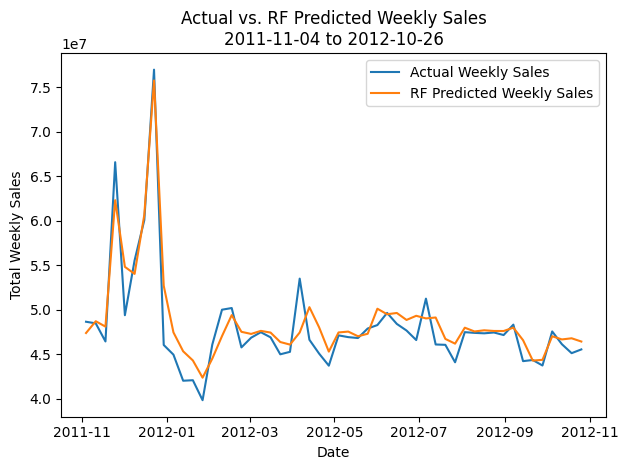

In [321]:

# Select only the join keys + prediction col:
to_join = rf01_forecast[[
    'date','store','dept','rf_01_predicted_weekly_sales'
]]

# Merge into df_viz:
df_viz = df_viz.merge(
    to_join,
    on=['date','store','dept'],
    how='left'
)

# Filter to your date window:
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# Aggregate by date:
daily = df_window.groupby('date').agg({
    'weekly_sales':                  'sum',
    'rf_01_predicted_weekly_sales':  'sum'
}).reset_index()

#  Plot both series:
plt.figure()
plt.plot(daily['date'], daily['weekly_sales'])
plt.plot(daily['date'], daily['rf_01_predicted_weekly_sales'])
plt.legend(['Actual Weekly Sales', 'RF Predicted Weekly Sales'])
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Actual vs. RF Predicted Weekly Sales\n2011-11-04 to 2012-10-26')
plt.tight_layout()
plt.show()


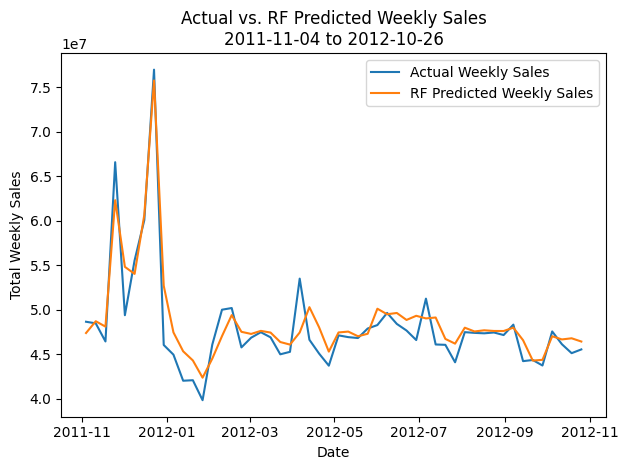

In [322]:

# Select only the join keys + prediction col:
to_join = rf02_forecast[[
    'date','store','dept','rf_02_predicted_weekly_sales'
]]

# Merge into df_viz:
df_viz = df_viz.merge(
    to_join,
    on=['date','store','dept'],
    how='left'
)

# Filter to your date window:
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# Aggregate by date:
daily = df_window.groupby('date').agg({
    'weekly_sales':                  'sum',
    'rf_01_predicted_weekly_sales':  'sum'
}).reset_index()

#  Plot both series:
plt.figure()
plt.plot(daily['date'], daily['weekly_sales'])
plt.plot(daily['date'], daily['rf_01_predicted_weekly_sales'])
plt.legend(['Actual Weekly Sales', 'RF Predicted Weekly Sales'])
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Actual vs. RF Predicted Weekly Sales\n2011-11-04 to 2012-10-26')
plt.tight_layout()
plt.show()


In [323]:


# Select only the join keys + prediction col:
to_join = et01_forecast[[
    'date','store','dept','et01_predicted_weekly_sales'
]]

# Merge into df_viz:
df_viz = df_viz.merge(
    to_join,
    on=['date','store','dept'],
    how='left'
)

# Filter to your date window:
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# Aggregate by date:
daily = df_window.groupby('date').agg({
    'weekly_sales':                  'sum',
    'rf_01_predicted_weekly_sales':  'sum'
}).reset_index()

#  Plot both series:
plt.figure()
plt.plot(daily['date'], daily['weekly_sales'])
plt.plot(daily['date'], daily['rf_01_predicted_weekly_sales'])
plt.legend(['Actual Weekly Sales', 'RF Predicted Weekly Sales'])
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Actual vs. RF Predicted Weekly Sales\n2011-11-04 to 2012-10-26')
plt.tight_layout()
plt.show()


ValueError: You are trying to merge on datetime64[ns] and object columns for key 'date'. If you wish to proceed you should use pd.concat

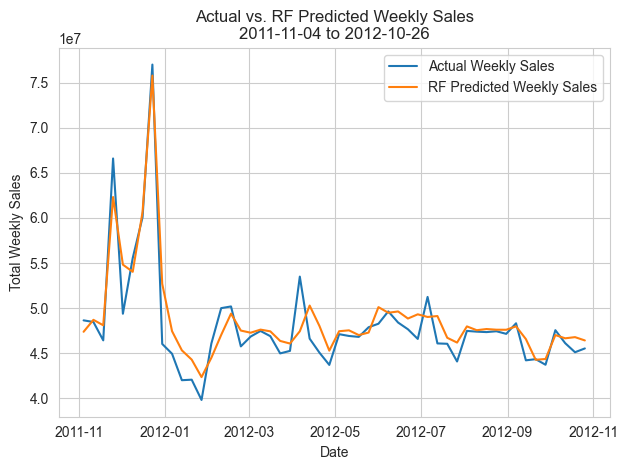

In [ ]:


# Select only the join keys + prediction col:
to_join = ngb01_forecast[[
    'date','store','dept','ngb_predicted_weekly_sales'
]]

# Merge into df_viz:
df_viz = df_viz.merge(
    to_join,
    on=['date','store','dept'],
    how='left'
)

# Filter to your date window:
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# Aggregate by date:
daily = df_window.groupby('date').agg({
    'weekly_sales':                  'sum',
    'rf_01_predicted_weekly_sales':  'sum'
}).reset_index()

#  Plot both series:
plt.figure()
plt.plot(daily['date'], daily['weekly_sales'])
plt.plot(daily['date'], daily['rf_01_predicted_weekly_sales'])
plt.legend(['Actual Weekly Sales', 'RF Predicted Weekly Sales'])
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Actual vs. RF Predicted Weekly Sales\n2011-11-04 to 2012-10-26')
plt.tight_layout()
plt.show()


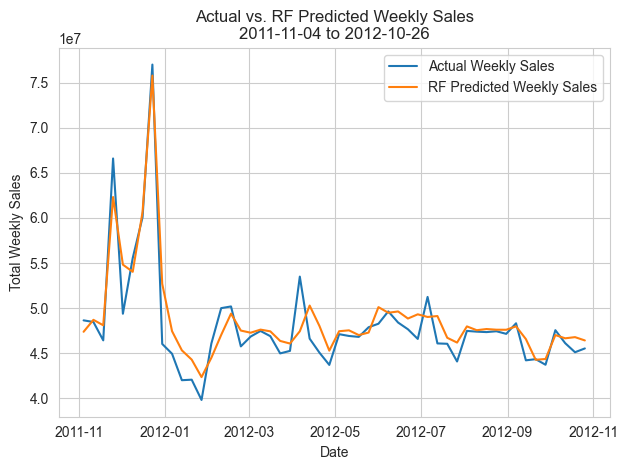

In [ ]:

# Select only the join keys + prediction col:
to_join = catb_forecast01_forecast[[
    'date','store','dept','catboost_predicted_weekly_sales'
]]

# Merge into df_viz:
df_viz = df_viz.merge(
    to_join,
    on=['date','store','dept'],
    how='left'
)

# Filter to your date window:
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# Aggregate by date:
daily = df_window.groupby('date').agg({
    'weekly_sales':                  'sum',
    'rf_01_predicted_weekly_sales':  'sum'
}).reset_index()

#  Plot both series:
plt.figure()
plt.plot(daily['date'], daily['weekly_sales'])
plt.plot(daily['date'], daily['rf_01_predicted_weekly_sales'])
plt.legend(['Actual Weekly Sales', 'RF Predicted Weekly Sales'])
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Actual vs. RF Predicted Weekly Sales\n2011-11-04 to 2012-10-26')
plt.tight_layout()
plt.show()


In [ ]:
# Filter & aggregate into weekly sums
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]
weekly = df_window.groupby('date').agg({
    'weekly_sales':                   'sum',
    'rf_01_predicted_weekly_sales':   'sum',
    'rf_02_predicted_weekly_sales':   'sum',

  
}).reset_index()

# Compute money & pct diffs (and abs error)
models = [
    'rf_01_predicted_weekly_sales',
    'rf_02_predicted_weekly_sales',
]
for m in models:
    weekly[f'diff_{m}']     = weekly[m] - weekly['weekly_sales']
    weekly[f'pct_diff_{m}'] = weekly[f'diff_{m}'] / weekly['weekly_sales'] * 100
    weekly[f'err_{m}']      = weekly[f'diff_{m}'].abs()

# Identify best model each week and its metrics
def best_of_week(row):
    errs = {m: row[f'err_{m}'] for m in models}
    best = min(errs, key=errs.get)
    second = sorted(errs, key=lambda k: errs[k])[1]
    return pd.Series({
        'Best Model': best,
        'Best Error': errs[best],
        'Money Diff': row[f'diff_{best}'],
        'Pct Diff':   row[f'pct_diff_{best}'],
        'Second Error': errs[second],
        'Pct Margin':  (errs[second] - errs[best]) / errs[best] * 100 if errs[best] else np.nan
    })

weekly_best = weekly.join(weekly.apply(best_of_week, axis=1))

# Compute overall avg % difference per model
avg_pct_diff = {
    m: weekly[f'pct_diff_{m}'].abs().mean()
    for m in models
}
avg_pct_df = (
    pd.DataFrame.from_dict(avg_pct_diff, orient='index', columns=['Avg % Diff'])
      .reset_index()
      .rename(columns={'index':'Model'})
)

# Show your results
weekly_best[['date','Best Model','Money Diff','Pct Diff']]



,date,Best Model,Money Diff,Pct Diff
0,2011-11-04,rf_01_predicted_weekly_sales,-1.266603e+06,-2.603203
1,2011-11-11,rf_02_predicted_weekly_sales,-1.703800e+04,-0.035149
2,2011-11-18,rf_02_predicted_weekly_sales,1.476376e+06,3.179174
3,2011-11-25,rf_01_predicted_weekly_sales,-4.271381e+06,-6.414101
4,2011-12-02,rf_02_predicted_weekly_sales,5.085822e+06,10.297154
5,2011-12-09,rf_01_predicted_weekly_sales,-1.524557e+06,-2.743927
6,2011-12-16,rf_02_predicted_weekly_sales,1.760399e+05,0.292981
7,2011-12-23,rf_01_predicted_weekly_sales,-1.216340e+06,-1.579699
8,2011-12-30,rf_01_predicted_weekly_sales,6.661593e+06,14.468369
9,2012-01-06,rf_02_predicted_weekly_sales,2.213340e+06,4.923411


In [ ]:
avg_pct_df

,Model,Avg % Diff
0,rf_01_predicted_weekly_sales,3.368076
1,rf_02_predicted_weekly_sales,3.201366


#### Best Model with lowest MAE

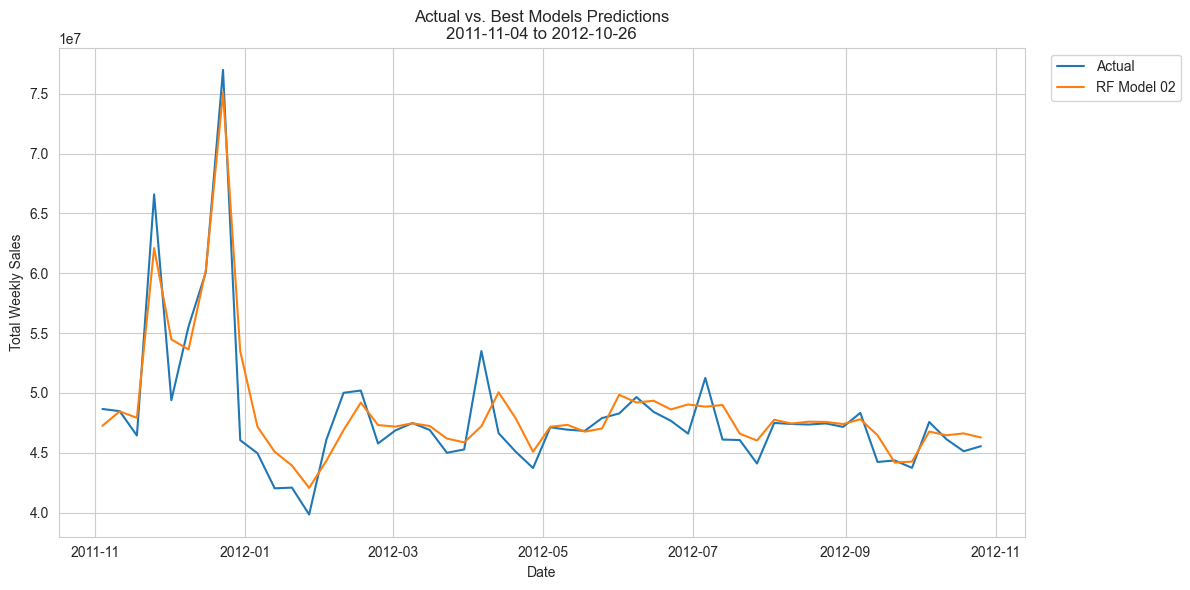

In [ ]:

# Filter to your date window:
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# Aggregate by date (sum across stores/depts) for each series:
daily = df_window.groupby('date').agg({
    'weekly_sales':                   'sum',
    'rf_02_predicted_weekly_sales':   'sum',
}).reset_index()

# Plot all lines:
plt.figure(figsize=(12,6))
plt.plot(daily['date'], daily['weekly_sales'],                   label='Actual')


plt.plot(daily['date'], daily['rf_02_predicted_weekly_sales'],   label='RF Model 02')


plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Actual vs. Best Models Predictions\n2011-11-04 to 2012-10-26')
# If the legend is too crowded, move it outside:
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
df_viz

,store,dept,type,size,weekly_sales,isholiday,holiday_name,holidayimpact,us_tax_return,sp500_weekly_mean_close,...,date_ordinal,date,rf_01_predicted_weekly_sales,rf_02_predicted_weekly_sales,et01_predicted_weekly_sales_x,ngb_predicted_weekly_sales_x,catboost_predicted_weekly_sales_x,et01_predicted_weekly_sales_y,ngb_predicted_weekly_sales_y,catboost_predicted_weekly_sales_y
0,1,1,1,151315,24924.50,0,No Holiday,0.890916,0.0,1083.817969,...,733808,2010-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,151315,46039.49,1,Super Bowl,0.994415,0.0,1069.873999,...,733815,2010-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,1,151315,41595.55,1,"Valentine's Day, Presidents' Day",0.716942,0.0,1102.575012,...,733822,2010-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,1,151315,19403.54,0,No Holiday,0.084079,0.0,1103.055981,...,733829,2010-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,1,151315,21827.90,0,No Holiday,0.188255,0.0,1122.895996,...,733836,2010-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2,118221,508.37,0,No Holiday,0.109084,0.0,1443.923999,...,734774,2012-09-28,627.84530,540.009489,560.716550,576.114964,3118.762244,560.716550,576.114964,3118.762244
421566,45,98,2,118221,628.10,0,No Holiday,0.317329,0.0,1452.712012,...,734781,2012-10-05,760.27136,679.474935,699.567212,767.082299,3087.600630,699.567212,767.082299,3087.600630
421567,45,98,2,118221,1061.02,0,No Holiday,0.575919,0.0,1438.269995,...,734788,2012-10-12,814.88036,770.647316,803.773187,836.218860,3244.470147,803.773187,836.218860,3244.470147
421568,45,98,2,118221,760.01,0,No Holiday,1.037342,0.0,1449.297998,...,734795,2012-10-19,1137.05870,1040.164564,1109.775125,1047.357240,3219.119585,1109.775125,1047.357240,3219.119585


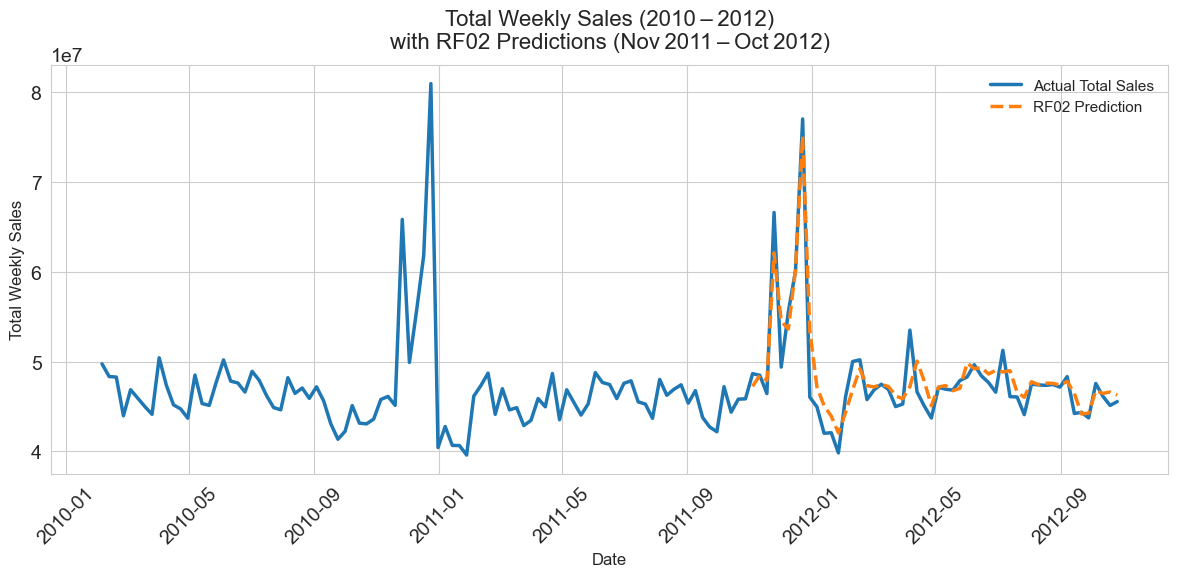

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 0) Prep style
sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])

# 1) Compute actual totals over the full available span
actual_all = (
    df_viz
      .groupby('date', as_index=False)['weekly_sales']
      .sum()
      .rename(columns={'weekly_sales':'actual'})
)

# 2) Compute predicted totals only over the prediction window
mask_pred = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
pred = (
    df_viz.loc[mask_pred]
      .groupby('date', as_index=False)['rf_02_predicted_weekly_sales']
      .sum()
      .rename(columns={'rf_02_predicted_weekly_sales':'pred'})
)

# 3) Plot
fig, ax = plt.subplots(figsize=(12,6))

# Actual line across all dates
ax.plot(
    actual_all['date'], actual_all['actual'],
    color='#1f77b4', linewidth=2.5, label='Actual Total Sales'
)

# Prediction line only where available
ax.plot(
    pred['date'], pred['pred'],
    color='#ff7f0e', linewidth=2.5, linestyle='--', label='RF02 Prediction'
)

# 4) Formatting
ax.set_title('Total Weekly Sales (2010 – 2012)\nwith RF02 Predictions (Nov 2011 – Oct 2012)', fontsize=16, pad=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Weekly Sales', fontsize=12)
ax.legend(frameon=False, fontsize=11)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


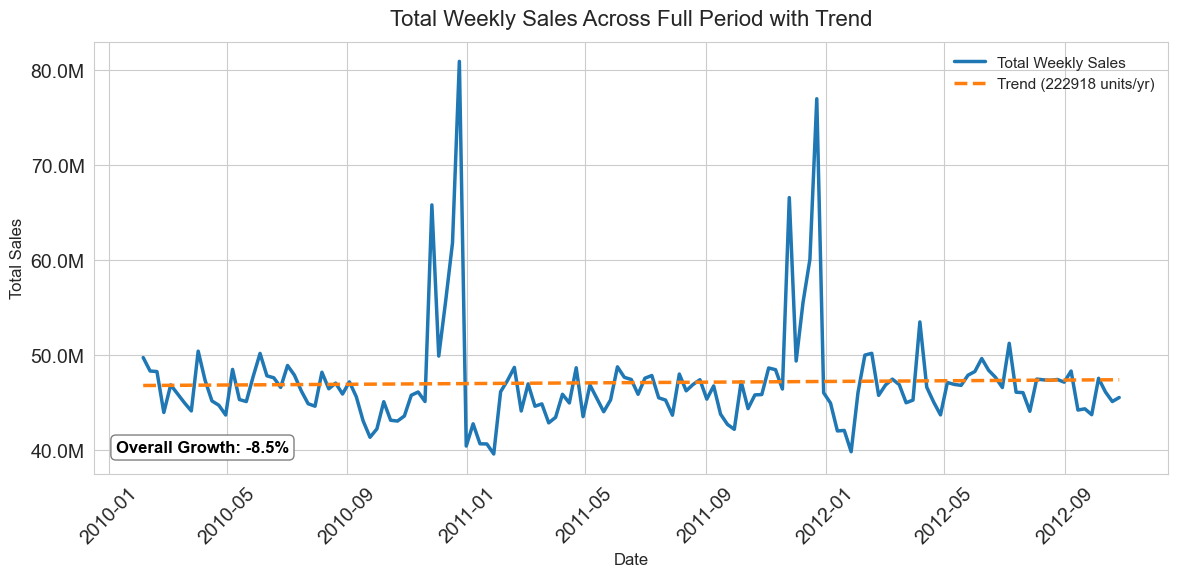

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 0) Prep style & ensure datetime on full dataset
sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])

# 1) Aggregate total weekly sales across both years
total_series = (
    df_viz
      .groupby('date', as_index=False)['weekly_sales']
      .sum()
      .rename(columns={'weekly_sales':'total_sales'})
)

# 2) Compute a simple linear trend on the full span
x_ord = total_series['date'].map(pd.Timestamp.toordinal).values
y = total_series['total_sales'].values
m, b = np.polyfit(x_ord, y, 1)
trend = m * x_ord + b

# 3) Compute overall % growth
pct_growth = (y[-1] - y[0]) / y[0] * 100

# 4) Plot actual + trend
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    total_series['date'], total_series['total_sales'],
    label='Total Weekly Sales', linewidth=2.5, color='#1f77b4'
)
ax.plot(
    total_series['date'], trend,
    label=f'Trend ({m*365:.0f} units/yr)', linestyle='--',
    linewidth=2.5, color='#ff7f0e'
)

# 5) Annotate percentage growth below the lines
ax.text(
    0.02, 0.05,
    f'Overall Growth: {pct_growth:.1f}%',
    transform=ax.transAxes,
    fontsize=12, fontweight='bold', color='black',
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray')
)

# 6) Format y-axis in K/M
def human(x, pos):
    if x >= 1e6: return f'{x/1e6:.1f}M'
    if x >= 1e3: return f'{x/1e3:.1f}K'
    return f'{int(x)}'
ax.yaxis.set_major_formatter(FuncFormatter(human))

# 7) Labels & styling
ax.set_title('Total Weekly Sales Across Full Period with Trend', fontsize=16, pad=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales', fontsize=12)
ax.legend(frameon=False, fontsize=11)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


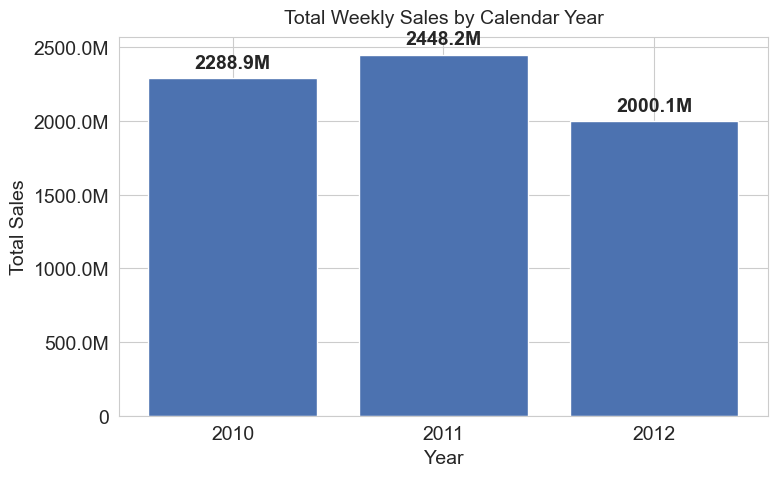

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])

# Sum by calendar year
df_viz['year'] = df_viz['date'].dt.year
yearly = (
    df_viz
      .groupby('year', as_index=False)['weekly_sales']
      .sum()
      .query("year >= 2010 and year <= 2012")  # adjust to your span
      .rename(columns={'weekly_sales':'total_sales'})
)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(yearly['year'].astype(str), yearly['total_sales'], color='#4C72B0')

# Friendly labels
def human(x, pos):
    if x>=1e6: return f'{x/1e6:.1f}M'
    if x>=1e3: return f'{x/1e3:.1f}K'
    return f'{int(x)}'
ax.yaxis.set_major_formatter(FuncFormatter(human))

# Annotate values
for bar in bars:
    y = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, y*1.02, human(y, None),
            ha='center', va='bottom', fontweight='bold')

ax.set_title("Total Weekly Sales by Calendar Year", fontsize=14, pad=10)
ax.set_xlabel("Year")
ax.set_ylabel("Total Sales")
plt.tight_layout()
plt.show()


##### Total Sales Trend Real VS Pred

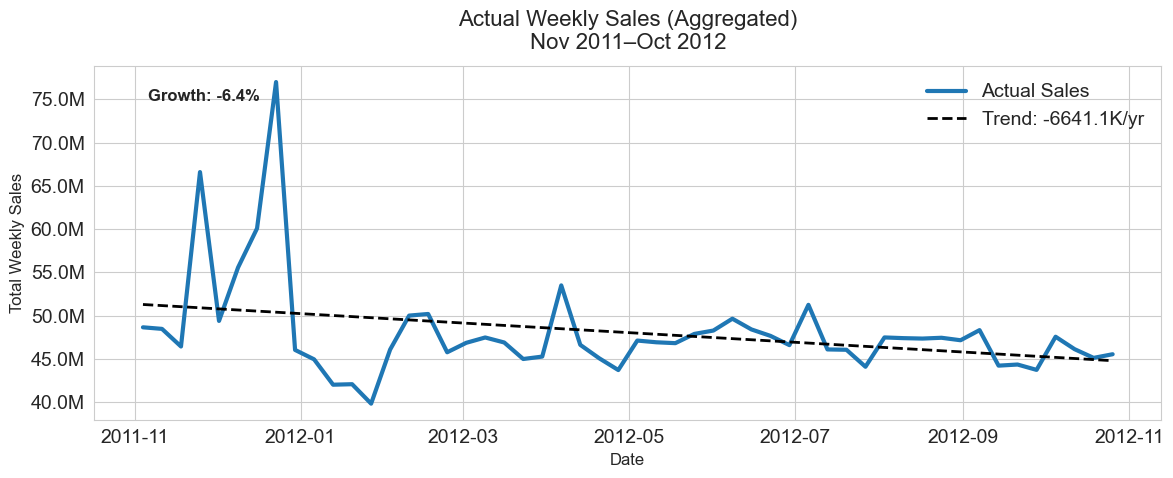

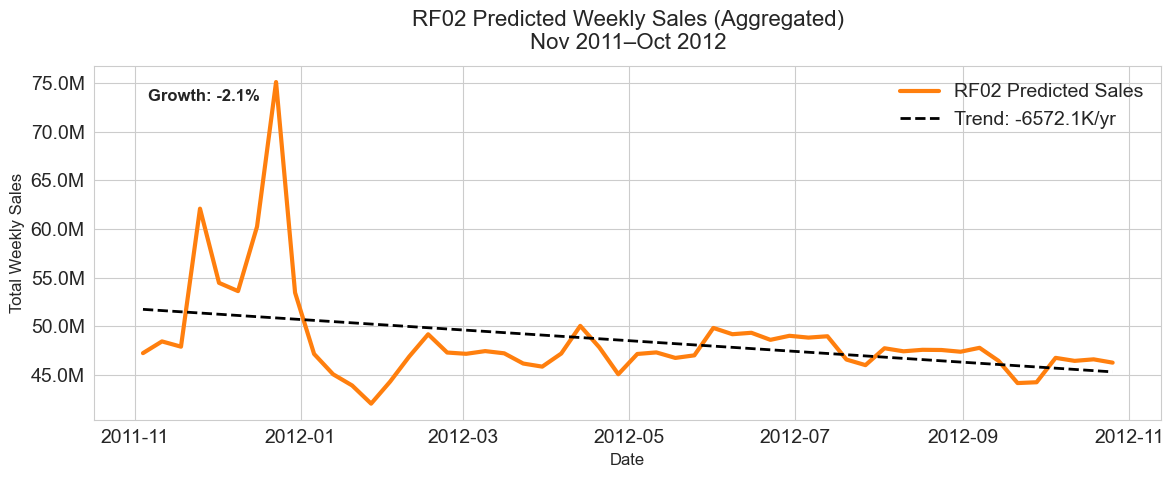

In [ ]:

# 0) Prep style & filter
sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])
mask = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# 1) Aggregate across all stores/depts by date
daily = df_window.groupby('date', as_index=False).agg(
    actual_sales=('weekly_sales', 'sum'),
    pred_sales=('rf_02_predicted_weekly_sales', 'sum')
)

# Formatter for K/M
def human(x, pos):
    if x >= 1e6: return f'{x*1e-6:.1f}M'
    if x >= 1e3: return f'{x*1e-3:.1f}K'
    return f'{int(x)}'

# -------- Plot 1: Actual Sales & Trend --------
fig, ax = plt.subplots(figsize=(12, 5))
# Plot actual sales line
ax.plot(daily['date'], daily['actual_sales'], color='C0', linewidth=3, label='Actual Sales')
# Trend line
x_ord = daily['date'].map(pd.Timestamp.toordinal).values
slope, intercept = np.polyfit(x_ord, daily['actual_sales'].values, 1)
trend = intercept + slope * x_ord
ax.plot(daily['date'], trend, linestyle='--', color='black', linewidth=2, label=f'Trend: {slope*365/1000:.1f}K/yr')
# Growth annotation
start, end = daily['actual_sales'].iloc[[0, -1]]
pct = (end - start) / start * 100
ax.text(0.05, 0.90, f'Growth: {pct:.1f}%', transform=ax.transAxes, fontsize=12, fontweight='bold')
# Styling
ax.set_title('Actual Weekly Sales (Aggregated)\nNov 2011–Oct 2012', fontsize=16, pad=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Weekly Sales', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(human))
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# -------- Plot 2: Predicted Sales & Trend --------
fig, ax = plt.subplots(figsize=(12, 5))
# Plot predicted sales line
ax.plot(daily['date'], daily['pred_sales'], color='C1', linewidth=3, label='RF02 Predicted Sales')
# Trend line
slope_p, intercept_p = np.polyfit(x_ord, daily['pred_sales'].values, 1)
trend_p = intercept_p + slope_p * x_ord
ax.plot(daily['date'], trend_p, linestyle='--', color='black', linewidth=2, label=f'Trend: {slope_p*365/1000:.1f}K/yr')
# Growth annotation
start_p, end_p = daily['pred_sales'].iloc[[0, -1]]
pct_p = (end_p - start_p) / start_p * 100
ax.text(0.05, 0.90, f'Growth: {pct_p:.1f}%', transform=ax.transAxes, fontsize=12, fontweight='bold')
# Styling
ax.set_title('RF02 Predicted Weekly Sales (Aggregated)\nNov 2011–Oct 2012', fontsize=16, pad=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Weekly Sales', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(human))
ax.legend(frameon=False)
plt.tight_layout()
plt.show()


##### Stores Predict Ranked

In [ ]:

# Sum actuals and RF02 predictions by store & week
store_weekly = (
    df_window
    .groupby(['store', 'date'])
    .agg(
        actual_sales   = ('weekly_sales',                 'sum'),
        pred_sales_rf2 = ('rf_02_predicted_weekly_sales',  'sum')
    )
    .reset_index()
)

# Compute % diff for RF02 per store-week
store_weekly['pct_diff_rf2'] = (
    (store_weekly['pred_sales_rf2'] - store_weekly['actual_sales'])
    / store_weekly['actual_sales']
    * 100
)

# Average absolute % diff per store
store_summary = (
    store_weekly
    .groupby('store', as_index=False)['pct_diff_rf2']
    .mean()
    .abs()
    .rename(columns={'pct_diff_rf2':'avg_abs_pct_diff_rf2'})
)

store_summary


,store,avg_abs_pct_diff_rf2
0,1,0.647882
1,2,0.824033
2,3,0.735230
3,4,0.183762
4,5,1.118460
5,6,1.113426
6,7,1.744932
7,8,1.921646
8,9,1.098709
9,10,1.199710


##### Stores % difference above 5%

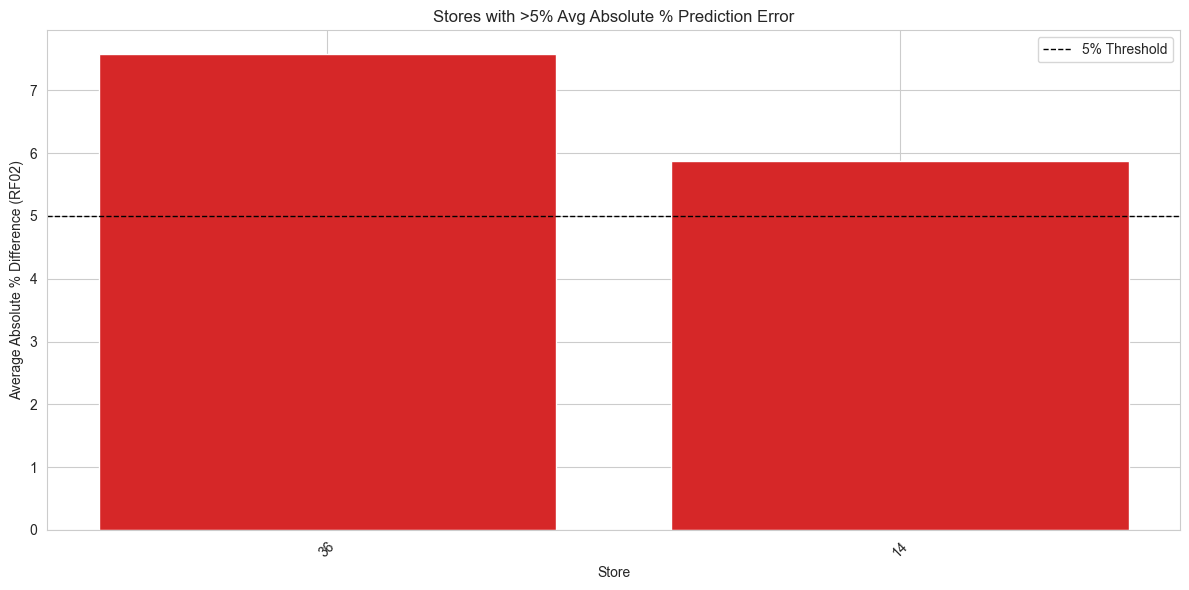

In [ ]:
# Filter stores with avg absolute % diff above 5%
above5 = store_summary[store_summary['avg_abs_pct_diff_rf2'] > 5] \
            .sort_values('avg_abs_pct_diff_rf2', ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(above5['store'].astype(str), above5['avg_abs_pct_diff_rf2'], color='C3')
plt.axhline(5, color='black', linestyle='--', linewidth=1, label='5% Threshold')
plt.xlabel('Store')
plt.ylabel('Average Absolute % Difference (RF02)')
plt.title('Stores with >5% Avg Absolute % Prediction Error')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

# 3) Filter for the two stores
df_sel = df_window[df_window['store'].isin([14, 36])]

# 4) Aggregate weekly sales per store-week
weekly_store = (
    df_sel
    .groupby(['store', 'date'], as_index=False)
    .agg(total_weekly_sales=('weekly_sales', 'sum'))
)

# 5) Pull store size and department count (one value per store)
store_info = (
    df_viz
    .groupby('store', as_index=False)
    .agg(
        size=('size', 'first'),
        num_departments=('dept', 'nunique')
    )
    .loc[lambda df: df['store'].isin([14, 36])]
)

# 6) Merge sales with store metadata
result = weekly_store.merge(store_info, on='store')

# 7) Show the result
result


,store,date,total_weekly_sales,size,num_departments
0,14,2011-11-04,2174056.71,200898,77
1,14,2011-11-11,2081534.65,200898,77
2,14,2011-11-18,1969360.72,200898,77
3,14,2011-11-25,2685351.81,200898,77
4,14,2011-12-02,2143080.57,200898,77
...,...,...,...,...,...
99,36,2012-09-28,270677.98,39910,63
100,36,2012-10-05,277137.86,39910,63
101,36,2012-10-12,300236.85,39910,63
102,36,2012-10-19,287360.05,39910,63


##### Worst Stores VS Actual Price

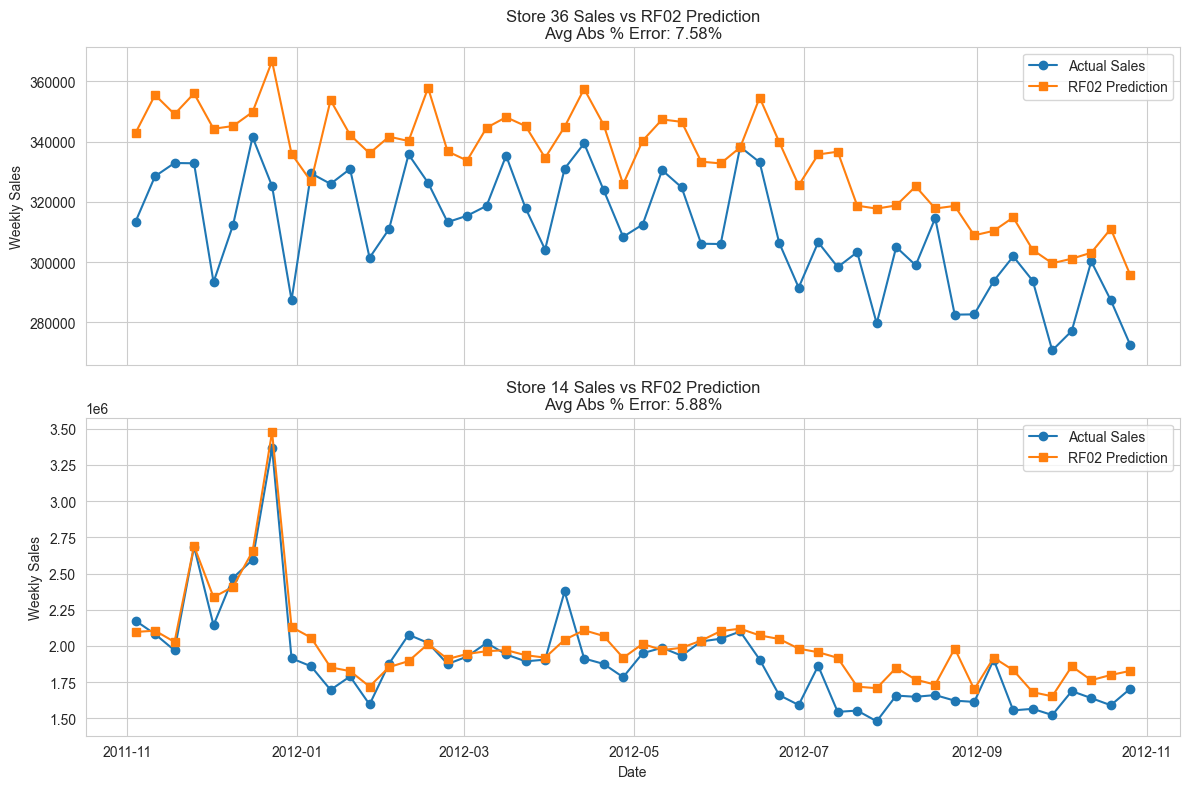

In [ ]:
# 1) Ensure date is datetime and filter to date window
df_viz['date'] = pd.to_datetime(df_viz['date'])
mask = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# 2) Aggregate actual and RF02 predictions by store and date
store_weekly = df_window.groupby(['store', 'date'], as_index=False).agg(
    actual_sales=('weekly_sales', 'sum'),
    pred_sales_rf2=('rf_02_predicted_weekly_sales', 'sum')
)

# 3) Compute percentage difference per store-week
store_weekly['pct_diff_rf2'] = (
    (store_weekly['pred_sales_rf2'] - store_weekly['actual_sales'])
    / store_weekly['actual_sales'] * 100
)

# 4) Compute average absolute percent difference per store
store_summary = (
    store_weekly.groupby('store', as_index=False)['pct_diff_rf2']
    .mean()
    .abs()
    .rename(columns={'pct_diff_rf2': 'avg_abs_pct_diff_rf2'})
)

# 5) Identify two worst stores
worst2 = store_summary.nlargest(2, 'avg_abs_pct_diff_rf2')['store'].tolist()

# 6) Plot for each worst store: actual vs prediction
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for ax, store in zip(axes, worst2):
    df_s = store_weekly[store_weekly['store'] == store]
    ax.plot(df_s['date'], df_s['actual_sales'], label='Actual Sales', marker='o')
    ax.plot(df_s['date'], df_s['pred_sales_rf2'], label='RF02 Prediction', marker='s')
    err = store_summary.loc[store_summary['store']==store, 'avg_abs_pct_diff_rf2'].values[0]
    ax.set_title(f'Store {store} Sales vs RF02 Prediction\nAvg Abs % Error: {err:.2f}%')
    ax.set_ylabel('Weekly Sales')
    ax.legend()

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


##### Best Stores VS Actual Price

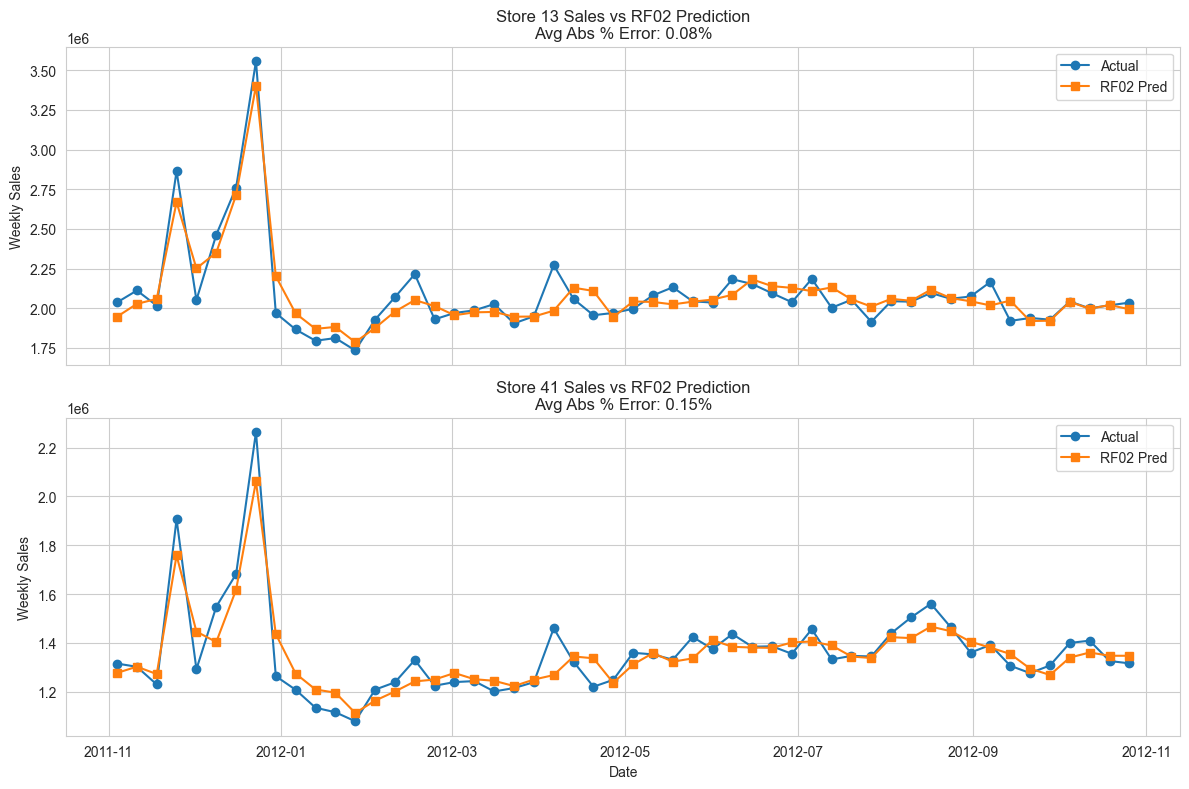

In [ ]:

#  Aggregate actual vs RF02 prediction by store & week
store_weekly = (
    df_window
      .groupby(['store','date'], as_index=False)
      .agg(
          actual_sales=('weekly_sales',               'sum'),
          pred_sales_rf2=('rf_02_predicted_weekly_sales','sum')
      )
)

# Compute weekly % diff
store_weekly['pct_diff_rf2'] = (
    (store_weekly['pred_sales_rf2'] - store_weekly['actual_sales'])
    / store_weekly['actual_sales'] * 100
)

# compute each store’s avg absolute % diff
store_summary = (
    store_weekly
      .groupby('store', as_index=False)['pct_diff_rf2']
      .mean().abs()
      .rename(columns={'pct_diff_rf2':'avg_abs_pct_diff_rf2'})
)

# Identify the two best stores (lowest error)
best2 = store_summary.nsmallest(2, 'avg_abs_pct_diff_rf2')['store'].tolist()

# Plot actual vs RF02 for each best store
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for ax, store in zip(axes, best2):
    df_s = store_weekly[store_weekly['store'] == store]
    ax.plot(df_s['date'], df_s['actual_sales'],    marker='o', label='Actual')
    ax.plot(df_s['date'], df_s['pred_sales_rf2'],  marker='s', label='RF02 Pred')
    err = store_summary.loc[store_summary['store']==store, 'avg_abs_pct_diff_rf2'].item()
    ax.set_title(f'Store {store} Sales vs RF02 Prediction\nAvg Abs % Error: {err:.2f}%')
    ax.set_ylabel('Weekly Sales')
    ax.legend()

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


##### Stores Lowest % difference from Real weekly sales VS Pred weeklysales

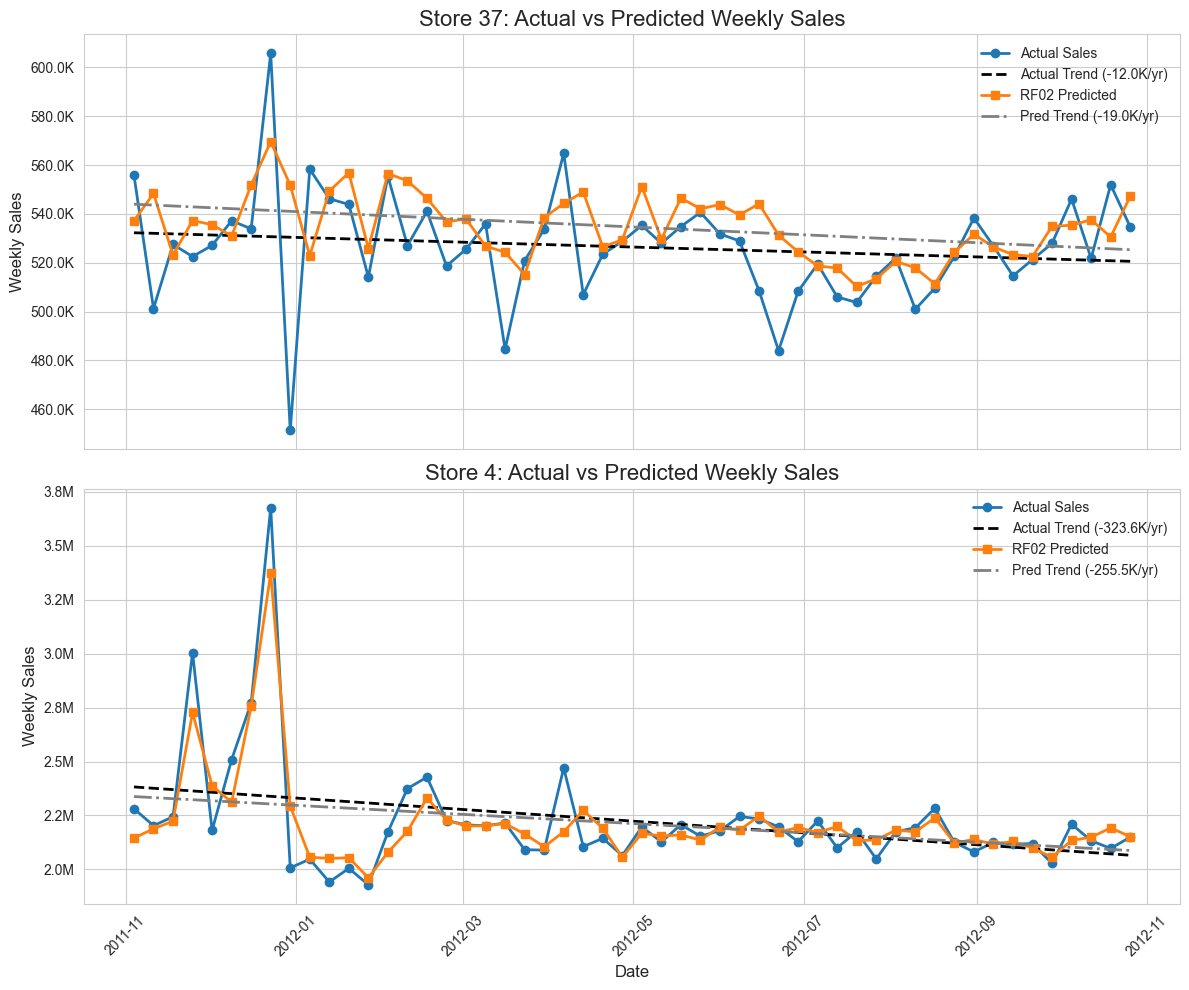

In [ ]:

# 0) Prep & mask
sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])
mask = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# 1) Aggregate actual and RF02 predictions by store & week
store_weekly = df_window.groupby(['store', 'date'], as_index=False).agg(
    actual_sales=('weekly_sales', 'sum'),
    pred_sales=('rf_02_predicted_weekly_sales', 'sum')
)

# 2) Compute average absolute % diff and pick best2
store_weekly['pct_diff'] = (store_weekly['pred_sales'] - store_weekly['actual_sales']).abs() / store_weekly['actual_sales'] * 100
store_summary = store_weekly.groupby('store', as_index=False)['pct_diff'].mean().sort_values('pct_diff')
best2 = store_summary.head(2)['store'].tolist()

# 3) Formatter for K/M
def human(x, pos):
    if x >= 1e6: return f'{x*1e-6:.1f}M'
    if x >= 1e3: return f'{x*1e-3:.1f}K'
    return f'{int(x)}'

# 4) Plot each best store: actual vs predicted with trends
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for ax, store in zip(axes, best2):
    df_s = store_weekly[store_weekly['store'] == store].sort_values('date')
    x_ord = df_s['date'].map(pd.Timestamp.toordinal).values
    
    # Actual sales and trend
    y_actual = df_s['actual_sales'].values
    slope_a, intercept_a = np.polyfit(x_ord, y_actual, 1)
    trend_actual = intercept_a + slope_a * x_ord
    ax.plot(df_s['date'], y_actual, marker='o', linewidth=2, label='Actual Sales', color='C0')
    ax.plot(df_s['date'], trend_actual, linestyle='--', linewidth=2, label=f'Actual Trend ({slope_a*365/1000:.1f}K/yr)', color='black')
    
    # Predicted sales and trend
    y_pred = df_s['pred_sales'].values
    slope_p, intercept_p = np.polyfit(x_ord, y_pred, 1)
    trend_pred = intercept_p + slope_p * x_ord
    ax.plot(df_s['date'], y_pred, marker='s', linewidth=2, label='RF02 Predicted', color='C1')
    ax.plot(df_s['date'], trend_pred, linestyle='-.', linewidth=2, label=f'Pred Trend ({slope_p*365/1000:.1f}K/yr)', color='gray')
    
    # Titles and labels
    ax.set_title(f"Store {store}: Actual vs Predicted Weekly Sales", fontsize=16)
    ax.set_ylabel("Weekly Sales", fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(human))
    ax.legend(frameon=False, fontsize=10)

axes[-1].set_xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Stores Higehst Sales Amount and there Prediction

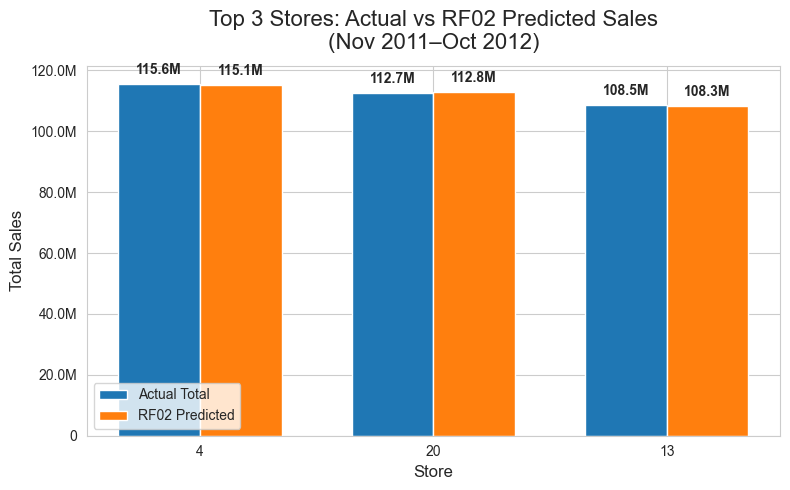

In [ ]:
# -- Data preparation --
# Assumes df_viz is already loaded with 'date', 'store', 'weekly_sales', 'rf_02_predicted_weekly_sales'
df_viz['date'] = pd.to_datetime(df_viz['date'])

# Apply mask
mask = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask]

# Aggregate actual and predicted totals per store
store_totals = (
    df_window
    .groupby('store', as_index=False)
    .agg(
        actual_total=('weekly_sales', 'sum'),
        predicted_total=('rf_02_predicted_weekly_sales', 'sum')
    )
    .sort_values('actual_total', ascending=False)
)

# Select top 3 by actual
top3 = store_totals.head(3)

# -- Plotting --
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

# Create grouped bar positions
indices = range(len(top3))
width = 0.35

# Bars
bars_actual = ax.bar(
    [i - width/2 for i in indices],
    top3['actual_total'],
    width,
    label='Actual Total',
    color='C0'
)
bars_pred = ax.bar(
    [i + width/2 for i in indices],
    top3['predicted_total'],
    width,
    label='RF02 Predicted',
    color='C1'
)

# Formatter
def human(x, pos):
    if x >= 1e6: return f'{x*1e-6:.1f}M'
    if x >= 1e3: return f'{x*1e-3:.1f}K'
    return f'{int(x)}'

ax.yaxis.set_major_formatter(FuncFormatter(human))

# Annotations
for bars in [bars_actual, bars_pred]:
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + max(top3['actual_total'])*0.02,
            human(h, None),
            ha='center', va='bottom',
            fontsize=10, fontweight='bold'
        )

# Labels & title
ax.set_title('Top 3 Stores: Actual vs RF02 Predicted Sales\n(Nov 2011–Oct 2012)', fontsize=16, pad=12)
ax.set_xlabel('Store', fontsize=12)
ax.set_ylabel('Total Sales', fontsize=12)
ax.set_xticks(indices)
ax.set_xticklabels(top3['store'].astype(str))
ax.legend()

plt.tight_layout()
plt.show()


##### Top 3 Stores By Sales & Trend / Growth

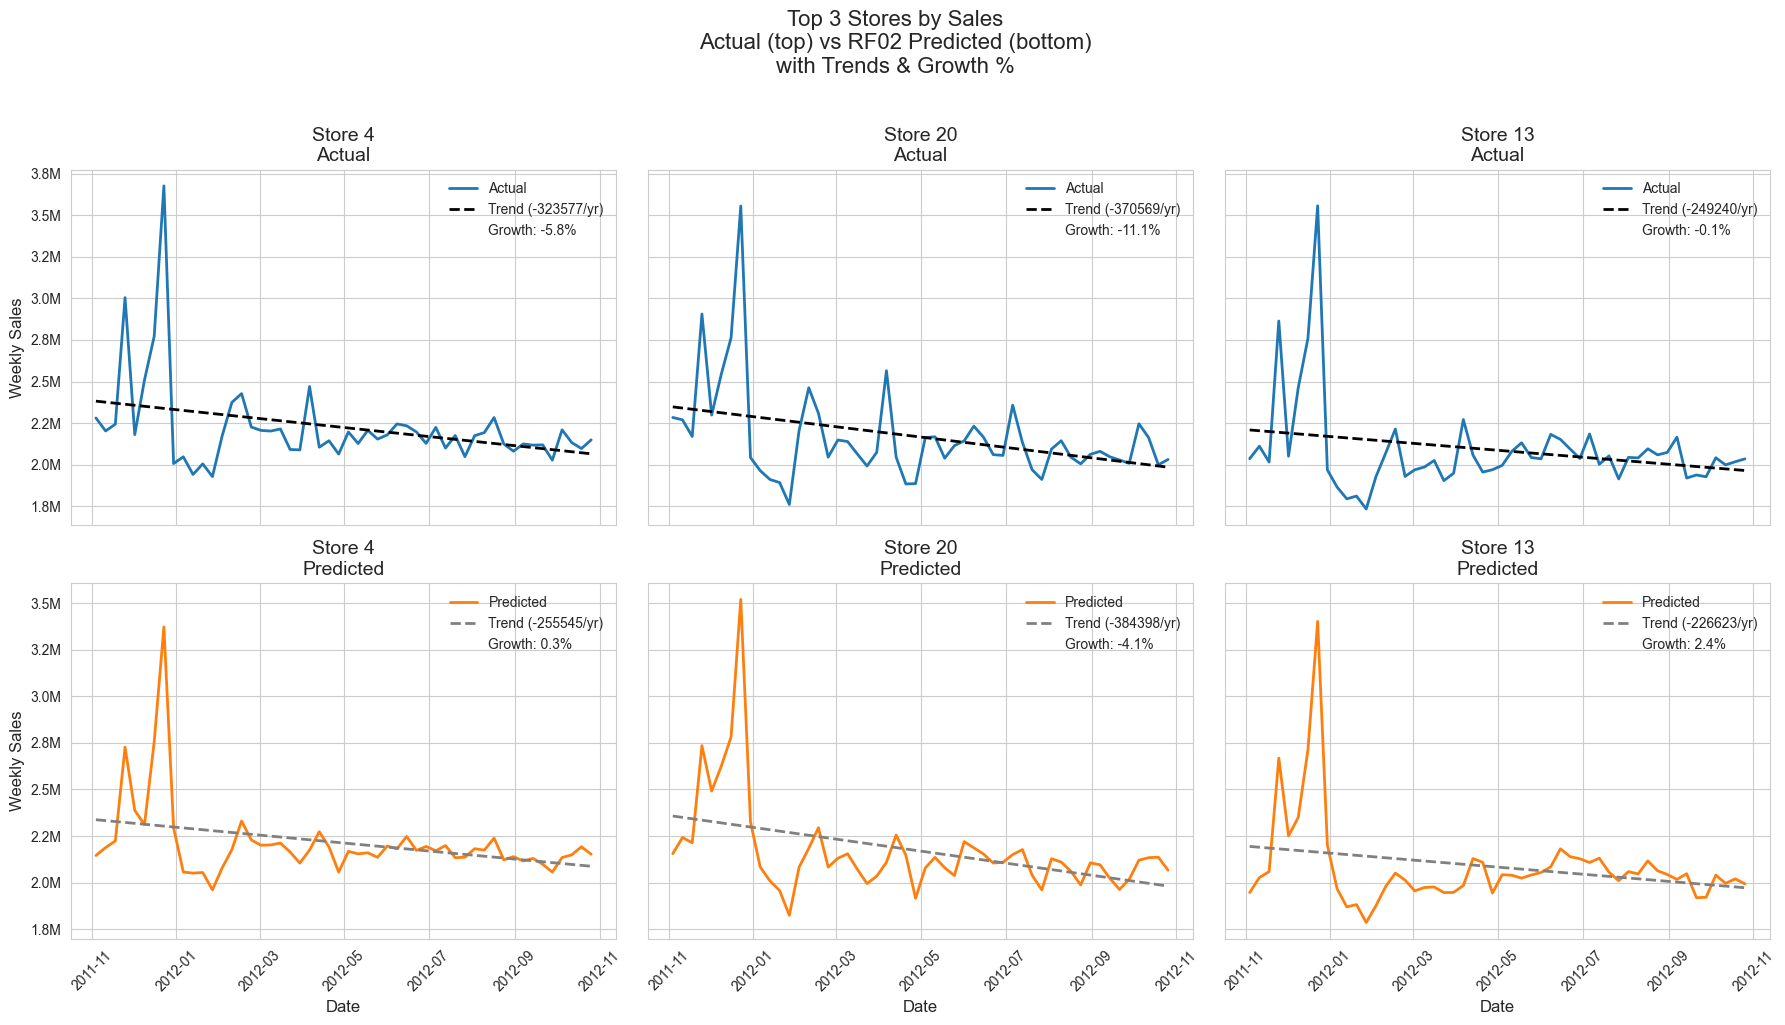

In [ ]:

# 0) Prep & mask
sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask].copy()

# 1) Aggregate actual and predicted by store & week
store_weekly = df_window.groupby(['store','date'], as_index=False).agg(
    actual_sales=('weekly_sales',                 'sum'),
    pred_sales   =('rf_02_predicted_weekly_sales', 'sum')
)

# 2) Identify top-3 stores by total actual sales
totals = (
    store_weekly
      .groupby('store', as_index=False)['actual_sales']
      .sum()
      .rename(columns={'actual_sales':'total_sales'})
      .sort_values('total_sales', ascending=False)
)
top3 = totals.head(3)['store'].tolist()

# 3) Formatter for thousands/millions
def human(x, pos):
    if x >= 1e6: return f'{x/1e6:.1f}M'
    if x >= 1e3: return f'{x/1e3:.1f}K'
    return f'{int(x)}'

# 4) Draw 2×3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex='col', sharey='row')

for col, store in enumerate(top3):
    df_s  = store_weekly[store_weekly['store']==store].sort_values('date')
    dates = df_s['date']
    x_ord = dates.map(pd.Timestamp.toordinal).values

    # --- Actual (top row) ---
    ax = axes[0, col]
    y = df_s['actual_sales'].values
    ax.plot(dates, y, '-', color='C0', linewidth=2, label='Actual')
    m, b = np.polyfit(x_ord, y, 1)
    ax.plot(dates, b + m*x_ord, '--', color='black', linewidth=2,
            label=f'Trend ({m*365:.0f}/yr)')
    # invisible handle for growth
    pct = (y[-1] - y[0]) / y[0] * 100
    ax.plot([], [], ' ', label=f'Growth: {pct:.1f}%')

    ax.set_title(f"Store {store}\nActual", fontsize=14)
    if col==0:
        ax.set_ylabel("Weekly Sales", fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(human))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.legend(frameon=False, fontsize=10)

    # --- Predicted (bottom row) ---
    ax = axes[1, col]
    y2 = df_s['pred_sales'].values
    ax.plot(dates, y2, '-', color='C1', linewidth=2, label='Predicted')
    m2, b2 = np.polyfit(x_ord, y2, 1)
    ax.plot(dates, b2 + m2*x_ord, '--', color='gray', linewidth=2,
            label=f'Trend ({m2*365:.0f}/yr)')
    pct2 = (y2[-1] - y2[0]) / y2[0] * 100 if y2[0] else 0
    ax.plot([], [], ' ', label=f'Growth: {pct2:.1f}%')

    ax.set_title(f"Store {store}\nPredicted", fontsize=14)
    if col==0:
        ax.set_ylabel("Weekly Sales", fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(human))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.legend(frameon=False, fontsize=10)

# Common X label
for ax in axes[1]:
    ax.set_xlabel("Date", fontsize=12)

plt.suptitle(
    "Top 3 Stores by Sales\nActual (top) vs RF02 Predicted (bottom)\nwith Trends & Growth %",
    fontsize=16, y=1.02
)
plt.tight_layout()
plt.show()


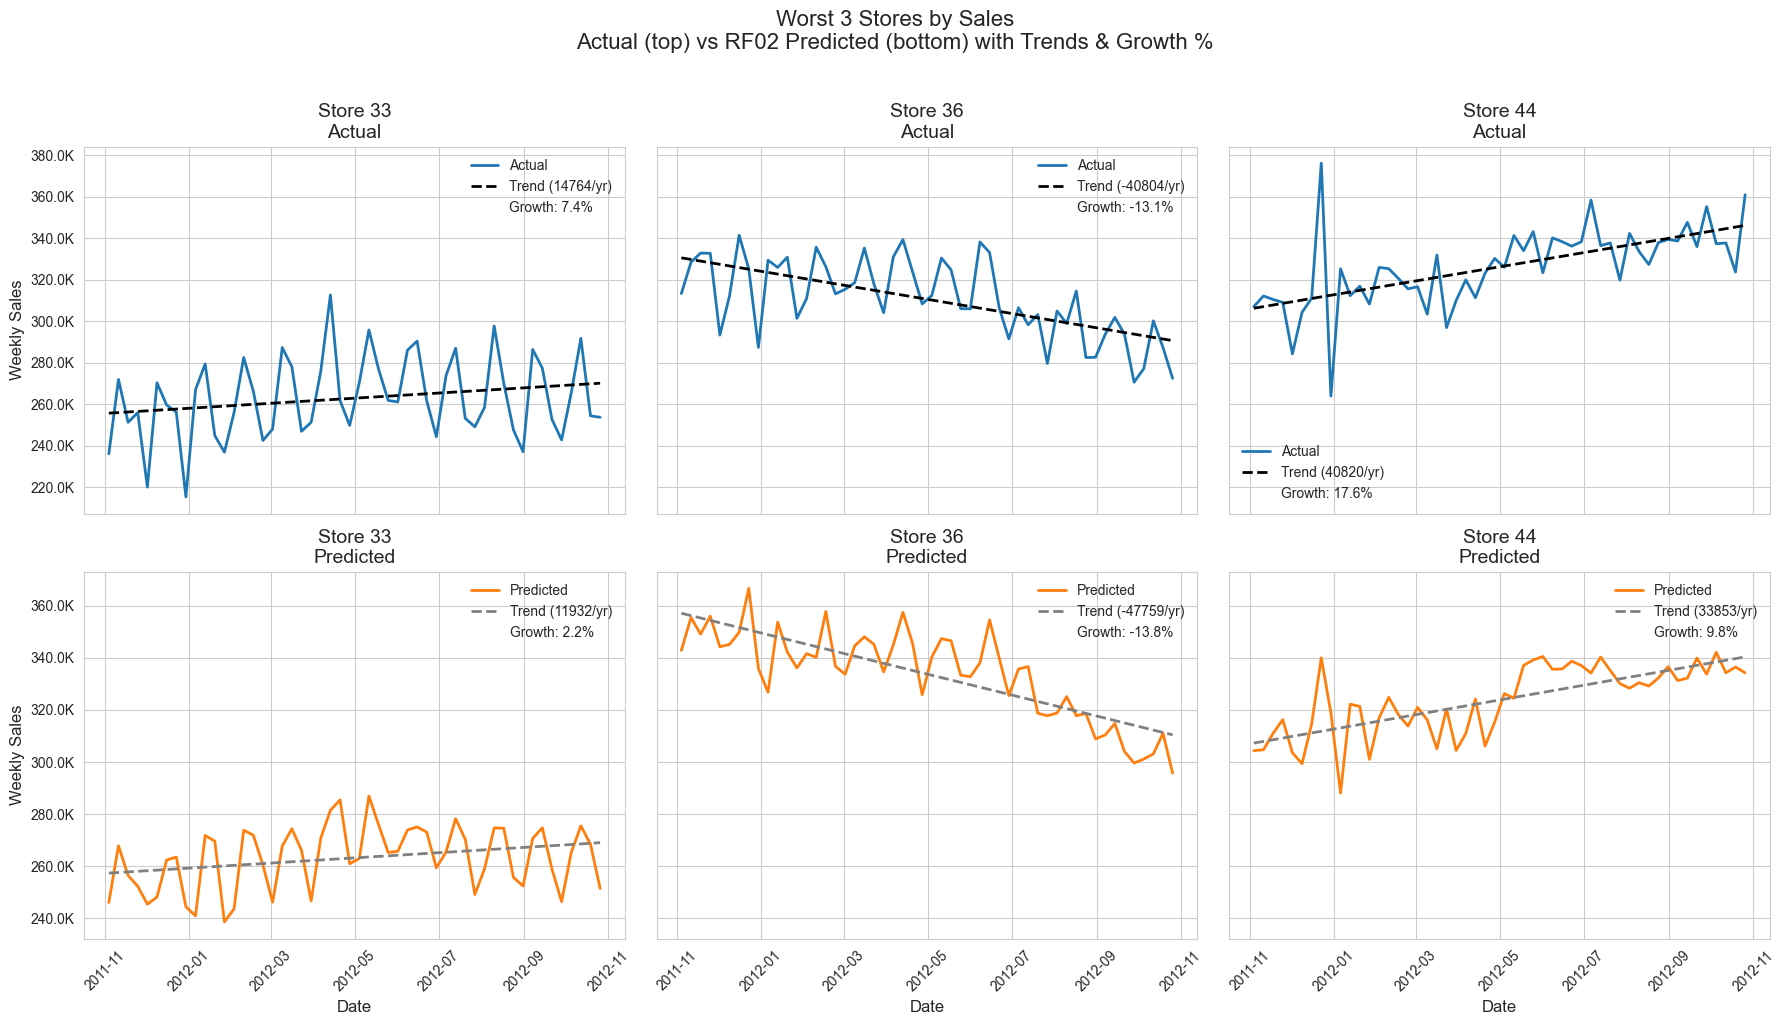

In [ ]:
# 0) Prep & mask
sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask].copy()

# 1) Aggregate actual and predicted by store & week
store_weekly = df_window.groupby(['store','date'], as_index=False).agg(
    actual_sales=('weekly_sales',                 'sum'),
    pred_sales   =('rf_02_predicted_weekly_sales', 'sum')
)

# 2) Identify worst-3 stores by total actual sales (bottom 3)
totals = (
    store_weekly
      .groupby('store', as_index=False)['actual_sales']
      .sum()
      .rename(columns={'actual_sales':'total_sales'})
      .sort_values('total_sales', ascending=True)
)
worst3 = totals.head(3)['store'].tolist()

# 3) Formatter for thousands/millions
def human(x, pos):
    if x >= 1e6: return f'{x/1e6:.1f}M'
    if x >= 1e3: return f'{x/1e3:.1f}K'
    return f'{int(x)}'

# 4) Draw 2×3 grid for worst 3 stores
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex='col', sharey='row')

for col, store in enumerate(worst3):
    df_s  = store_weekly[store_weekly['store']==store].sort_values('date')
    dates = df_s['date']
    x_ord = dates.map(pd.Timestamp.toordinal).values

    # --- Actual (top row) ---
    ax = axes[0, col]
    y = df_s['actual_sales'].values
    ax.plot(dates, y, '-', color='C0', linewidth=2, label='Actual')
    m, b = np.polyfit(x_ord, y, 1)
    ax.plot(dates, b + m*x_ord, '--', color='black', linewidth=2,
            label=f'Trend ({m*365:.0f}/yr)')
    pct = (y[-1] - y[0]) / y[0] * 100
    ax.plot([], [], ' ', label=f'Growth: {pct:.1f}%')

    ax.set_title(f"Store {store}\nActual", fontsize=14)
    if col==0:
        ax.set_ylabel("Weekly Sales", fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(human))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.legend(frameon=False, fontsize=10)

    # --- Predicted (bottom row) ---
    ax = axes[1, col]
    y2 = df_s['pred_sales'].values
    ax.plot(dates, y2, '-', color='C1', linewidth=2, label='Predicted')
    m2, b2 = np.polyfit(x_ord, y2, 1)
    ax.plot(dates, b2 + m2*x_ord, '--', color='gray', linewidth=2,
            label=f'Trend ({m2*365:.0f}/yr)')
    pct2 = (y2[-1] - y2[0]) / y2[0] * 100 if y2[0] else 0
    ax.plot([], [], ' ', label=f'Growth: {pct2:.1f}%')

    ax.set_title(f"Store {store}\nPredicted", fontsize=14)
    if col==0:
        ax.set_ylabel("Weekly Sales", fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(human))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.legend(frameon=False, fontsize=10)

# Common X label
for ax in axes[1]:
    ax.set_xlabel("Date", fontsize=12)

plt.suptitle(
    "Worst 3 Stores by Sales\nActual (top) vs RF02 Predicted (bottom) with Trends & Growth %",
    fontsize=16, y=1.02
)
plt.tight_layout()
plt.show()


##### Top 3 Stores Improvement By Total Sales & PRed 

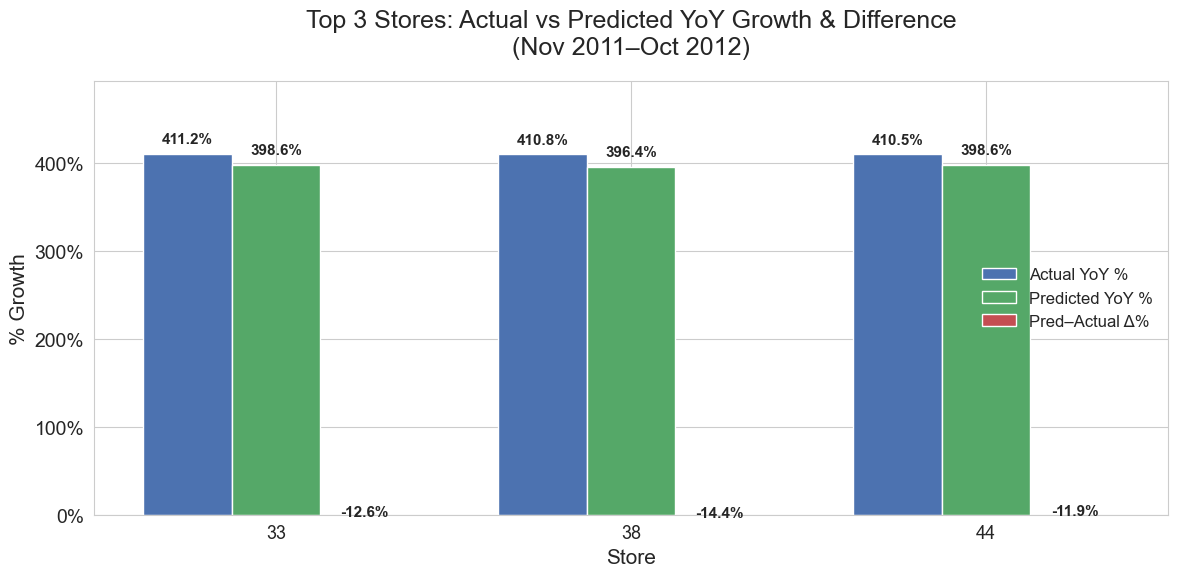

In [ ]:

# 0) Prep & mask
sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask].copy()

# 1) Compute total sales per store-year
df_window['year'] = df_window['date'].dt.year
totals = (
    df_window
      .groupby(['store','year'], as_index=False)
      .agg(
          tot_actual   = ('weekly_sales',                  'sum'),
          tot_predicted= ('rf_02_predicted_weekly_sales', 'sum')
      )
)

# 2) Pivot to have separate columns
pivot = totals.pivot(index='store', columns='year', values=['tot_actual','tot_predicted'])
pivot.columns = ['actual_2011','actual_2012','pred_2011','pred_2012']

# 3) Compute YoY % growth on totals
pivot['actual_growth_pct']    = (pivot['actual_2012']    - pivot['actual_2011'])    / pivot['actual_2011']    * 100
pivot['predicted_growth_pct'] = (pivot['pred_2012'] - pivot['pred_2011']) / pivot['pred_2011'] * 100

# 4) Pick top 3 by actual growth
best3 = pivot.nlargest(3, 'actual_growth_pct')[[
    'actual_growth_pct','predicted_growth_pct'
]].copy()

# 5) Compute difference
best3['diff_pct'] = best3['predicted_growth_pct'] - best3['actual_growth_pct']

# 6) Plot 3‐bar grouped chart
stores = best3.index.astype(str)
x = np.arange(len(stores))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width,      best3['actual_growth_pct'],    width, label='Actual YoY %',    color='#4C72B0')
bars2 = ax.bar(x,              best3['predicted_growth_pct'], width, label='Predicted YoY %', color='#55A868')
bars3 = ax.bar(x + width,      best3['diff_pct'],             width, label='Pred–Actual Δ%',  color='#C44E52')

# Add some headroom
ymax = max(best3.max())
ax.set_ylim(0, ymax * 1.2)

# Annotate each bar
for bar in [*bars1, *bars2, *bars3]:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + ymax*0.02,
        f'{h:.1f}%',
        ha='center', va='bottom',
        fontsize=11, fontweight='bold'
    )

# Formatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f'{v:.0f}%'))

# Labels & title
ax.set_xticks(x)
ax.set_xticklabels(stores, fontsize=13)
ax.set_xlabel('Store', fontsize=15)
ax.set_ylabel('% Growth', fontsize=15)
ax.set_title('Top 3 Stores: Actual vs Predicted YoY Growth & Difference\n(Nov 2011–Oct 2012)', fontsize=18, pad=20)
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


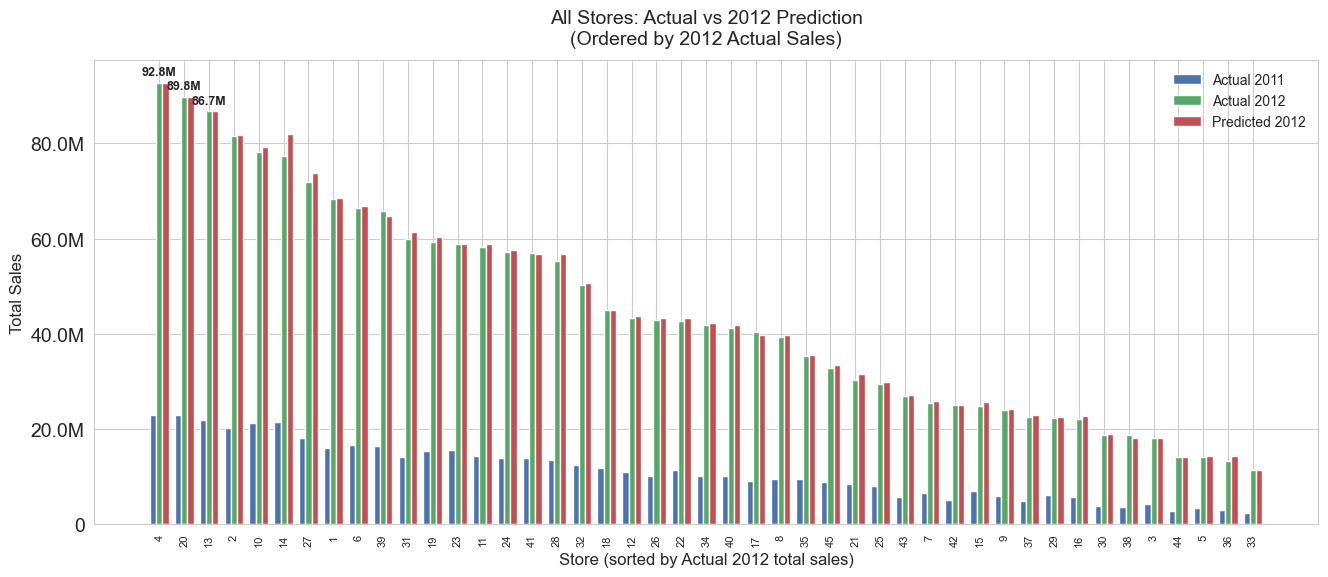

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 0) Prep & mask
sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])
mask       = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window  = df_viz.loc[mask].copy()

# 1) Compute actual totals per store‐year
df_window['year'] = df_window['date'].dt.year
actual_totals = (
    df_window
      .groupby(['store','year'], as_index=False)['weekly_sales']
      .sum()
      .rename(columns={'weekly_sales':'actual_total'})
)

# 2) Compute predicted totals per store‐year
pred_totals = (
    df_window
      .groupby(['store','year'], as_index=False)['rf_02_predicted_weekly_sales']
      .sum()
      .rename(columns={'rf_02_predicted_weekly_sales':'pred_total'})
)

# 3) Merge and pivot
all_totals = actual_totals.merge(pred_totals, on=['store','year'], how='left')
pivot = all_totals.pivot(index='store', columns='year', values=['actual_total','pred_total'])
pivot.columns = ['act_2011','act_2012','pred_2011','pred_2012']
pivot = pivot.fillna(0)

# 4) Sort stores by 2012 actual total sales descending
pivot = pivot.sort_values('act_2012', ascending=False)

# 5) Plot
stores = pivot.index.astype(str)
n = len(stores)
x = np.arange(n)
width = 0.25

fig, ax = plt.subplots(figsize=(max(12, n*0.3), 6))

bars1 = ax.bar(x - width,   pivot['act_2011'],  width, label='Actual 2011',  color='#4C72B0')
bars2 = ax.bar(x,           pivot['act_2012'],  width, label='Actual 2012',  color='#55A868')
bars3 = ax.bar(x + width,   pivot['pred_2012'], width, label='Predicted 2012', color='#C44E52')

# Friendly y-axis formatter
def human(x, pos):
    if x >= 1e6: return f'{x/1e6:.1f}M'
    if x >= 1e3: return f'{x/1e3:.1f}K'
    return f'{int(x)}'
ax.yaxis.set_major_formatter(FuncFormatter(human))

# Annotate just the top‐3 actual-2012 bars for clarity
for bar in bars2[:3]:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + pivot['act_2012'].max()*0.01,
        human(h, None),
        ha='center', va='bottom',
        fontsize=9, fontweight='bold'
    )

# Labels & styling
ax.set_xticks(x)
ax.set_xticklabels(stores, rotation=90, fontsize=8)
ax.set_xlabel('Store (sorted by Actual 2012 total sales)', fontsize=12)
ax.set_ylabel('Total Sales', fontsize=12)
ax.set_title('All Stores: Actual vs 2012 Prediction\n(Ordered by 2012 Actual Sales)', fontsize=14, pad=12)
ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.show()


#### Bottom 3 Growth Improvement Stores & Pred

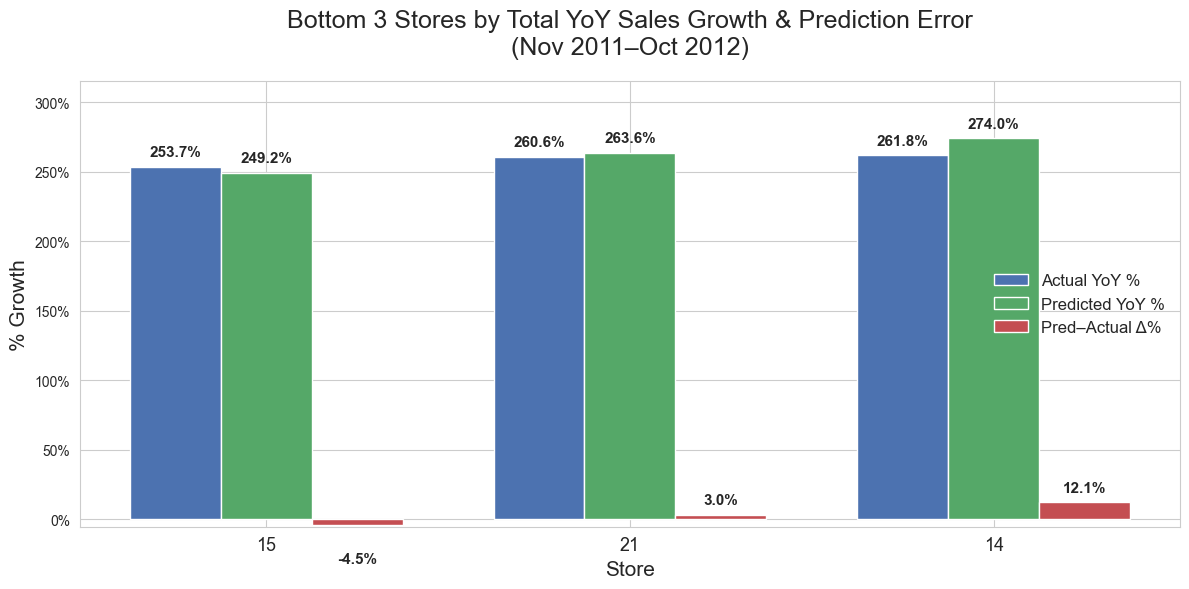

In [ ]:
# 0) Prep & mask
sns.set_style("whitegrid")
df_viz['date'] = pd.to_datetime(df_viz['date'])
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask].copy()

# 1) Compute total sales per store-year
df_window['year'] = df_window['date'].dt.year
totals = (
    df_window
      .groupby(['store','year'], as_index=False)
      .agg(
          tot_actual   = ('weekly_sales',                  'sum'),
          tot_predicted= ('rf_02_predicted_weekly_sales', 'sum')
      )
)

# 2) Pivot to have separate columns
pivot = totals.pivot(index='store', columns='year', values=['tot_actual','tot_predicted'])
pivot.columns = ['actual_2011','actual_2012','pred_2011','pred_2012']

# 3) Compute YoY % growth on totals
pivot['actual_growth_pct']    = (pivot['actual_2012']    - pivot['actual_2011'])    / pivot['actual_2011']    * 100
pivot['predicted_growth_pct'] = (pivot['pred_2012'] - pivot['pred_2011']) / pivot['pred_2011'] * 100

# 4) Pick worst 3 by actual total‐sales growth
worst3 = pivot.nsmallest(3, 'actual_growth_pct')[[
    'actual_growth_pct','predicted_growth_pct'
]].copy()

# 5) Compute difference Pred–Actual
worst3['diff_pct'] = worst3['predicted_growth_pct'] - worst3['actual_growth_pct']

# 6) Plot grouped‐bar chart for the three “worst” stores
stores = worst3.index.astype(str)
x = np.arange(len(stores))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width,      worst3['actual_growth_pct'],    width, label='Actual YoY %',    color='#4C72B0')
bars2 = ax.bar(x,              worst3['predicted_growth_pct'], width, label='Predicted YoY %', color='#55A868')
bars3 = ax.bar(x + width,      worst3['diff_pct'],             width, label='Pred–Actual Δ%',  color='#C44E52')

# Add headroom
ymax = worst3[['actual_growth_pct','predicted_growth_pct','diff_pct']].values.max()
ax.set_ylim(min(worst3['diff_pct']) * 1.2, ymax * 1.15)

# Annotate each bar
for bar in [*bars1, *bars2, *bars3]:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + ymax * 0.02 if h >= 0 else h - ymax * 0.07,
        f'{h:.1f}%',
        ha='center', va='bottom' if h>=0 else 'top',
        fontsize=11, fontweight='bold'
    )

# Formatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f'{v:.0f}%'))

# Labels & title
ax.set_xticks(x)
ax.set_xticklabels(stores, fontsize=13)
ax.set_xlabel('Store', fontsize=15)
ax.set_ylabel('% Growth', fontsize=15)
ax.set_title('Bottom 3 Stores by Total YoY Sales Growth & Prediction Error\n(Nov 2011–Oct 2012)', fontsize=18, pad=20)
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


##### All Stores Growth by total sales & pred

C:\Users\estif\AppData\Local\Temp\ipykernel_28792\839740763.py:72: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\estif\Desktop\DataAnalyst\_DataCourse_IronHack\Quests\ml_walmart_price\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


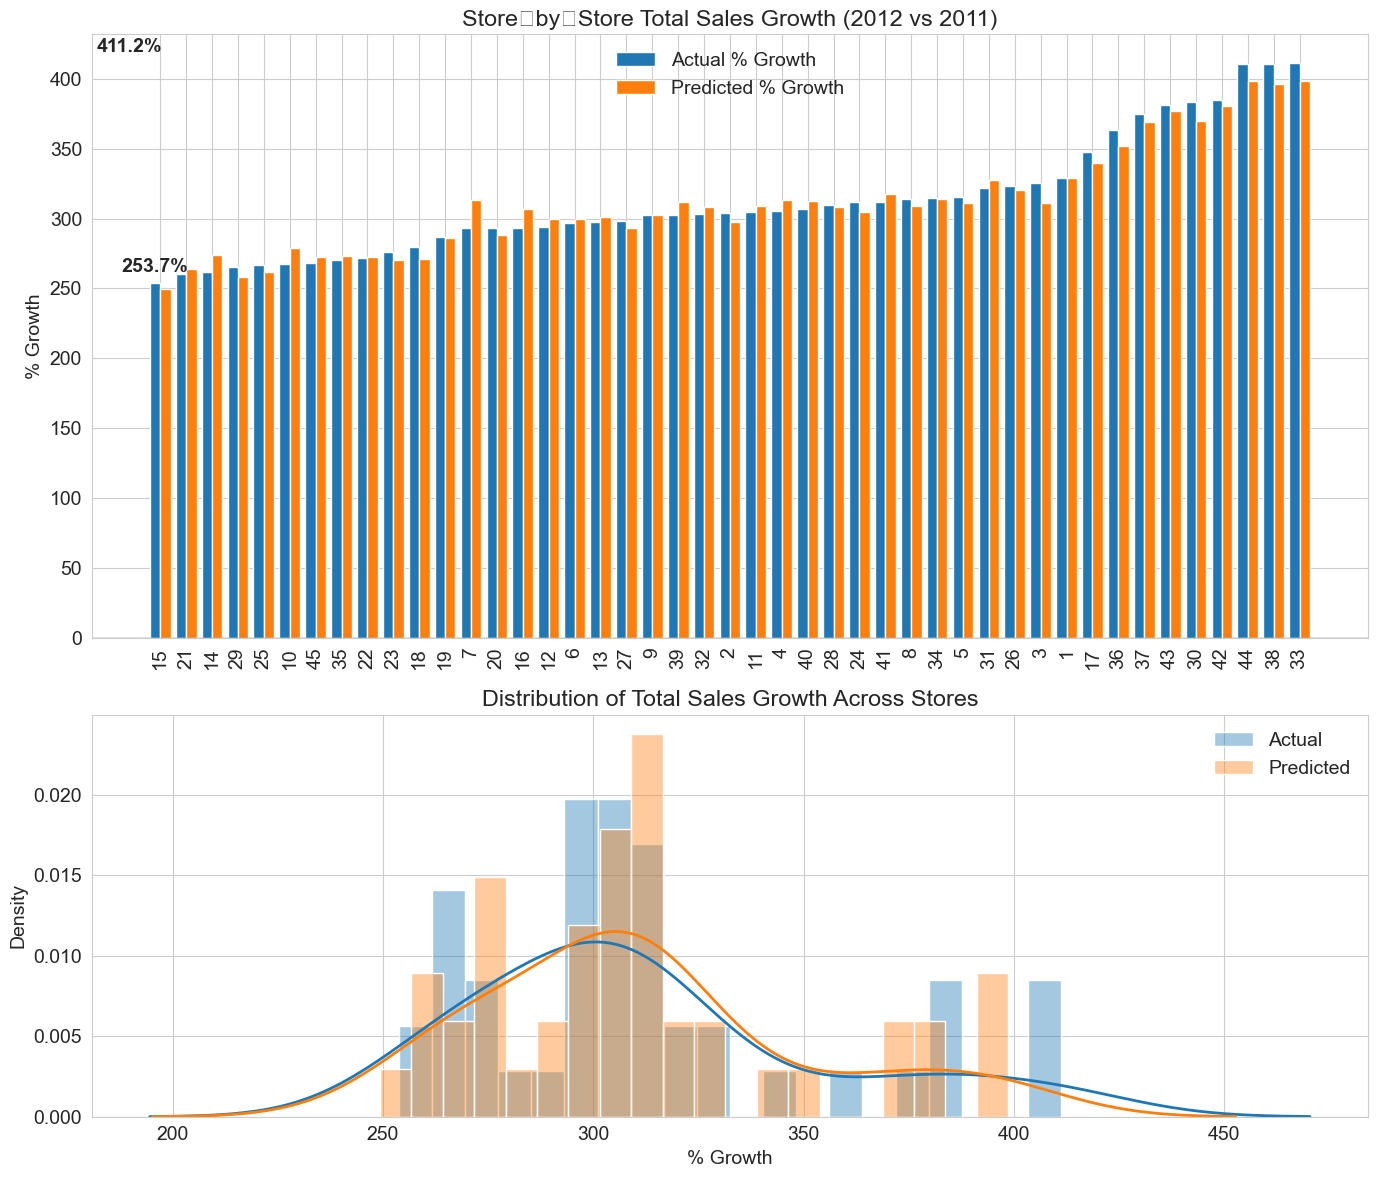

In [ ]:

# 0) Prep & mask
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14})
df_viz['date'] = pd.to_datetime(df_viz['date'])
mask      = (df_viz['date'] >= '2011-11-04') & (df_viz['date'] <= '2012-10-26')
df_window = df_viz.loc[mask].copy()

# 1) Total sales per store-year
df_window['year'] = df_window['date'].dt.year
totals = (
    df_window
      .groupby(['store','year'], as_index=False)
      .agg(
        actual_sum=('weekly_sales','sum'),
        pred_sum  =('rf_02_predicted_weekly_sales','sum')
      )
)

# 2) Pivot to wide form
pivot = totals.pivot(index='store', columns='year', values=['actual_sum','pred_sum'])
pivot.columns = ['act_2011','act_2012','pred_2011','pred_2012']

# 3) Compute % growth
pivot['act_growth']  = (pivot['act_2012']  - pivot['act_2011'])  / pivot['act_2011']  *100
pivot['pred_growth']= (pivot['pred_2012'] - pivot['pred_2011']) / pivot['pred_2011']*100

# 4) Sort by actual growth
growth_act  = pivot['act_growth'].sort_values()
growth_pred = pivot['pred_growth'].reindex(growth_act.index)  # align

# 5) Plot
fig, (ax_bar, ax_hist) = plt.subplots(2,1, figsize=(14,12), gridspec_kw={'height_ratios':[3,2]})

# --- Bar chart of every store: actual vs predicted ---
x = np.arange(len(growth_act))
width = 0.4

bars1 = ax_bar.bar(x - width/2, growth_act, width, label='Actual % Growth', color='#1f77b4')
bars2 = ax_bar.bar(x + width/2, growth_pred, width, label='Predicted % Growth', color='#ff7f0e')

ax_bar.axhline(0, color='gray', linewidth=1)
ax_bar.set_title("Store‐by‐Store Total Sales Growth (2012 vs 2011)")
ax_bar.set_ylabel("% Growth")
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(growth_act.index.astype(str), rotation=90)
ax_bar.legend(frameon=False)

# annotate only best and worst actual
for idx in [0, -1]:
    yv = growth_act.iloc[idx]
    ax_bar.text(idx - width/2, yv + np.sign(yv)*5, f'{yv:.1f}%', 
                ha='center', va='bottom' if yv>0 else 'top', fontweight='bold')

# --- Histogram/KDE of actual vs predicted distributions ---
sns.histplot(growth_act, bins=20, stat='density', color='#1f77b4', alpha=0.4, label='Actual', ax=ax_hist)
sns.histplot(growth_pred, bins=20, stat='density', color='#ff7f0e', alpha=0.4, label='Predicted', ax=ax_hist)

# overlay KDEs
sns.kdeplot(growth_act, color='#1f77b4', linewidth=2, ax=ax_hist)
sns.kdeplot(growth_pred, color='#ff7f0e', linewidth=2, ax=ax_hist)

ax_hist.set_title("Distribution of Total Sales Growth Across Stores")
ax_hist.set_xlabel("% Growth")
ax_hist.set_ylabel("Density")
ax_hist.legend(frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
df_viz.to_csv('df_wm_store_sales_predictions.csv', index=False)

In [327]:
df_viz["type"].value_counts()


type
1    215478
2    163495
3     42597
Name: count, dtype: int64

In [328]:
df_neg_sales = (
    df_viz
    .loc[df_viz["weekly_sales"] < 0, ["date", "store", "dept", "weekly_sales"]]
)
df_neg_sales

,date,store,dept,weekly_sales
846,2012-08-10,1,6,-139.65
2384,2012-05-04,1,18,-1.27
6048,2010-02-19,1,47,-863.00
6049,2010-03-12,1,47,-698.00
6051,2010-10-08,1,47,-58.00
...,...,...,...,...
419597,2010-02-12,45,80,-0.43
419598,2010-02-19,45,80,-0.27
419603,2010-04-16,45,80,-1.61
419614,2010-07-02,45,80,-0.27
